# Прогнозирование выручки CLion в 2021 году по данным 2020 года

In [ ]:
# import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

import time
import sys
import gc
import pickle
import random
import datetime


sys.version_info

### Импортирование данных, получение выручки от CLion, группировка по неделям

In [278]:
df = pd.read_csv('sales.csv') 
df = df.loc[df['product'] == 'CL']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')
df = df[['date', 'final_price_usd']]
df = df.groupby([pd.Grouper(key='date', freq='W-MON')]).sum().reset_index().sort_values('date')

### Добавление фичей 

In [279]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofweek'] = df['date'].dt.dayofweek

df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/1385856662.py:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [280]:
data_grouped = df.drop(columns='date')

### Разбиваем данные на значения до и после начала 4 квартала 2020 года

In [286]:
split_num = 92
train = data_grouped.iloc[:split_num]
test = data_grouped.iloc[split_num:]

In [287]:
X_train = train.drop(columns='final_price_usd')
Y_train = train['final_price_usd']
X_test = test.drop(columns='final_price_usd')
Y_test = test['final_price_usd']


### Данные для оптимизации гиперпараметров

In [213]:
space={'max_depth': hp.quniform("max_depth", 3, 100, 1),
        'gamma': hp.uniform ('gamma', 1,30),
        'reg_alpha' : hp.quniform('reg_alpha', 40,280,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1000,
        'seed': 0,
        'booster': ['gbtree','gblinear'],
        'base_score': hp.uniform('base_score', 0.25, 1),
        'subsample' : hp.uniform('subsample', 0,1),
        'alpha': hp.uniform ('alpha', 1,30)
       
    }

In [236]:
def objective(space):
    clf=xgb.XGBRegressor(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),
                    booster = 'gbtree',
                    base_score=space['base_score'],
                    subsample=space['subsample'],
                    alpha=space['alpha'])
    
    evaluation = [( X_train, Y_train), ( X_test, Y_test)]
    
    clf.fit(X_train, Y_train,
            eval_set=evaluation, early_stopping_rounds=70,
            verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = mean_absolute_error(Y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': accuracy, 'status': STATUS_OK }

### Оптимизация гиперпараметров

In [237]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 3000,
                        trials = trials)

SCORE:                                                                          
733581.6118461539                                                               
SCORE:                                                                          
852418.8021538461                                                               
  0%|         | 2/3000 [00:00<04:08, 12.09trial/s, best loss: 733581.6118461539]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765165.9848461538                                                               
SCORE:                                                                          
777761.1764615384                                                               
SCORE:                                                                          
710439.3495384615                                                               
SCORE:                                                                          
746597.9291538461                                                               
  0%|         | 6/3000 [00:00<03:14, 15.37trial/s, best loss: 710439.3495384615]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better co

SCORE:                                                                          
724081.0053076923                                                               
SCORE:                                                                          
761820.581                                                                      
SCORE:                                                                          
753649.438                                                                      
  0%|         | 8/3000 [00:00<03:32, 14.09trial/s, best loss: 710439.3495384615]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741580.0060769231                                                               
SCORE:                                                                          
786409.3303076923                                                               
SCORE:                                                                          
736537.1310769231                                                               
SCORE:                                                                          
752466.4099230769                                                               
  0%|        | 12/3000 [00:00<03:21, 14.85trial/s, best loss: 710439.3495384615]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better co

SCORE:                                                                          
765210.8213846154                                                               
SCORE:                                                                          
799740.6386923076                                                               
SCORE:                                                                          
740873.6118461539                                                               
  1%|        | 16/3000 [00:01<03:39, 13.61trial/s, best loss: 710439.3495384615]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764919.4003076924                                                               
SCORE:                                                                          
751110.254076923                                                                
SCORE:                                                                          
770300.1668461538                                                               
  1%|        | 18/3000 [00:01<03:36, 13.75trial/s, best loss: 710439.3495384615]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
792836.013                                                                      
SCORE:                                                                          
717215.2099230769                                                               
SCORE:                                                                          
712605.4572307692                                                               
SCORE:                                                                          
750773.8129999998                                                               
  1%|        | 22/3000 [00:01<03:42, 13.40trial/s, best loss: 710439.3495384615]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better co

SCORE:                                                                          
867067.2636923076                                                               
SCORE:                                                                          
715463.242                                                                      
SCORE:                                                                          
763258.9195384615                                                               
  1%|        | 26/3000 [00:01<03:41, 13.40trial/s, best loss: 710439.3495384615]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
800157.9283846152                                                               
SCORE:                                                                          
807801.9572307691                                                               
SCORE:                                                                          
725313.9387692307                                                               
SCORE:                                                                          
768731.8426153846                                                               
  1%|        | 30/3000 [00:02<03:35, 13.76trial/s, best loss: 710439.3495384615]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739679.4745384615                                                               
SCORE:                                                                          
742070.5314615383                                                               
SCORE:                                                                          
727481.5995384615                                                               
  1%|        | 32/3000 [00:02<03:19, 14.85trial/s, best loss: 710439.3495384615]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better co

SCORE:                                                                          
725522.9194615384                                                               
SCORE:                                                                          
758139.5995384615                                                               
SCORE:                                                                          
752863.9649230769                                                               
SCORE:                                                                          
780113.5995384617                                                               
  1%|        | 36/3000 [00:02<03:30, 14.08trial/s, best loss: 710439.3495384615]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745864.583                                                                      
SCORE:                                                                          
759704.6791538461                                                               
SCORE:                                                                          
769777.8040769232                                                               
  1%|        | 40/3000 [00:02<03:29, 14.16trial/s, best loss: 710439.3495384615]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
811646.6187692308                                                               
SCORE:                                                                          
699801.1022307692                                                               
  1%|        | 42/3000 [00:03<03:44, 13.19trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.5753341075                                                              
SCORE:                                                                          
703914.1887692307                                                               
  1%|        | 44/3000 [00:03<03:37, 13.56trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
719978.2464615385                                                               
SCORE:                                                                          
756371.9964615385                                                               
  2%|        | 46/3000 [00:03<04:57,  9.94trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
811606.8379230768                                                               
SCORE:                                                                          
782297.6616153846                                                               
SCORE:                                                                          
728773.8810769231                                                               
SCORE:                                                                          
2210203.439918136                                                               
  2%|▏       | 50/3000 [00:03<04:13, 11.62trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756972.1406923077                                                               
SCORE:                                                                          
754764.7753076924                                                               
  2%|▏       | 52/3000 [00:03<04:19, 11.35trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
718808.583                                                                      
SCORE:                                                                          
751696.583                                                                      
SCORE:                                                                          
760016.3423846152                                                               
  2%|▏       | 54/3000 [00:04<05:08,  9.55trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757452.4964615385                                                               
SCORE:                                                                          
779957.1118461539                                                               
  2%|▏       | 56/3000 [00:04<04:52, 10.08trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771045.3136923076                                                               
SCORE:                                                                          
763408.5487692307                                                               
  2%|▏       | 58/3000 [00:04<04:28, 10.95trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795524.7849230769                                                               
SCORE:                                                                          
710868.2945384615                                                               
  2%|▏       | 61/3000 [00:05<06:36,  7.41trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761608.3522307692                                                               
SCORE:                                                                          
753205.4981538461                                                               
  2%|▏       | 63/3000 [00:05<07:07,  6.86trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761243.1118461539                                                               
SCORE:                                                                          
814577.9841538462                                                               
SCORE:                                                                          
738603.2945384615                                                               
  2%|▏       | 66/3000 [00:05<05:50,  8.37trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
773139.3906923077                                                               
SCORE:                                                                          
735362.852                                                                      
SCORE:                                                                          
733874.2272307692                                                               
  2%|▏       | 69/3000 [00:06<05:36,  8.70trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747048.0560769232                                                               
SCORE:                                                                          
738061.6983846154                                                               
SCORE:                                                                          
722874.9386923077                                                               
  2%|▏       | 72/3000 [00:06<04:57,  9.86trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739680.1668461538                                                               
SCORE:                                                                          
862620.748846154                                                                
SCORE:                                                                          
743660.7918461538                                                               
  2%|▏       | 74/3000 [00:06<04:51, 10.03trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


SCORE:                                                                          
737550.1503076924                                                               
SCORE:                                                                          
863681.9003076924                                                               
  3%|▏       | 76/3000 [00:06<04:26, 10.96trial/s, best loss: 699801.1022307692]


/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761506.7464615385                                                               
SCORE:                                                                          
725986.0156923077                                                               
SCORE:                                                                          
748248.331                                                                      
  3%|▏       | 80/3000 [00:07<04:38, 10.50trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756032.5156923077                                                               
SCORE:                                                                          
779609.200076923                                                                
SCORE:                                                                          
743982.3810769231                                                               
  3%|▏       | 82/3000 [00:07<04:19, 11.23trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
715843.0156923077                                                               
SCORE:                                                                          
730283.7463846153                                                               
SCORE:                                                                          
784591.4022307694                                                               
  3%|▏       | 86/3000 [00:07<03:43, 13.02trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better co

SCORE:                                                                          
779702.3810769231                                                               
SCORE:                                                                          
798126.1976153845                                                               
SCORE:                                                                          
768561.7945384615                                                               
SCORE:                                                                          
802693.4123076922                                                               
  3%|▏       | 90/3000 [00:07<03:40, 13.17trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
715251.833                                                                      
SCORE:                                                                          
763702.7272307692                                                               
  3%|▏       | 92/3000 [00:08<04:08, 11.72trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748444.7533846154                                                               
SCORE:                                                                          
762874.6327692308                                                               
SCORE:                                                                          
771762.2656923077                                                               
  3%|▎       | 94/3000 [00:08<04:02, 11.97trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
800704.8495384615                                                               
SCORE:                                                                          
784181.7822307692                                                               
  3%|▎       | 96/3000 [00:08<03:51, 12.53trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745558.5060769231                                                               
SCORE:                                                                          
733537.8906923077                                                               
SCORE:                                                                          
759780.8906923077                                                               
  3%|▏      | 100/3000 [00:08<04:09, 11.62trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
717390.2341538462                                                               
SCORE:                                                                          
737014.2176153846                                                               
SCORE:                                                                          
712158.3322307692                                                               
SCORE:                                                                          
801468.1886923076                                                               
  3%|▏      | 104/3000 [00:09<03:46, 12.79trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better co

SCORE:                                                                          
774609.2560769231                                                               
SCORE:                                                                          
763582.9772307692                                                               
  4%|▏      | 106/3000 [00:09<04:06, 11.72trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763351.4003076924                                                               
SCORE:                                                                          
2210203.1835739966                                                              
  4%|▎      | 108/3000 [00:09<06:00,  8.02trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
807993.3213846154                                                               
SCORE:                                                                          
731792.6118461539                                                               
  4%|▎      | 110/3000 [00:09<05:38,  8.53trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738064.8426153846                                                               
  4%|▎      | 111/3000 [00:09<05:34,  8.63trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761306.1712307693                                                               
SCORE:                                                                          
728575.2656923077                                                               
SCORE:                                                                          
720240.0176153847                                                               
  4%|▎      | 114/3000 [00:10<05:41,  8.46trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738999.0733846154                                                               
  4%|▎      | 114/3000 [00:10<05:41,  8.46trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
730299.2656923077                                                               
SCORE:                                                                          
773745.9175384615                                                               
SCORE:                                                                          
733666.1022307692                                                               
  4%|▎      | 117/3000 [00:10<06:00,  7.99trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761752.8041538461                                                               
SCORE:                                                                          
736121.1118461539                                                               
SCORE:                                                                          
734631.8714615385                                                               
  4%|▎      | 121/3000 [00:11<04:27, 10.77trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740789.9195384615                                                               
SCORE:                                                                          
737272.0349230769                                                               
SCORE:                                                                          
832796.206                                                                      
  4%|▎      | 123/3000 [00:11<04:21, 11.01trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728932.9387692307                                                               
SCORE:                                                                          
796523.9553076923                                                               
SCORE:                                                                          
786333.1098461538                                                               
SCORE:                                                                          
2210203.4760204013                                                              
  4%|▎      | 127/3000 [00:11<03:59, 12.02trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better co

SCORE:                                                                          
727623.4291538461                                                               
SCORE:                                                                          
802959.1263846153                                                               
SCORE:                                                                          
727836.263                                                                      
SCORE:                                                                          
723486.0726153846                                                               
  4%|▎      | 131/3000 [00:11<03:35, 13.34trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
867849.7464615385                                                               
SCORE:                                                                          
754155.811076923                                                                
  4%|▎      | 133/3000 [00:12<03:40, 13.01trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741333.1022307692                                                               
SCORE:                                                                          
725301.811                                                                      
SCORE:                                                                          
746139.2753076924                                                               
  5%|▎      | 137/3000 [00:12<03:55, 12.18trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
720235.5368461539                                                               
SCORE:                                                                          
764850.6599230769                                                               
SCORE:                                                                          
833548.6719230769                                                               
SCORE:                                                                          
720990.4091538462                                                               
  5%|▎      | 141/3000 [00:12<03:31, 13.54trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749710.9387692307                                                               
SCORE:                                                                          
2210203.2026353236                                                              
SCORE:                                                                          
705312.3906923077                                                               
  5%|▎      | 143/3000 [00:12<03:19, 14.30trial/s, best loss: 699801.1022307692]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better co

SCORE:                                                                          
699057.666076923                                                                
SCORE:                                                                          
721267.5733846154                                                               
SCORE:                                                                          
753712.6118461539                                                               
  5%|▍       | 147/3000 [00:13<03:33, 13.34trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752397.630846154                                                                
SCORE:                                                                          
2210203.1554770824                                                              
SCORE:                                                                          
766714.3618461539                                                               
SCORE:                                                                          
761679.7368461539                                                               
  5%|▍       | 151/3000 [00:13<03:30, 13.56trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
798416.8834615385                                                               
SCORE:                                                                          
726869.0541538461                                                               
SCORE:                                                                          
762046.8443076923                                                               
  5%|▍       | 153/3000 [00:13<03:22, 14.04trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better co

SCORE:                                                                          
758378.3041538461                                                               
SCORE:                                                                          
758417.5060769231                                                               
SCORE:                                                                          
744700.8426153846                                                               
SCORE:                                                                          
2210203.129545247                                                               
  5%|▍       | 157/3000 [00:13<03:15, 14.55trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better co

SCORE:                                                                          
731022.6887692307                                                               
SCORE:                                                                          
745626.3137692307                                                               
SCORE:                                                                          
755484.0156923077                                                               
  5%|▍       | 161/3000 [00:14<03:37, 13.04trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762664.152                                                                      
SCORE:                                                                          
746490.4622307692                                                               
SCORE:                                                                          
766646.8426153846                                                               
SCORE:                                                                          
730542.0060769231                                                               
  6%|▍       | 165/3000 [00:14<03:48, 12.43trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759219.956                                                                      
SCORE:                                                                          
749325.4202307692                                                               
SCORE:                                                                          
778545.8714615385                                                               
  6%|▍       | 167/3000 [00:14<03:41, 12.81trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736446.6596923077                                                               
SCORE:                                                                          
751347.7272307692                                                               
  6%|▍       | 169/3000 [00:14<03:31, 13.38trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738334.9291538461                                                               
SCORE:                                                                          
2210203.1822084542                                                              
SCORE:                                                                          
746878.2943076924                                                               
SCORE:                                                                          
767498.1118461539                                                               
  6%|▍       | 173/3000 [00:15<03:36, 13.07trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795521.0156923077                                                               
SCORE:                                                                          
779049.6791538461                                                               
  6%|▍       | 175/3000 [00:15<03:52, 12.15trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757173.9195384615                                                               
SCORE:                                                                          
778712.1118461539                                                               
SCORE:                                                                          
752999.1887692307                                                               
SCORE:                                                                          
732804.6572307692                                                               
  6%|▍       | 179/3000 [00:15<03:41, 12.72trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
734873.5541538461                                                               
SCORE:                                                                          
766710.5233076923                                                               
SCORE:                                                                          
739924.958                                                                      
  6%|▍       | 183/3000 [00:15<03:34, 13.12trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766144.2560769231                                                               
SCORE:                                                                          
758122.4195384615                                                               
SCORE:                                                                          
1786568.645730769                                                               
  6%|▍       | 185/3000 [00:15<03:41, 12.69trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745778.0156923077                                                               
SCORE:                                                                          
749232.3041538461                                                               
SCORE:                                                                          
2210203.047793066                                                               
  6%|▌       | 189/3000 [00:16<03:33, 13.14trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768845.3616153845                                                               
SCORE:                                                                          
830058.0521538461                                                               
  6%|▌       | 191/3000 [00:16<03:59, 11.74trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
718031.2156153845                                                               
SCORE:                                                                          
773952.4676153846                                                               
SCORE:                                                                          
760187.0846923076                                                               
  6%|▌       | 193/3000 [00:16<03:43, 12.57trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better co

SCORE:                                                                          
2210203.516928708                                                               
SCORE:                                                                          
798007.8137692307                                                               
SCORE:                                                                          
792294.0713846154                                                               
  7%|▌       | 197/3000 [00:16<03:22, 13.86trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738334.0541538461                                                               
SCORE:                                                                          
759866.9291538461                                                               
SCORE:                                                                          
723164.7849230769                                                               
  7%|▌       | 199/3000 [00:17<03:58, 11.74trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738609.4676153846                                                               
SCORE:                                                                          
778621.5349230769                                                               
SCORE:                                                                          
729478.5733846154                                                               
SCORE:                                                                          
  7%|▌       | 203/3000 [00:17<03:53, 11.99trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



731233.9387692307                                                               
SCORE:                                                                          
764555.9079230769                                                               
SCORE:                                                                          
763182.1695384615                                                               
SCORE:                                                                          
790592.8353846153                                                               
  7%|▌       | 207/3000 [00:17<03:44, 12.46trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766795.8714615385                                                               
SCORE:                                                                          
771259.0637692307                                                               
  7%|▌       | 209/3000 [00:17<03:43, 12.50trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
796010.7007692307                                                               
SCORE:                                                                          
2210203.5477566477                                                              
SCORE:                                                                          
784665.8522307692                                                               
SCORE:                                                                          
725596.1406923077                                                               
  7%|▌       | 213/3000 [00:18<03:41, 12.59trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755059.7945384615                                                               
SCORE:                                                                          
779051.6695384615                                                               
  7%|▌       | 215/3000 [00:18<03:54, 11.89trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723410.1039230769                                                               
SCORE:                                                                          
937046.9026923078                                                               
SCORE:                                                                          
707350.9291538461                                                               
SCORE:                                                                          
771648.5926153846                                                               
  7%|▌       | 219/3000 [00:18<03:37, 12.77trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741895.1476153845                                                               
SCORE:                                                                          
760335.5943076923                                                               
  7%|▌       | 221/3000 [00:18<03:50, 12.06trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727927.9387692307                                                               
SCORE:                                                                          
749712.831                                                                      
SCORE:                                                                          
749704.7846923078                                                               
  7%|▌       | 223/3000 [00:19<04:04, 11.34trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739524.9964615385                                                               
SCORE:                                                                          
778811.5445384615                                                               
SCORE:                                                                          
739276.9867692308                                                               
  8%|▌       | 227/3000 [00:19<04:08, 11.14trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774070.1091538462                                                               
SCORE:                                                                          
737739.9072307692                                                               
SCORE:                                                                          
734192.9868461539                                                               
SCORE:                                                                          
712987.708                                                                      
  8%|▌       | 231/3000 [00:19<03:44, 12.31trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772475.3810769231                                                               
SCORE:                                                                          
758540.3426153846                                                               
  8%|▌       | 233/3000 [00:19<04:07, 11.18trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.8778202888                                                              
SCORE:                                                                          
748082.8618461539                                                               
  8%|▋       | 235/3000 [00:20<04:02, 11.41trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778052.5349230769                                                               
SCORE:                                                                          
744454.708                                                                      
SCORE:                                                                          
756608.208                                                                      
  8%|▋       | 237/3000 [00:20<04:09, 11.07trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752721.3522307692                                                               
SCORE:                                                                          
758763.1503076924                                                               
  8%|▋       | 239/3000 [00:20<04:38,  9.91trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764053.3810769231                                                               
SCORE:                                                                          
786284.186076923                                                                
  8%|▋       | 241/3000 [00:20<04:39,  9.86trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760677.833                                                                      
SCORE:                                                                          
754336.9962307691                                                               
  8%|▋       | 243/3000 [00:21<04:44,  9.68trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
720190.8426153846                                                               
SCORE:                                                                          
743295.1791538461                                                               
  8%|▋       | 245/3000 [00:21<04:55,  9.33trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
703715.8687692308                                                               
  8%|▋       | 247/3000 [00:21<04:46,  9.61trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774576.3021538461                                                               
SCORE:                                                                          
779671.754076923                                                                
  8%|▋       | 249/3000 [00:21<05:28,  8.37trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
801502.9848461538                                                               
SCORE:                                                                          
780492.6572307692                                                               
SCORE:                                                                          
846428.1167692307                                                               
  8%|▋       | 251/3000 [00:21<05:15,  8.71trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
850565.5425384615                                                               
SCORE:                                                                          
770782.6476153845                                                               
SCORE:                                                                          
755062.8983076923                                                               
  8%|▋       | 255/3000 [00:22<04:26, 10.32trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
776988.1002307691                                                               
SCORE:                                                                          
797402.6476153845                                                               
SCORE:                                                                          
772582.4676153846                                                               
  9%|▋       | 257/3000 [00:22<04:21, 10.48trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747344.3906923077                                                               
SCORE:                                                                          
766700.0540769232                                                               
SCORE:                                                                          
748251.8694615384                                                               
  9%|▋       | 261/3000 [00:22<04:09, 10.98trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757749.8713846153                                                               
SCORE:                                                                          
800431.7463846152                                                               
SCORE:                                                                          
745924.3418461538                                                               
  9%|▋       | 263/3000 [00:23<04:08, 11.01trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736587.9099230769                                                               
SCORE:                                                                          
768662.9264615384                                                               
  9%|▋       | 265/3000 [00:23<04:25, 10.29trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767229.2272307692                                                               
SCORE:                                                                          
723647.2945384615                                                               
SCORE:                                                                          
741372.3810769231                                                               
  9%|▋       | 269/3000 [00:23<04:33,  9.97trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753041.1310769231                                                               
SCORE:                                                                          
2210203.4758832213                                                              
  9%|▋       | 271/3000 [00:23<04:40,  9.74trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762097.083                                                                      
SCORE:                                                                          
730720.1983846154                                                               
  9%|▋       | 273/3000 [00:23<04:22, 10.39trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
721068.0368461539                                                               
SCORE:                                                                          
737464.6022307692                                                               
  9%|▋       | 275/3000 [00:24<04:44,  9.58trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728398.7176153846                                                               
SCORE:                                                                          
802347.2829230769                                                               
  9%|▋       | 277/3000 [00:24<05:59,  7.56trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748333.9195384615                                                               
SCORE:                                                                          
746168.6695384615                                                               
  9%|▋       | 279/3000 [00:24<06:11,  7.32trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
700403.1810769232                                                               
SCORE:                                                                          
745335.2945384615                                                               
SCORE:                                                                          
784247.0445384615                                                               
  9%|▋       | 281/3000 [00:25<05:44,  7.89trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754618.1022307692                                                               
SCORE:                                                                          
778709.4483846154                                                               
  9%|▊       | 284/3000 [00:25<05:14,  8.64trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
780264.3714615385                                                               
SCORE:                                                                          
706632.3233846154                                                               
 10%|▊       | 286/3000 [00:25<04:36,  9.83trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
773747.1791538461                                                               
SCORE:                                                                          
713008.9483846154                                                               
SCORE:                                                                          
775372.5059999998                                                               
 10%|▊       | 288/3000 [00:25<04:14, 10.64trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764513.083                                                                      
SCORE:                                                                          
731052.0445384615                                                               
SCORE:                                                                          
738465.8426153846                                                               
 10%|▊       | 292/3000 [00:26<04:16, 10.56trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739668.686076923                                                                
SCORE:                                                                          
761082.2272307692                                                               
SCORE:                                                                          
755913.9848461538                                                               
SCORE:                                                                          
772498.0521538461                                                               
 10%|▊       | 296/3000 [00:26<03:53, 11.56trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746808.8906923077                                                               
SCORE:                                                                          
759560.8426153846                                                               
 10%|▊       | 298/3000 [00:26<04:02, 11.13trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
712033.9187692308                                                               
SCORE:                                                                          
739547.208                                                                      
SCORE:                                                                          
708345.4291538461                                                               
SCORE:                                                                          
755231.8810000002                                                               
 10%|▊       | 302/3000 [00:26<03:47, 11.86trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
725751.8687692308                                                               
SCORE:                                                                          
730061.4168461538                                                               
 10%|▊       | 304/3000 [00:27<03:45, 11.94trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
779180.8827692308                                                               
SCORE:                                                                          
766698.5636923078                                                               
SCORE:                                                                          
2210203.5826736446                                                              
SCORE:                                                                          
713586.1495384616                                                               
 10%|▊       | 308/3000 [00:27<03:34, 12.57trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
812142.4875384615                                                               
SCORE:                                                                          
757421.081                                                                      
 10%|▊       | 310/3000 [00:27<03:37, 12.38trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765932.8303076923                                                               
SCORE:                                                                          
760268.6887692307                                                               
SCORE:                                                                          
733194.0349230769                                                               
 10%|▊       | 312/3000 [00:27<03:42, 12.08trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767995.9308461539                                                               
SCORE:                                                                          
752988.3810769231                                                               
SCORE:                                                                          
759010.5803076923                                                               
 11%|▊       | 316/3000 [00:28<03:47, 11.79trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764746.5558461539                                                               
SCORE:                                                                          
765316.9772307692                                                               
SCORE:                                                                          
2210203.4630797263                                                              
SCORE:                                                                          
751265.9291538461                                                               
 11%|▊       | 320/3000 [00:28<03:34, 12.50trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757283.5445384615                                                               
SCORE:                                                                          
766124.1310769231                                                               
 11%|▊       | 322/3000 [00:28<03:42, 12.02trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774639.4003076924                                                               
SCORE:                                                                          
764351.0136923076                                                               
SCORE:                                                                          
754788.6712307693                                                               
 11%|▊       | 324/3000 [00:28<03:46, 11.83trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751531.1599230769                                                               
SCORE:                                                                          
743956.4483846154                                                               
SCORE:                                                                          
770193.8810769231                                                               
 11%|▊       | 328/3000 [00:29<03:48, 11.70trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752505.5253076924                                                               
SCORE:                                                                          
745849.7464615385                                                               
SCORE:                                                                          
742708.4860769231                                                               
SCORE:                                                                          
783825.3117692308                                                               
 11%|▉       | 332/3000 [00:29<03:42, 12.02trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736194.7462307692                                                               
SCORE:                                                                          
746946.9195384615                                                               
SCORE:                                                                          
730223.6887692307                                                               
 11%|▉       | 334/3000 [00:29<03:34, 12.42trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761691.833                                                                      
SCORE:                                                                          
734858.208                                                                      
 11%|▉       | 336/3000 [00:29<03:40, 12.07trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750354.1887692307                                                               
SCORE:                                                                          
756408.6599230769                                                               
SCORE:                                                                          
735006.333                                                                      
 11%|▉       | 340/3000 [00:30<04:01, 11.04trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.3273862954                                                              
SCORE:                                                                          
750030.6599230769                                                               
SCORE:                                                                          
722215.8591538462                                                               
 11%|▉       | 342/3000 [00:30<03:47, 11.68trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
713586.1206923077                                                               
SCORE:                                                                          
736234.5803076923                                                               
SCORE:                                                                          
755923.6695384615                                                               
 12%|▉       | 346/3000 [00:30<03:37, 12.18trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778013.061076923                                                                
SCORE:                                                                          
748303.5827692308                                                               
 12%|▉       | 348/3000 [00:30<04:04, 10.87trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745700.3426153846                                                               
SCORE:                                                                          
720466.9867692308                                                               
 12%|▉       | 350/3000 [00:31<04:02, 10.93trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766118.0445384615                                                               
SCORE:                                                                          
746459.8610769231                                                               
SCORE:                                                                          
752832.0637692307                                                               
 12%|▉       | 352/3000 [00:31<04:04, 10.83trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767902.4003076924                                                               
SCORE:                                                                          
738218.4868461539                                                               
SCORE:                                                                          
777777.8810769231                                                               
 12%|▉       | 356/3000 [00:31<04:10, 10.54trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
729286.3014615384                                                               
SCORE:                                                                          
760838.1983846154                                                               
 12%|▉       | 358/3000 [00:31<04:05, 10.75trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766188.379076923                                                                
SCORE:                                                                          
827733.6911538461                                                               
SCORE:                                                                          
724148.8495384615                                                               
 12%|▉       | 360/3000 [00:32<04:05, 10.77trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727621.5156923077                                                               
SCORE:                                                                          
754293.8714615385                                                               
SCORE:                                                                          
747033.8137692307                                                               
SCORE:                                                                          
738469.1118461539                                                               
 12%|▉       | 364/3000 [00:32<04:00, 10.96trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764448.5541538461                                                               
SCORE:                                                                          
751644.4291538461                                                               
SCORE:                                                                          
2210203.571315622                                                               
 12%|▉       | 368/3000 [00:32<03:45, 11.65trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.252831733                                                               
SCORE:                                                                          
768792.6406923077                                                               
 12%|▉       | 370/3000 [00:32<03:57, 11.07trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795845.0906153845                                                               
SCORE:                                                                          
775953.9291538461                                                               
 12%|▉       | 372/3000 [00:33<03:58, 11.03trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
782899.1572307692                                                               
SCORE:                                                                          
751265.8041538461                                                               
SCORE:                                                                          
795832.7733076923                                                               
SCORE:                                                                          
                                                                                

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



716580.8514615385
SCORE:                                                                          
773807.9772307692                                                               
SCORE:                                                                          
757914.0827692306                                                               
 13%|█       | 378/3000 [00:33<03:45, 11.64trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699467.5060769231                                                               
SCORE:                                                                          
732621.2945384615                                                               
SCORE:                                                                          
740463.4099230769                                                               
 13%|█       | 380/3000 [00:33<04:00, 10.91trial/s, best loss: 699057.666076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
734868.8714615385                                                               
SCORE:                                                                          
755155.3618461539                                                               
SCORE:                                                                          
698680.513                                                                      
SCORE:                                                                          
723368.4676153846                                                               
 13%|█▊            | 384/3000 [00:34<03:46, 11.57trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
704777.4483846154                                                               
SCORE:                                                                          
739979.1887692307                                                               
 13%|█▊            | 386/3000 [00:34<03:48, 11.43trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742295.4387692307                                                               
SCORE:                                                                          
732279.8714615385                                                               
SCORE:                                                                          
730805.6503076924                                                               
SCORE:                                                                          
 13%|█▊            | 390/3000 [00:34<03:44, 11.62trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



741455.0541538461                                                               
SCORE:                                                                          
732608.4291538461                                                               
SCORE:                                                                          
754669.6983846154                                                               
SCORE:                                                                          


/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



707636.0156923077
SCORE:                                                                          
713024.9387692307                                                               
SCORE:                                                                          
765900.6695384615                                                               
 13%|█▊            | 396/3000 [00:35<03:49, 11.33trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
720895.9772307692                                                               
SCORE:                                                                          
761752.5226153845                                                               
SCORE:                                                                          
727351.2753076924                                                               
 13%|█▊            | 398/3000 [00:35<03:51, 11.26trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
714402.2464615385                                                               
SCORE:                                                                          
727106.6503076924                                                               
SCORE:                                                                          
759588.6406923077                                                               
 13%|█▉            | 402/3000 [00:35<04:03, 10.67trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
787730.2368461539                                                               
SCORE:                                                                          
750679.6791538461                                                               
SCORE:                                                                          
729580.1572307692                                                               
SCORE:                                                                          
754793.458                                                                      
 14%|█▉            | 406/3000 [00:36<03:53, 11.13trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756269.0926153846                                                               
SCORE:                                                                          
749649.3983076923                                                               
SCORE:                                                                          
763018.2849230769                                                               
 14%|█▉            | 408/3000 [00:36<03:47, 11.38trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762346.6579230769                                                               
SCORE:                                                                          
743354.9387692307                                                               
 14%|█▉            | 410/3000 [00:36<03:48, 11.36trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751635.8886923076                                                               
SCORE:                                                                          
724913.6695384615                                                               
SCORE:                                                                          
748843.9003076924                                                               
 14%|█▉            | 414/3000 [00:36<03:50, 11.24trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771254.2176153846                                                               
SCORE:                                                                          
781719.1386923076                                                               
SCORE:                                                                          
777034.4003076924                                                               
 14%|█▉            | 416/3000 [00:37<03:46, 11.42trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748319.458                                                                      
SCORE:                                                                          
743724.133                                                                      
SCORE:                                                                          
741271.2559999999                                                               
 14%|█▉            | 420/3000 [00:37<03:58, 10.81trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
714274.9676153846                                                               
SCORE:                                                                          
765135.2849230769                                                               
SCORE:                                                                          
742053.1476153845                                                               
 14%|█▉            | 422/3000 [00:37<03:54, 10.98trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
808778.7937692306                                                               
SCORE:                                                                          
818411.1283846154                                                               
SCORE:                                                                          
752986.2753076924                                                               
 14%|█▉            | 426/3000 [00:37<04:09, 10.33trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760834.5733846154                                                               
SCORE:                                                                          
753546.4964615385                                                               
 14%|█▉            | 428/3000 [00:38<04:01, 10.63trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744034.2945384615                                                               
SCORE:                                                                          
767184.6386923076                                                               
SCORE:                                                                          
756074.9387692307                                                               
 14%|██            | 430/3000 [00:38<03:55, 10.92trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
781243.7444615384                                                               
SCORE:                                                                          
708744.6503076924                                                               
SCORE:                                                                          
718094.7464615385                                                               
 14%|██            | 434/3000 [00:38<03:46, 11.31trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761629.2733076923                                                               
SCORE:                                                                          
775855.4745384615                                                               
SCORE:                                                                          
729365.1983846154                                                               
 15%|██            | 436/3000 [00:38<03:55, 10.88trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
714369.6887692307                                                               
SCORE:                                                                          
767330.9072307692                                                               
SCORE:                                                                          
773744.8041538461                                                               
 15%|██            | 440/3000 [00:39<04:07, 10.35trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749045.1983846154                                                               
SCORE:                                                                          
718508.6599230769                                                               
 15%|██            | 442/3000 [00:39<04:00, 10.61trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748412.0033846154                                                               
SCORE:                                                                          
761645.3886923076                                                               
SCORE:                                                                          
711850.3733846154                                                               
 15%|██            | 444/3000 [00:39<03:59, 10.67trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741886.7822307692                                                               
SCORE:                                                                          
743697.9868461539                                                               
SCORE:                                                                          
748947.9195384615                                                               
 15%|██            | 448/3000 [00:39<03:54, 10.88trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748318.7176153846                                                               
SCORE:                                                                          
757971.3021538461                                                               
SCORE:                                                                          
736614.7368461539                                                               
 15%|██            | 450/3000 [00:40<03:52, 10.98trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758566.5437692306                                                               
SCORE:                                                                          
766117.0253076924                                                               
SCORE:                                                                          
757182.1310769231                                                               
 15%|██            | 454/3000 [00:40<03:48, 11.13trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759442.0521538461                                                               
SCORE:                                                                          
734330.0418461538                                                               
SCORE:                                                                          
771084.5541538461                                                               
 15%|██▏           | 456/3000 [00:40<03:46, 11.24trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
849540.9848461538                                                               
SCORE:                                                                          
800228.8625384615                                                               
SCORE:                                                                          
738571.8041538461                                                               
 15%|██▏           | 460/3000 [00:41<04:05, 10.36trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755120.3233846154                                                               
SCORE:                                                                          
735795.0899230769                                                               
 15%|██▏           | 462/3000 [00:41<03:59, 10.60trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740286.5926153846                                                               
SCORE:                                                                          
823934.6867692308                                                               
SCORE:                                                                          
773368.7945384615                                                               
 15%|██▏           | 464/3000 [00:41<04:07, 10.25trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750606.6406923077                                                               
SCORE:                                                                          
771515.2368461539                                                               
SCORE:                                                                          
755616.5445384615                                                               
 16%|██▏           | 468/3000 [00:41<04:04, 10.35trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
776812.083                                                                      
SCORE:                                                                          
706859.6503076924                                                               
SCORE:                                                                          
775834.7656923077                                                               
 16%|██▏           | 471/3000 [00:42<04:22,  9.64trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739910.1214615385                                                               
SCORE:                                                                          
791588.9367692308                                                               
 16%|██▏           | 473/3000 [00:42<04:27,  9.43trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763037.8591538462                                                               
SCORE:                                                                          
739305.1599230769                                                               
 16%|██▏           | 474/3000 [00:42<04:28,  9.42trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736651.5253076924                                                               
SCORE:                                                                          
745310.1214615385                                                               
SCORE:                                                                          
730605.083                                                                      
 16%|██▏           | 478/3000 [00:42<04:35,  9.16trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723035.883                                                                      
 16%|██▏           | 479/3000 [00:43<04:47,  8.77trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
781033.1572307692                                                               
SCORE:                                                                          
750996.6310769231                                                               
SCORE:                                                                          
724094.9483846154                                                               
 16%|██▏           | 482/3000 [00:43<05:06,  8.21trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
784689.2252307691                                                               
SCORE:                                                                          
757794.2464615385                                                               
 16%|██▎           | 484/3000 [00:43<05:13,  8.02trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758883.2636923076                                                               
SCORE:                                                                          
710217.6887692307                                                               
 16%|██▎           | 486/3000 [00:43<05:04,  8.26trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757387.4676153846                                                               
SCORE:                                                                          
737669.3426153846                                                               
 16%|██▎           | 487/3000 [00:44<04:56,  8.46trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756976.2753076924                                                               
SCORE:                                                                          
735927.9099230769                                                               
 16%|██▎           | 489/3000 [00:44<04:35,  9.13trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756896.4676153846                                                               
SCORE:                                                                          
740352.2945384615                                                               
SCORE:                                                                          
754909.4003076924                                                               
 16%|██▎           | 493/3000 [00:44<04:45,  8.78trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749745.458                                                                      
SCORE:                                                                          
734757.0803076923                                                               
 16%|██▎           | 495/3000 [00:44<04:57,  8.43trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759640.7726153845                                                               
 17%|██▎           | 496/3000 [00:45<05:19,  7.84trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759249.1599230769                                                               
SCORE:                                                                          
773276.7849230769                                                               
 17%|██▎           | 498/3000 [00:45<06:02,  6.89trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
734100.1117692308                                                               
SCORE:                                                                          
784560.9848461538                                                               
SCORE:                                                                          
785582.4649230769                                                               
 17%|██▎           | 501/3000 [00:45<05:31,  7.53trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778878.6283846154                                                               
SCORE:                                                                          
756448.1771538461                                                               
 17%|██▎           | 502/3000 [00:46<05:27,  7.62trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
720890.9887692308                                                               
 17%|██▎           | 504/3000 [00:46<05:33,  7.48trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735276.9649230769                                                               
SCORE:                                                                          
778711.9195384615                                                               
SCORE:                                                                          
780940.359076923                                                                
 17%|██▎           | 507/3000 [00:46<04:48,  8.64trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
716428.8137692307                                                               
SCORE:                                                                          
749017.1214615385                                                               
SCORE:                                                                          
779079.1039230769                                                               
 17%|██▍           | 510/3000 [00:46<04:41,  8.86trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751904.583                                                                      
SCORE:                                                                          
744020.1668461538                                                               
 17%|██▍           | 512/3000 [00:47<05:00,  8.29trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
732805.6187692308                                                               
SCORE:                                                                          
735891.5349230769                                                               
 17%|██▍           | 514/3000 [00:47<05:00,  8.28trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726012.4964615385                                                               
SCORE:                                                                          
726137.708                                                                      
 17%|██▍           | 516/3000 [00:47<04:36,  8.98trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735945.1695384615                                                               
SCORE:                                                                          
718334.9291538461                                                               
SCORE:                                                                          
734192.8426153846                                                               
 17%|██▍           | 519/3000 [00:47<04:24,  9.38trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778181.4483846154                                                               
SCORE:                                                                          
755789.8426153846                                                               
 17%|██▍           | 521/3000 [00:48<05:33,  7.44trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
707401.1522307693                                                               
SCORE:                                                                          
755651.2176153846                                                               
 17%|██▍           | 523/3000 [00:48<05:36,  7.37trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
818966.754076923                                                                
SCORE:                                                                          
736218.8233846154                                                               
 18%|██▍           | 525/3000 [00:48<05:46,  7.15trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764543.2252307691                                                               
SCORE:                                                                          
762943.2176153846                                                               
SCORE:                                                                          
763451.2272307692                                                               
 18%|██▍           | 528/3000 [00:49<05:12,  7.91trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748870.6503076924                                                               
 18%|██▍           | 529/3000 [00:49<05:56,  6.94trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778085.284153846                                                                
SCORE:                                                                          
745897.1572307692                                                               
 18%|██▍           | 531/3000 [00:49<06:29,  6.34trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
703252.5060769231                                                               
SCORE:                                                                          
779727.5926153846                                                               
 18%|██▍           | 533/3000 [00:50<06:54,  5.95trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771050.9772307692                                                               
SCORE:                                                                          
757391.5253076924                                                               
 18%|██▍           | 535/3000 [00:50<06:25,  6.40trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749092.8041538461                                                               
SCORE:                                                                          
765019.2945384615                                                               
 18%|██▌           | 537/3000 [00:50<06:31,  6.28trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756226.2849230769                                                               
SCORE:                                                                          
725227.9387692307                                                               
 18%|██▌           | 539/3000 [00:50<06:41,  6.13trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767944.8731538461                                                               
SCORE:                                                                          
758840.3618461539                                                               
 18%|██▌           | 541/3000 [00:51<07:12,  5.68trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750730.0541538461                                                               
SCORE:                                                                          
743982.4676153846                                                               
 18%|██▌           | 543/3000 [00:51<06:22,  6.43trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723319.8233846154                                                               
SCORE:                                                                          
774651.8810769231                                                               
 18%|██▌           | 545/3000 [00:52<07:57,  5.14trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765499.7272307692                                                               
 18%|██▌           | 546/3000 [00:52<07:48,  5.24trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9027563687                                                              
SCORE:                                                                          
732582.9483846154                                                               
SCORE:                                                                          
756331.700076923                                                                
 18%|██▌           | 549/3000 [00:52<05:45,  7.09trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
1001780.4123076925                                                              
SCORE:                                                                          
745452.9676153846                                                               
 18%|██▌           | 551/3000 [00:52<05:19,  7.67trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756599.4676153846                                                               
SCORE:                                                                          
2210203.4905160125                                                              
 18%|██▌           | 552/3000 [00:53<05:00,  8.16trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723479.1137692308                                                               
SCORE:                                                                          
751516.1310769231                                                               
 18%|██▌           | 555/3000 [00:53<05:02,  8.09trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750027.2176153846                                                               
SCORE:                                                                          
756274.1599230769                                                               
SCORE:                                                                          
706843.6791538461                                                               
 19%|██▌           | 558/3000 [00:53<05:05,  7.99trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747180.083                                                                      
 19%|██▌           | 559/3000 [00:53<04:53,  8.32trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747783.1310769231                                                               
SCORE:                                                                          
703091.7726153845                                                               
 19%|██▌           | 561/3000 [00:54<06:03,  6.71trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755943.2385384615                                                               
SCORE:                                                                          
1786566.676980769                                                               
SCORE:                                                                          
2210203.1898900624                                                              
 19%|██▋           | 564/3000 [00:54<05:08,  7.89trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
773545.9789230769                                                               
SCORE:                                                                          
2210203.1645014044                                                              
 19%|██▋           | 566/3000 [00:54<05:10,  7.84trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
725865.3810769231                                                               
 19%|██▋           | 567/3000 [00:55<06:42,  6.04trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748971.5541538461                                                               
 19%|██▋           | 568/3000 [00:55<07:37,  5.32trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766677.9981538461                                                               
 19%|██▋           | 569/3000 [00:55<06:37,  6.11trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739640.2272307692                                                               
SCORE:                                                                          
788419.0661538461                                                               
 19%|██▋           | 571/3000 [00:55<06:54,  5.86trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.069059288                                                               
SCORE:                                                                          
2210203.1724102255                                                              
SCORE:                                                                          
758054.7654615382                                                               
 19%|██▋           | 574/3000 [00:56<05:30,  7.34trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764379.2464615385                                                               
 19%|██▋           | 575/3000 [00:56<06:01,  6.70trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762346.652                                                                      
SCORE:                                                                          
741656.4003076924                                                               
 19%|██▋           | 577/3000 [00:56<06:07,  6.60trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743986.8041538461                                                               
SCORE:                                                                          
744099.6118461539                                                               
SCORE:                                                                          
781063.8810769231                                                               
 19%|██▋           | 580/3000 [00:56<05:16,  7.64trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761524.9195384615                                                               
SCORE:                                                                          
732032.1695384615                                                               
 19%|██▋           | 582/3000 [00:57<04:48,  8.39trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758416.7272307692                                                               
SCORE:                                                                          
763318.1887692307                                                               
 19%|██▋           | 584/3000 [00:57<04:50,  8.33trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739655.7849230769                                                               
SCORE:                                                                          
737251.6695384615                                                               
 20%|██▋           | 586/3000 [00:57<05:02,  7.99trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728773.5445384615                                                               
SCORE:                                                                          
743332.3810769231                                                               
 20%|██▋           | 588/3000 [00:57<04:58,  8.09trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763779.7176153846                                                               
SCORE:                                                                          
753683.1118461539                                                               
 20%|██▊           | 590/3000 [00:58<05:09,  7.79trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741067.1214615385                                                               
SCORE:                                                                          
701376.6372307693                                                               
 20%|██▊           | 592/3000 [00:58<04:58,  8.06trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.220383143                                                               
SCORE:                                                                          
753278.6904615385                                                               
 20%|██▊           | 594/3000 [00:58<04:51,  8.26trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747981.6885384617                                                               
SCORE:                                                                          
817906.3642307692                                                               
 20%|██▊           | 596/3000 [00:58<05:08,  7.79trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
796454.9964615385                                                               
 20%|██▊           | 597/3000 [00:59<05:13,  7.66trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
793485.0469230769                                                               
SCORE:                                                                          
701650.4841538462                                                               
SCORE:                                                                          
2210203.202631032                                                               
 20%|██▊           | 599/3000 [00:59<05:23,  7.43trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.2575838324                                                              
SCORE:                                                                          
778315.450076923                                                                
 20%|██▊           | 602/3000 [00:59<04:59,  8.01trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754808.9868461539                                                               
 20%|██▊           | 603/3000 [00:59<05:23,  7.41trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726725.2656923077                                                               
SCORE:                                                                          
2210203.279789543                                                               
SCORE:                                                                          
727754.2849230769                                                               
 20%|██▊           | 606/3000 [01:00<04:44,  8.41trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766019.6327692308                                                               
SCORE:                                                                          
2210203.1662274357                                                              
 20%|██▊           | 607/3000 [01:00<04:33,  8.74trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727108.0541538461                                                               
SCORE:                                                                          
749926.2560769231                                                               
 20%|██▊           | 610/3000 [01:00<04:37,  8.61trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750014.5733846154                                                               
SCORE:                                                                          
767075.583                                                                      
SCORE:                                                                          
765372.5173846154                                                               
 20%|██▊           | 613/3000 [01:00<04:47,  8.30trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754807.6887692307                                                               
 20%|██▊           | 614/3000 [01:01<05:08,  7.74trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766031.9885384615                                                               
SCORE:                                                                          
761847.583                                                                      
SCORE:                                                                          
760167.7272307692                                                               
 21%|██▉           | 617/3000 [01:01<05:07,  7.76trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.173472142                                                               
SCORE:                                                                          
779121.9404615385                                                               
 21%|██▉           | 619/3000 [01:01<04:35,  8.63trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760269.083                                                                      
SCORE:                                                                          
759804.5541538461                                                               
SCORE:                                                                          
761257.902                                                                      
 21%|██▉           | 622/3000 [01:02<04:57,  7.99trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736238.2849230769                                                               
 21%|██▉           | 623/3000 [01:02<06:01,  6.57trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778811.7560769231                                                               
SCORE:                                                                          
775878.9868461539                                                               
 21%|██▉           | 625/3000 [01:02<05:31,  7.16trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765921.027                                                                      
SCORE:                                                                          
764270.9003076924                                                               
 21%|██▉           | 627/3000 [01:02<05:10,  7.64trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748042.1214615385                                                               
SCORE:                                                                          
2210203.063809609                                                               
 21%|██▉           | 628/3000 [01:03<05:13,  7.56trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795743.4772307692                                                               
SCORE:                                                                          
773419.7289230769                                                               
 21%|██▉           | 631/3000 [01:03<04:59,  7.91trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759978.4289230767                                                               
 21%|██▉           | 632/3000 [01:03<05:24,  7.29trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761778.2272307692                                                               
SCORE:                                                                          
763557.5173846154                                                               
 21%|██▉           | 634/3000 [01:03<05:47,  6.81trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755893.4195384615                                                               
SCORE:                                                                          
2210203.1274803635                                                              
SCORE:                                                                          
759973.2849230769                                                               
 21%|██▉           | 637/3000 [01:04<05:17,  7.44trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747170.4387692307                                                               
SCORE:                                                                          
764175.4964615385                                                               
 21%|██▉           | 639/3000 [01:04<05:12,  7.56trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.8872304913                                                              
SCORE:                                                                          
746361.6091538462                                                               
 21%|██▉           | 641/3000 [01:04<05:07,  7.68trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751606.8810769231                                                               
 21%|██▉           | 642/3000 [01:04<05:20,  7.36trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757102.6695384615                                                               
SCORE:                                                                          
720685.4772307692                                                               
 21%|███           | 644/3000 [01:05<06:39,  5.90trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736912.5445384615                                                               
 22%|███           | 645/3000 [01:05<06:29,  6.04trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
714256.3733846154                                                               
 22%|███           | 646/3000 [01:05<06:04,  6.45trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759640.9387692307                                                               
SCORE:                                                                          
768239.5926153846                                                               
 22%|███           | 648/3000 [01:06<08:02,  4.88trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735946.6406923077                                                               
SCORE:                                                                          
756406.2193076923                                                               
 22%|███           | 650/3000 [01:06<08:18,  4.71trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752491.7753076924                                                               
SCORE:                                                                          
2210203.1262513157                                                              
 22%|███           | 652/3000 [01:06<07:39,  5.11trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
775637.4456923077                                                               
SCORE:                                                                          
743708.3618461539                                                               
 22%|███           | 654/3000 [01:07<06:03,  6.46trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767871.5926153846                                                               
 22%|███           | 655/3000 [01:07<05:29,  7.11trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762663.6712307693                                                               
SCORE:                                                                          
733869.1599230769                                                               
SCORE:                                                                          
741966.0733846154                                                               
 22%|███           | 658/3000 [01:07<05:38,  6.92trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764622.193                                                                      
 22%|███           | 659/3000 [01:07<05:36,  6.95trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
718167.1457692308                                                               
SCORE:                                                                          
2210203.2109616753                                                              
SCORE:                                                                          
766371.7368461539                                                               
 22%|███           | 662/3000 [01:08<04:52,  7.99trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726086.693                                                                      
SCORE:                                                                          
755662.950076923                                                                
 22%|███           | 664/3000 [01:08<05:32,  7.03trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752905.7272307692                                                               
SCORE:                                                                          
738286.9483846154                                                               
 22%|███           | 666/3000 [01:08<05:05,  7.64trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757170.4676153846                                                               
SCORE:                                                                          
754624.0733846154                                                               
 22%|███           | 668/3000 [01:09<04:45,  8.17trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747999.3426153846                                                               
SCORE:                                                                          
766720.708                                                                      
 22%|███▏          | 670/3000 [01:09<04:43,  8.23trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750245.9387692307                                                               
SCORE:                                                                          
759239.9693076923                                                               
 22%|███▏          | 672/3000 [01:09<04:31,  8.56trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795810.1238461538                                                               
SCORE:                                                                          
744462.1206923077                                                               
 22%|███▏          | 674/3000 [01:09<04:33,  8.50trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
724094.7560769231                                                               
SCORE:                                                                          
800134.186076923                                                                
 23%|███▏          | 676/3000 [01:09<04:23,  8.81trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
783526.5906153845                                                               
SCORE:                                                                          
740170.9291538461                                                               
 23%|███▏          | 678/3000 [01:10<04:24,  8.79trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769828.8618461539                                                               
SCORE:                                                                          
778089.777                                                                      
 23%|███▏          | 680/3000 [01:10<04:48,  8.05trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752885.8041538461                                                               
SCORE:                                                                          
739654.1503076924                                                               
 23%|███▏          | 682/3000 [01:10<04:40,  8.25trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762742.1887692307                                                               
SCORE:                                                                          
795262.6599230769                                                               
 23%|███▏          | 684/3000 [01:10<04:41,  8.24trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.1481337305                                                              
SCORE:                                                                          
773295.4099230769                                                               
 23%|███▏          | 686/3000 [01:11<05:00,  7.70trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
725348.0156923077                                                               
 23%|███▏          | 687/3000 [01:11<06:37,  5.83trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751675.2753076924                                                               
SCORE:                                                                          
727624.5541538461                                                               
 23%|███▏          | 689/3000 [01:11<05:52,  6.55trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
780528.1695384615                                                               
SCORE:                                                                          
766471.4099230769                                                               
 23%|███▏          | 691/3000 [01:12<05:21,  7.18trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
785551.1963846154                                                               
SCORE:                                                                          
760173.8635384615                                                               
 23%|███▏          | 693/3000 [01:12<04:46,  8.06trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774291.208                                                                      
 23%|███▏          | 694/3000 [01:12<05:02,  7.63trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
717516.5060769231                                                               
SCORE:                                                                          
790734.0995384615                                                               
 23%|███▏          | 696/3000 [01:12<06:25,  5.98trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736734.2726153845                                                               
SCORE:                                                                          
727096.2656923077                                                               
 23%|███▎          | 698/3000 [01:13<07:22,  5.20trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760774.2945384615                                                               
 23%|███▎          | 699/3000 [01:13<07:41,  4.99trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727780.083                                                                      
 23%|███▎          | 700/3000 [01:13<07:53,  4.86trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.2882141825                                                              
SCORE:                                                                          
776320.0060769231                                                               
 23%|███▎          | 701/3000 [01:13<06:53,  5.56trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
796128.5521538461                                                               
 23%|███▎          | 703/3000 [01:14<06:17,  6.08trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
732962.7176153846                                                               
SCORE:                                                                          
814064.3283076922                                                               
 24%|███▎          | 705/3000 [01:14<06:36,  5.78trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741277.4962307692                                                               
SCORE:                                                                          
770654.2656923077                                                               
 24%|███▎          | 707/3000 [01:14<06:34,  5.82trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757246.2733076923                                                               
SCORE:                                                                          
737076.6022307692                                                               
SCORE:                                                                          
755661.8443076923                                                               
 24%|███▎          | 710/3000 [01:15<05:24,  7.05trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739663.6022307692                                                               
 24%|███▎          | 711/3000 [01:15<05:45,  6.63trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723951.5900769231                                                               
SCORE:                                                                          
774642.2176153846                                                               
SCORE:                                                                          
798493.3040769229                                                               
 24%|███▎          | 714/3000 [01:15<05:09,  7.38trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774632.583                                                                      
SCORE:                                                                          
765366.9099230769                                                               
 24%|███▎          | 716/3000 [01:15<04:50,  7.86trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
782500.3137692307                                                               
SCORE:                                                                          
723835.2841538462                                                               
 24%|███▎          | 718/3000 [01:16<04:54,  7.75trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.5119704064                                                              
SCORE:                                                                          
762494.9212307693                                                               
 24%|███▎          | 720/3000 [01:16<04:55,  7.72trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750093.2849230769                                                               
SCORE:                                                                          
754836.3906923077                                                               
 24%|███▎          | 722/3000 [01:16<04:53,  7.76trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
798035.3976153845                                                               
 24%|███▎          | 723/3000 [01:16<05:30,  6.88trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
737875.833                                                                      
SCORE:                                                                          
2210203.2775254007                                                              
SCORE:                                                                          
759711.458                                                                      
 24%|███▍          | 726/3000 [01:17<05:59,  6.32trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772485.6904615385                                                               
 24%|███▍          | 727/3000 [01:17<05:55,  6.39trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
706421.8618461539                                                               
SCORE:                                                                          
716491.5253076924                                                               
SCORE:                                                                          
770656.7148461539                                                               
 24%|███▍          | 730/3000 [01:18<05:41,  6.64trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
781887.2636923076                                                               
 24%|███▍          | 731/3000 [01:18<05:20,  7.07trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
737869.958                                                                      
SCORE:                                                                          
731434.0053076923                                                               
SCORE:                                                                          
726256.4526153846                                                               
 24%|███▍          | 734/3000 [01:18<05:46,  6.55trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777252.3233846154                                                               
 24%|███▍          | 735/3000 [01:18<06:26,  5.86trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749710.0322307692                                                               
SCORE:                                                                          
737911.0637692307                                                               
 25%|███▍          | 737/3000 [01:19<05:53,  6.40trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744112.8137692307                                                               
 25%|███▍          | 738/3000 [01:19<05:41,  6.63trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723488.8810769231                                                               
SCORE:                                                                          
761140.5926153846                                                               
 25%|███▍          | 740/3000 [01:19<06:03,  6.23trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778995.6983846154                                                               
SCORE:                                                                          
747435.6695384615                                                               
SCORE:                                                                          
2210203.568876272                                                               
 25%|███▍          | 743/3000 [01:20<05:24,  6.95trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750644.9772307692                                                               
 25%|███▍          | 744/3000 [01:20<06:08,  6.12trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752227.7176153846                                                               
 25%|███▍          | 745/3000 [01:20<05:49,  6.45trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764790.2368461539                                                               
SCORE:                                                                          
748758.9003076924                                                               
 25%|███▍          | 747/3000 [01:20<06:31,  5.75trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764333.6310769231                                                               
SCORE:                                                                          
762590.0637692307                                                               
 25%|███▍          | 749/3000 [01:21<06:08,  6.10trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765399.1887692307                                                               
SCORE:                                                                          
739929.7368461539                                                               
SCORE:                                                                          
713612.0918461538                                                               
 25%|███▌          | 752/3000 [01:21<05:23,  6.95trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762874.4404615385                                                               
 25%|███▌          | 753/3000 [01:21<05:20,  7.01trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772509.0077692308                                                               
SCORE:                                                                          
745910.8041538461                                                               
SCORE:                                                                          
758352.5637692307                                                               
 25%|███▌          | 756/3000 [01:22<05:33,  6.73trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766335.0173846154                                                               
SCORE:                                                                          
731675.263                                                                      
 25%|███▌          | 758/3000 [01:22<05:09,  7.23trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
732258.6283846154                                                               
SCORE:                                                                          
805000.9194615383                                                               
 25%|███▌          | 760/3000 [01:22<05:00,  7.45trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772985.9772307692                                                               
SCORE:                                                                          
747438.4404615385                                                               
 25%|███▌          | 762/3000 [01:22<04:54,  7.59trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766640.9195384615                                                               
SCORE:                                                                          
738625.4387692307                                                               
 25%|███▌          | 764/3000 [01:23<04:58,  7.48trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
846138.7469230767                                                               
SCORE:                                                                          
713392.9599230769                                                               
 26%|███▌          | 766/3000 [01:23<05:05,  7.31trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
722199.0656923077                                                               
SCORE:                                                                          
763260.3426153846                                                               
 26%|███▌          | 768/3000 [01:23<05:07,  7.26trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745879.6503076924                                                               
SCORE:                                                                          
745264.8041538461                                                               
 26%|███▌          | 770/3000 [01:24<04:46,  7.78trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754698.5154615386                                                               
SCORE:                                                                          
2210203.5822940227                                                              
 26%|███▌          | 772/3000 [01:24<04:31,  8.22trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762555.2849230769                                                               
SCORE:                                                                          
734850.1695384615                                                               
 26%|███▌          | 774/3000 [01:24<04:20,  8.53trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
725484.4002307692                                                               
SCORE:                                                                          
740339.5541538461                                                               
 26%|███▌          | 776/3000 [01:24<04:41,  7.89trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736417.0926153846                                                               
 26%|███▋          | 777/3000 [01:24<05:05,  7.28trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755380.6693076921                                                               
SCORE:                                                                          
733623.4577692307                                                               
SCORE:                                                                          
753803.6406923077                                                               
 26%|███▋          | 780/3000 [01:25<05:00,  7.38trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
789093.0322307692                                                               
SCORE:                                                                          
803870.0521538461                                                               
 26%|███▋          | 782/3000 [01:25<04:49,  7.66trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727766.3522307692                                                               
SCORE:                                                                          
763844.9483846154                                                               
 26%|███▋          | 784/3000 [01:25<04:31,  8.15trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
719466.0733846154                                                               
SCORE:                                                                          
743378.402                                                                      
 26%|███▋          | 786/3000 [01:26<04:38,  7.96trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762047.8058461539                                                               
SCORE:                                                                          
772256.1022307692                                                               
 26%|███▋          | 788/3000 [01:26<04:35,  8.03trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755020.7385384615                                                               
SCORE:                                                                          
2210203.070175981                                                               
 26%|███▋          | 790/3000 [01:26<04:29,  8.19trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756175.8346923076                                                               
 26%|███▋          | 791/3000 [01:26<04:43,  7.80trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756539.3039230771                                                               
SCORE:                                                                          
763639.1310769231                                                               
 26%|███▋          | 793/3000 [01:26<05:04,  7.26trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750598.3426153846                                                               
SCORE:                                                                          
739970.8618461539                                                               
SCORE:                                                                          
2210203.0522812363                                                              
 27%|███▋          | 796/3000 [01:27<04:57,  7.40trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0860459562                                                              
SCORE:                                                                          
755663.7193076923                                                               
 27%|███▋          | 798/3000 [01:27<04:30,  8.15trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764015.4596923076                                                               
SCORE:                                                                          
745624.9387692307                                                               
 27%|███▋          | 800/3000 [01:27<04:36,  7.96trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767160.2577692308                                                               
SCORE:                                                                          
2210203.176217055                                                               
 27%|███▋          | 802/3000 [01:28<04:26,  8.24trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735442.5156923077                                                               
 27%|███▋          | 803/3000 [01:28<04:41,  7.82trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764334.7753076924                                                               
SCORE:                                                                          
2210203.0664912816                                                              
SCORE:                                                                          
759137.4003076924                                                               
 27%|███▊          | 806/3000 [01:28<04:38,  7.87trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
1786565.520730769                                                               
SCORE:                                                                          
753833.0637692307                                                               
 27%|███▊          | 808/3000 [01:28<04:48,  7.61trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754807.1983846154                                                               
SCORE:                                                                          
2210203.1188692804                                                              
 27%|███▊          | 810/3000 [01:29<04:50,  7.54trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748668.2753076924                                                               
SCORE:                                                                          
752397.5731538462                                                               
 27%|███▊          | 812/3000 [01:29<05:00,  7.28trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
785980.958                                                                      
SCORE:                                                                          
760578.152                                                                      
 27%|███▊          | 814/3000 [01:29<04:51,  7.51trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
729095.3810769231                                                               
SCORE:                                                                          
755866.2272307692                                                               
 27%|███▊          | 816/3000 [01:29<04:47,  7.61trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
783422.448153846                                                                
SCORE:                                                                          
748626.7750769232                                                               
 27%|███▊          | 818/3000 [01:30<04:54,  7.42trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768163.8233846154                                                               
SCORE:                                                                          
2210203.1559267994                                                              
 27%|███▊          | 820/3000 [01:30<04:37,  7.84trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770534.9195384615                                                               
SCORE:                                                                          
759136.8041538461                                                               
 27%|███▊          | 822/3000 [01:30<04:33,  7.96trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778204.4404615385                                                               
SCORE:                                                                          
736447.0250769231                                                               
 27%|███▊          | 824/3000 [01:31<04:39,  7.78trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756137.1808461539                                                               
SCORE:                                                                          
764563.0926153846                                                               
 28%|███▊          | 826/3000 [01:31<04:55,  7.36trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746621.0253076924                                                               
SCORE:                                                                          
763016.652                                                                      
 28%|███▊          | 828/3000 [01:31<04:49,  7.51trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754602.8426153846                                                               
SCORE:                                                                          
2210203.1509753224                                                              
 28%|███▊          | 830/3000 [01:31<04:37,  7.82trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.001850521                                                               
SCORE:                                                                          
738057.2464615385                                                               
 28%|███▉          | 832/3000 [01:32<04:32,  7.94trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0527385827                                                              
SCORE:                                                                          
739529.4387692307                                                               
 28%|███▉          | 834/3000 [01:32<04:32,  7.96trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738111.9003076924                                                               
 28%|███▉          | 835/3000 [01:32<05:08,  7.01trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768238.7193076923                                                               
SCORE:                                                                          
755752.2464615385                                                               
 28%|███▉          | 837/3000 [01:32<05:05,  7.09trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750594.7656923077                                                               
SCORE:                                                                          
725205.2272307692                                                               
 28%|███▉          | 839/3000 [01:33<05:38,  6.39trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723698.333                                                                      
SCORE:                                                                          
759803.0926153846                                                               
SCORE:                                                                          
733125.5304615385                                                               
 28%|███▉          | 842/3000 [01:33<05:14,  6.86trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739587.5156923077                                                               
SCORE:                                                                          
702637.9641538461                                                               
 28%|███▉          | 844/3000 [01:33<05:05,  7.06trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744674.3137692307                                                               
 28%|███▉          | 845/3000 [01:33<05:01,  7.15trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723726.6596923077                                                               
SCORE:                                                                          
739628.6695384615                                                               
 28%|███▉          | 847/3000 [01:34<05:19,  6.74trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742020.0250769231                                                               
SCORE:                                                                          
758785.5541538461                                                               
 28%|███▉          | 849/3000 [01:34<05:42,  6.29trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755487.6503076924                                                               
SCORE:                                                                          
741241.458                                                                      
SCORE:                                                                          
726434.8618461539                                                               
 28%|███▉          | 851/3000 [01:35<05:14,  6.83trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754344.5058461537                                                               
SCORE:                                                                          
730551.4964615385                                                               
 28%|███▉          | 854/3000 [01:35<04:56,  7.24trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
799009.9848461538                                                               
SCORE:                                                                          
2210203.0379877444                                                              
 29%|███▉          | 856/3000 [01:35<04:33,  7.83trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762350.0425384615                                                               
SCORE:                                                                          
763095.2945384615                                                               
 29%|████          | 858/3000 [01:35<04:30,  7.91trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
775882.9483846154                                                               
SCORE:                                                                          
759623.8041538461                                                               
 29%|████          | 860/3000 [01:36<04:44,  7.52trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777043.7368461539                                                               
SCORE:                                                                          
2210202.91294918                                                                
 29%|████          | 862/3000 [01:36<04:31,  7.88trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764453.0926153846                                                               
SCORE:                                                                          
756682.2918461538                                                               
 29%|████          | 864/3000 [01:36<04:38,  7.66trial/s, best loss: 698680.513]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
693457.8013846154                                                               
SCORE:                                                                          
756232.7464615385                                                               
 29%|██     | 866/3000 [01:36<04:59,  7.14trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760647.8714615385                                                               
SCORE:                                                                          
738086.6503076924                                                               
 29%|██     | 868/3000 [01:37<04:39,  7.63trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733886.5103076922                                                               
 29%|██     | 869/3000 [01:37<05:04,  7.01trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738170.4676153846                                                               
SCORE:                                                                          
826368.6911538461                                                               
SCORE:                                                                          
725490.2848461538                                                               
 29%|██     | 872/3000 [01:37<04:59,  7.10trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
783550.7463846152                                                               
SCORE:                                                                          
781626.6675384615                                                               
 29%|██     | 874/3000 [01:37<04:51,  7.30trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736771.8495384615                                                               
SCORE:                                                                          
747312.7849230769                                                               
 29%|██     | 876/3000 [01:38<04:37,  7.67trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757217.7272307692                                                               
SCORE:                                                                          
757416.6694615384                                                               
 29%|██     | 878/3000 [01:38<04:38,  7.62trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728386.186                                                                      
SCORE:                                                                          
775773.8522307692                                                               
 29%|██     | 880/3000 [01:38<04:39,  7.58trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747157.5349230769                                                               
SCORE:                                                                          
771447.9116153846                                                               
 29%|██     | 882/3000 [01:38<04:39,  7.57trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763820.9456923077                                                               
 29%|██     | 883/3000 [01:39<05:14,  6.72trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764261.8983076923                                                               
SCORE:                                                                          
750494.4964615385                                                               
SCORE:                                                                          
750531.0541538461                                                               
 30%|██     | 886/3000 [01:39<05:01,  7.01trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.5827619787                                                              
SCORE:                                                                          
772460.9003076924                                                               
 30%|██     | 888/3000 [01:39<04:41,  7.49trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
721312.4053846153                                                               
SCORE:                                                                          
757880.1406923077                                                               
 30%|██     | 890/3000 [01:40<04:40,  7.52trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771380.2464615385                                                               
SCORE:                                                                          
2210203.3910633083                                                              
 30%|██     | 892/3000 [01:40<04:34,  7.67trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754801.958                                                                      
SCORE:                                                                          
778878.9387692307                                                               
 30%|██     | 894/3000 [01:40<04:46,  7.36trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777034.5926153846                                                               
SCORE:                                                                          
708099.1791538461                                                               
 30%|██     | 896/3000 [01:40<04:49,  7.26trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762092.8426153846                                                               
 30%|██     | 897/3000 [01:41<05:10,  6.76trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748766.3327692308                                                               
SCORE:                                                                          
742010.5156923077                                                               
SCORE:                                                                          
772660.5926153846                                                               
 30%|██     | 900/3000 [01:41<05:19,  6.57trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757312.5514615384                                                               
SCORE:                                                                          
727839.0322307692                                                               
 30%|██     | 902/3000 [01:41<04:48,  7.27trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752773.4868461539                                                               
SCORE:                                                                          
759187.0156923077                                                               
 30%|██     | 904/3000 [01:42<04:58,  7.02trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755953.0783076922                                                               
SCORE:                                                                          
720684.0733846154                                                               
 30%|██     | 905/3000 [01:42<04:47,  7.28trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756565.2464615385                                                               
SCORE:                                                                          
758351.208                                                                      
 30%|██     | 908/3000 [01:42<05:08,  6.78trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749594.8426153846                                                               
 30%|██     | 909/3000 [01:42<05:17,  6.60trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764528.4387692307                                                               
SCORE:                                                                          
736045.6887692307                                                               
SCORE:                                                                          
735923.8618461539                                                               
 30%|██▏    | 912/3000 [01:43<05:06,  6.82trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768610.7822307692                                                               
SCORE:                                                                          
752628.3117692308                                                               
 30%|██▏    | 914/3000 [01:43<04:50,  7.17trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
784704.9752307691                                                               
 30%|██▏    | 915/3000 [01:43<04:46,  7.29trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750918.2176153846                                                               
SCORE:                                                                          
2210203.0289718863                                                              
SCORE:                                                                          
766938.9868461539                                                               
 31%|██▏    | 918/3000 [01:44<04:46,  7.26trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774396.1599230769                                                               
SCORE:                                                                          
741690.5637692307                                                               
 31%|██▏    | 920/3000 [01:44<04:38,  7.46trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765067.2176153846                                                               
SCORE:                                                                          
740337.6310769231                                                               
 31%|██▏    | 922/3000 [01:44<04:46,  7.25trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778710.5637692307                                                               
SCORE:                                                                          
739549.083                                                                      
 31%|██▏    | 924/3000 [01:44<04:46,  7.24trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736225.8810769231                                                               
SCORE:                                                                          
768775.958                                                                      
 31%|██▏    | 926/3000 [01:45<04:45,  7.27trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
730247.0322307692                                                               
SCORE:                                                                          
2210202.9781999346                                                              
 31%|██▏    | 928/3000 [01:45<04:34,  7.56trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
712625.6118461539                                                               
SCORE:                                                                          
758858.458                                                                      
 31%|██▏    | 930/3000 [01:45<04:50,  7.13trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726723.4003076924                                                               
SCORE:                                                                          
773276.8426153846                                                               
 31%|██▏    | 932/3000 [01:46<04:47,  7.19trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741276.7173846153                                                               
 31%|██▏    | 933/3000 [01:46<05:37,  6.12trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
732714.5253076924                                                               
SCORE:                                                                          
748392.7368461539                                                               
 31%|██▏    | 935/3000 [01:46<05:06,  6.74trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744788.9964615385                                                               
SCORE:                                                                          
753528.2945384615                                                               
 31%|██▏    | 937/3000 [01:46<04:50,  7.10trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751576.5060769231                                                               
SCORE:                                                                          
758965.8618461539                                                               
 31%|██▏    | 939/3000 [01:47<04:52,  7.06trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.083105838                                                               
SCORE:                                                                          
783825.513                                                                      
 31%|██▏    | 941/3000 [01:47<04:51,  7.07trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
693457.8783076922                                                               
SCORE:                                                                          
736098.958                                                                      
 31%|██▏    | 943/3000 [01:47<05:00,  6.84trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742667.4003076924                                                               
SCORE:                                                                          
739621.1187692308                                                               
 32%|██▏    | 945/3000 [01:47<04:49,  7.10trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763180.0136923076                                                               
SCORE:                                                                          
750919.4291538461                                                               
 32%|██▏    | 947/3000 [01:48<04:36,  7.42trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747732.6020000001                                                               
SCORE:                                                                          
778992.706                                                                      
 32%|██▏    | 949/3000 [01:48<04:47,  7.12trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
709889.8810769231                                                               
 32%|██▏    | 950/3000 [01:48<04:51,  7.04trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
720315.5304615385                                                               
SCORE:                                                                          
754378.0923846152                                                               
SCORE:                                                                          
770221.8233846154                                                               
 32%|██▏    | 953/3000 [01:49<04:58,  6.86trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749395.1002307691                                                               
SCORE:                                                                          
757176.8522307692                                                               
 32%|██▏    | 955/3000 [01:49<04:46,  7.13trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
730165.7272307692                                                               
SCORE:                                                                          
753677.7726153845                                                               
 32%|██▏    | 956/3000 [01:49<05:02,  6.76trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772656.8906923077                                                               
SCORE:                                                                          
767312.2753076924                                                               
 32%|██▏    | 959/3000 [01:49<04:39,  7.29trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
703122.8810769231                                                               
SCORE:                                                                          
2210202.922379827                                                               
 32%|██▏    | 961/3000 [01:50<04:29,  7.55trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728318.9003076924                                                               
SCORE:                                                                          
764286.4483846154                                                               
 32%|██▏    | 963/3000 [01:50<04:34,  7.42trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757315.6283846154                                                               
SCORE:                                                                          
748602.5926153846                                                               
 32%|██▎    | 965/3000 [01:50<04:53,  6.94trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
806810.7553076922                                                               
SCORE:                                                                          
751402.5252307692                                                               
 32%|██▎    | 967/3000 [01:51<04:51,  6.97trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745059.5156923077                                                               
SCORE:                                                                          
806954.9271538461                                                               
 32%|██▎    | 969/3000 [01:51<04:48,  7.04trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755059.0926153846                                                               
SCORE:                                                                          
771380.5156923077                                                               
 32%|██▎    | 971/3000 [01:51<04:51,  6.97trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767807.5654615385                                                               
SCORE:                                                                          
759162.5250769228                                                               
 32%|██▎    | 973/3000 [01:51<04:53,  6.90trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
721824.4168461538                                                               
SCORE:                                                                          
737762.639923077                                                                
 32%|██▎    | 975/3000 [01:52<04:49,  6.99trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762101.0926153846                                                               
SCORE:                                                                          
753540.2560769231                                                               
 33%|██▎    | 977/3000 [01:52<04:38,  7.27trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733886.3468461538                                                               
SCORE:                                                                          


/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



2210202.968999302
SCORE:                                                                          
723572.9483846154                                                               
SCORE:                                                                          
727503.8618461539                                                               
 33%|██▎    | 981/3000 [01:53<05:00,  6.72trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764921.8406153845                                                               
SCORE:                                                                          
782894.3983076923                                                               
 33%|██▎    | 983/3000 [01:53<04:46,  7.03trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
724809.2360769231                                                               
SCORE:                                                                          
773358.9099230769                                                               
 33%|██▎    | 985/3000 [01:53<04:42,  7.13trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
794618.7168461537                                                               
SCORE:                                                                          
726716.258                                                                      
 33%|██▎    | 987/3000 [01:53<04:56,  6.78trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758356.8426153846                                                               
SCORE:                                                                          
765917.5733846154                                                               
 33%|██▎    | 989/3000 [01:54<04:56,  6.79trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744661.5060769231                                                               
SCORE:                                                                          
771185.6213846152                                                               
 33%|██▎    | 991/3000 [01:54<04:52,  6.86trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759147.1187692308                                                               
 33%|██▎    | 992/3000 [01:54<04:54,  6.82trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777341.6503076924                                                               
SCORE:                                                                          
706859.1983846154                                                               
 33%|██▎    | 994/3000 [01:54<05:01,  6.65trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766335.2096923076                                                               
SCORE:                                                                          
767425.7272307692                                                               
SCORE:                                                                          
710436.3426153846                                                               
 33%|██▎    | 997/3000 [01:55<05:07,  6.52trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757843.2149230769                                                               
SCORE:                                                                          
697656.2962307693                                                               
 33%|██▎    | 999/3000 [01:55<04:55,  6.77trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754697.9096923078                                                               
SCORE:                                                                          
760095.4168461538                                                               
 33%|██    | 1001/3000 [01:56<04:56,  6.75trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
830662.2488461538                                                               
 33%|██    | 1002/3000 [01:56<05:10,  6.44trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757389.3426153846                                                               
SCORE:                                                                          
756132.3906923077                                                               
SCORE:                                                                          
764291.2368461539                                                               
 34%|██    | 1005/3000 [01:56<04:45,  6.98trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740346.9481538461                                                               
SCORE:                                                                          
2210202.9700941797                                                              
 34%|██    | 1007/3000 [01:56<04:44,  7.00trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764050.4003076924                                                               
SCORE:                                                                          
725275.1695384615                                                               
 34%|██    | 1009/3000 [01:57<04:51,  6.83trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736445.8616153846                                                               
SCORE:                                                                          
732511.1791538461                                                               
 34%|██    | 1011/3000 [01:57<04:42,  7.05trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774677.5636923076                                                               
SCORE:                                                                          
736604.1214615385                                                               
 34%|██    | 1013/3000 [01:57<04:35,  7.21trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
780178.4772307692                                                               
 34%|██    | 1014/3000 [01:57<04:43,  7.01trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743465.1214615385                                                               
SCORE:                                                                          
758627.9772307692                                                               
 34%|██    | 1016/3000 [01:58<05:20,  6.20trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751383.4458461539                                                               
SCORE:                                                                          
746814.3349230769                                                               
SCORE:                                                                          
722999.7753076924                                                               
 34%|██    | 1019/3000 [01:58<04:51,  6.80trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795911.4964615385                                                               
SCORE:                                                                          
748704.1791538461                                                               
 34%|██    | 1021/3000 [01:58<04:44,  6.96trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753543.3906923077                                                               
SCORE:                                                                          
798296.7156153845                                                               
 34%|██    | 1023/3000 [01:59<04:47,  6.88trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
802640.2918461538                                                               
 34%|██    | 1024/3000 [01:59<04:46,  6.90trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741256.6116153846                                                               
SCORE:                                                                          
701375.9641538461                                                               
 34%|██    | 1026/3000 [01:59<05:28,  6.01trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
693466.1763846154                                                               
SCORE:                                                                          
756528.6500769228                                                               
 34%|██    | 1028/3000 [02:00<05:34,  5.90trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
697693.4404615385                                                               
SCORE:                                                                          
750932.9000769232                                                               
 34%|██    | 1030/3000 [02:00<05:24,  6.07trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753735.5733846154                                                               
SCORE:                                                                          
795809.3161538461                                                               
 34%|██    | 1032/3000 [02:00<05:05,  6.43trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751782.0060769231                                                               
SCORE:                                                                          
751496.9000769232                                                               
SCORE:                                                                          
2210203.0474488493                                                              
 34%|██    | 1035/3000 [02:01<04:59,  6.57trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739349.8426153846                                                               
 35%|██    | 1036/3000 [02:01<04:59,  6.57trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741996.7462307692                                                               
SCORE:                                                                          
797949.9026923076                                                               
SCORE:                                                                          
759742.6695384615                                                               
 35%|██    | 1039/3000 [02:01<05:20,  6.12trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739672.0445384615                                                               
SCORE:                                                                          
 35%|██    | 1040/3000 [02:02<05:15,  6.21trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



728321.4003076924                                                               
SCORE:                                                                          
736444.7846923077                                                               
SCORE:                                                                          
766539.4404615385                                                               
 35%|██    | 1043/3000 [02:02<04:59,  6.53trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764849.0541538461                                                               
SCORE:                                                                          
759605.1500769228                                                               
 35%|██    | 1045/3000 [02:02<04:48,  6.77trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0152577516                                                              
SCORE:                                                                          
2210202.9503676053                                                              
 35%|██    | 1047/3000 [02:03<04:28,  7.27trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772258.6118461539                                                               
SCORE:                                                                          
738820.1887692307                                                               
 35%|██    | 1049/3000 [02:03<04:46,  6.82trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
737793.2464615385                                                               
SCORE:                                                                          
2210202.990313148                                                               
 35%|██    | 1051/3000 [02:03<04:44,  6.85trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750633.1404615386                                                               
 35%|██    | 1052/3000 [02:03<04:54,  6.61trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754344.448153846                                                                
SCORE:                                                                          
753834.5541538461                                                               
 35%|██    | 1054/3000 [02:04<05:07,  6.33trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750593.4387692307                                                               
SCORE:                                                                          
705554.0122307693                                                               
 35%|██    | 1056/3000 [02:04<05:03,  6.41trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748302.3423846154                                                               
SCORE:                                                                          
784324.1310769231                                                               
SCORE:                                                                          
2210203.0841870066                                                              
 35%|██    | 1059/3000 [02:04<05:01,  6.43trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767442.7577692308                                                               
 35%|██    | 1060/3000 [02:05<05:00,  6.45trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741833.2176153846                                                               
SCORE:                                                                          
720409.8766153846                                                               
 35%|██    | 1062/3000 [02:05<05:08,  6.28trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753800.2849230769                                                               
SCORE:                                                                          
721120.208                                                                      
 35%|██▏   | 1064/3000 [02:05<05:25,  5.95trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759530.9308461539                                                               
SCORE:                                                                          
760718.8426153846                                                               
SCORE:                                                                          
759598.7654615382                                                               
 36%|██▏   | 1067/3000 [02:06<05:22,  6.00trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740531.7945384615                                                               
 36%|██▏   | 1068/3000 [02:06<05:21,  6.01trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744601.3810769231                                                               
SCORE:                                                                          
737990.0443076922                                                               
SCORE:                                                                          
2210203.0865103956                                                              
 36%|██▏   | 1071/3000 [02:06<05:03,  6.36trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738604.708                                                                      
SCORE:                                                                          
757447.950076923                                                                
 36%|██▏   | 1073/3000 [02:07<04:51,  6.61trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.825076923                                                                
 36%|██▏   | 1074/3000 [02:07<04:56,  6.50trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777634.5541538461                                                               
SCORE:                                                                          
771932.7368461539                                                               
SCORE:                                                                          
738204.6118461539                                                               
 36%|██▏   | 1077/3000 [02:07<05:01,  6.37trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760695.0349230769                                                               
SCORE:                                                                          
2210202.9928228613                                                              
 36%|██▏   | 1079/3000 [02:08<04:42,  6.80trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745728.2272307692                                                               
SCORE:                                                                          
2210202.9416489955                                                              
 36%|██▏   | 1081/3000 [02:08<04:48,  6.66trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736928.6503076924                                                               
 36%|██▏   | 1082/3000 [02:08<04:48,  6.64trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768302.8058461539                                                               
SCORE:                                                                          
751635.4868461539                                                               
 36%|██▏   | 1084/3000 [02:08<05:21,  5.96trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
705049.8618461539                                                               
SCORE:                                                                          
758785.8618461539                                                               
 36%|██▏   | 1086/3000 [02:09<05:25,  5.88trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755488.0926153846                                                               
SCORE:                                                                          
753484.1118461539                                                               
 36%|██▏   | 1088/3000 [02:09<05:26,  5.86trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772501.652                                                                      
SCORE:                                                                          
715578.5156923077                                                               
 36%|██▏   | 1090/3000 [02:10<05:34,  5.71trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758941.8041538461                                                               
SCORE:                                                                          
757933.9003076924                                                               
 36%|██▏   | 1092/3000 [02:10<05:40,  5.60trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751387.255846154                                                                
SCORE:                                                                          
770481.083                                                                      
 36%|██▏   | 1094/3000 [02:10<05:58,  5.32trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0346697923                                                              
SCORE:                                                                          
728750.5968461538                                                               
 37%|██▏   | 1096/3000 [02:11<05:30,  5.77trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9741391893                                                              
SCORE:                                                                          
701678.9553076923                                                               
 37%|██▏   | 1098/3000 [02:11<05:18,  5.97trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726705.1695384615                                                               
SCORE:                                                                          
751243.4676153846                                                               
 37%|██▏   | 1100/3000 [02:11<05:04,  6.24trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762552.9003076924                                                               
 37%|██▏   | 1101/3000 [02:11<05:03,  6.25trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748766.3616153847                                                               
SCORE:                                                                          
751245.833                                                                      
 37%|██▏   | 1103/3000 [02:12<05:23,  5.86trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
720862.6073846153                                                               
SCORE:                                                                          
728904.6118461539                                                               
 37%|██▏   | 1105/3000 [02:12<05:38,  5.59trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770226.8618461539                                                               
 37%|██▏   | 1106/3000 [02:12<05:45,  5.48trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728751.4910769231                                                               
SCORE:                                                                          
767768.6887692307                                                               
SCORE:                                                                          
2210202.9836332556                                                              
 37%|██▏   | 1109/3000 [02:13<05:09,  6.10trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739349.4291538461                                                               
SCORE:                                                                          
749575.379076923                                                                
 37%|██▏   | 1111/3000 [02:13<05:00,  6.28trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740978.9099230769                                                               
 37%|██▏   | 1112/3000 [02:13<05:02,  6.24trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752152.9772307692                                                               
SCORE:                                                                          
761692.0156923077                                                               
SCORE:                                                                          
2210203.0232643243                                                              
 37%|██▏   | 1115/3000 [02:14<04:47,  6.56trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
697604.8443076923                                                               
SCORE:                                                                          
747981.4577692308                                                               
 37%|██▏   | 1116/3000 [02:14<04:47,  6.55trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728561.568                                                                      
 37%|██▏   | 1118/3000 [02:14<05:05,  6.15trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
787927.8021538461                                                               
SCORE:                                                                          
2210202.8511533495                                                              
SCORE:                                                                          
765427.5173846154                                                               
 37%|██▏   | 1121/3000 [02:15<04:47,  6.53trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.928599393                                                               
SCORE:                                                                          
2210202.932630157                                                               
 37%|██▏   | 1123/3000 [02:15<04:34,  6.84trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.8577852603                                                              
SCORE:                                                                          
751287.4772307692                                                               
 37%|██▏   | 1124/3000 [02:15<04:33,  6.85trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736537.6118461539                                                               
 38%|██▎   | 1126/3000 [02:15<05:09,  6.06trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753817.958                                                                      
SCORE:                                                                          
701379.3103076923                                                               
 38%|██▎   | 1128/3000 [02:16<05:02,  6.18trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778513.0462307693                                                               
SCORE:                                                                          
752084.9099230769                                                               
 38%|██▎   | 1130/3000 [02:16<05:22,  5.79trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751527.4483846154                                                               
SCORE:                                                                          
759211.4385384613                                                               
SCORE:                                                                          
2210202.9086854216                                                              
 38%|██▎   | 1133/3000 [02:17<04:48,  6.47trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747830.6695384615                                                               
SCORE:                                                                          
760213.958                                                                      
 38%|██▎   | 1135/3000 [02:17<04:50,  6.43trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748650.9264615384                                                               
SCORE:                                                                          
2210202.976749217                                                               
 38%|██▎   | 1137/3000 [02:17<04:38,  6.69trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765250.4387692307                                                               
SCORE:                                                                          
763409.6160769231                                                               
 38%|██▎   | 1139/3000 [02:18<04:43,  6.57trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727755.8618461539                                                               
 38%|██▎   | 1140/3000 [02:18<04:51,  6.39trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766120.1616153846                                                               
SCORE:                                                                          
760526.5733846154                                                               
SCORE:                                                                          
2210202.9308187123                                                              
 38%|██▎   | 1143/3000 [02:18<04:49,  6.42trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752262.6110769231                                                               
 38%|██▎   | 1144/3000 [02:18<04:43,  6.54trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764820.3058461539                                                               
SCORE:                                                                          
747817.833                                                                      
SCORE:                                                                          
755316.4003076924                                                               
 38%|██▎   | 1147/3000 [02:19<04:53,  6.31trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
802658.345                                                                      
 38%|██▎   | 1148/3000 [02:19<05:16,  5.86trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741793.1399230771                                                               
SCORE:                                                                          
810118.7348461538                                                               
 38%|██▎   | 1150/3000 [02:19<05:02,  6.13trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757500.5637692307                                                               
SCORE:                                                                          
751245.2945384615                                                               
 38%|██▎   | 1152/3000 [02:20<05:08,  6.00trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751511.8714615385                                                               
SCORE:                                                                          
745437.8616153847                                                               
 38%|██▎   | 1154/3000 [02:20<05:28,  5.61trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746060.0349230769                                                               
SCORE:                                                                          
766384.0733846154                                                               
SCORE:                                                                          
771647.6695384615                                                               
 39%|██▎   | 1156/3000 [02:20<05:09,  5.96trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699802.2753076924                                                               
 39%|██▎   | 1158/3000 [02:21<05:05,  6.02trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
737990.1596923077                                                               
SCORE:                                                                          
777780.4772307692                                                               
 39%|██▎   | 1160/3000 [02:21<05:19,  5.76trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766539.5366153846                                                               
SCORE:                                                                          
719221.1810769232                                                               
 39%|██▎   | 1162/3000 [02:21<05:23,  5.68trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746446.8399230769                                                               
SCORE:                                                                          
753627.9099230769                                                               
 39%|██▎   | 1164/3000 [02:22<05:13,  5.85trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741257.2173846153                                                               
SCORE:                                                                          
777551.652                                                                      
 39%|██▎   | 1166/3000 [02:22<05:36,  5.46trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754802.2272307692                                                               
SCORE:                                                                          
788654.4841538462                                                               
SCORE:                                                                          
756600.0156923077                                                               
 39%|██▎   | 1168/3000 [02:23<05:22,  5.69trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742359.7464615385                                                               
 39%|██▎   | 1170/3000 [02:23<05:18,  5.74trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759516.0733846154                                                               
SCORE:                                                                          
761290.5541538461                                                               
SCORE:                                                                          
2210203.0835782047                                                              
 39%|██▎   | 1173/3000 [02:23<04:52,  6.24trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756007.1118461539                                                               
 39%|██▎   | 1174/3000 [02:23<05:02,  6.04trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758678.2866153846                                                               
SCORE:                                                                          
766539.3923846154                                                               
 39%|██▎   | 1176/3000 [02:24<05:03,  6.01trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750182.3522307692                                                               
SCORE:                                                                          
764917.5253076924                                                               
SCORE:                                                                          
2210202.9764961954                                                              
 39%|██▎   | 1179/3000 [02:24<04:51,  6.26trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
800444.9867692306                                                               
 39%|██▎   | 1180/3000 [02:24<04:48,  6.30trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765472.0637692307                                                               
SCORE:                                                                          
759164.9693076923                                                               
SCORE:                                                                          
735493.1695384615                                                               
 39%|██▎   | 1183/3000 [02:25<05:03,  5.99trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758274.3618461539                                                               
 39%|██▎   | 1184/3000 [02:25<05:07,  5.90trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.957333958                                                               
SCORE:                                                                          
2210202.90509603                                                                
SCORE:                                                                          
759531.9096923075                                                               
 40%|██▎   | 1187/3000 [02:26<04:53,  6.18trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
784565.2829230769                                                               
 40%|██▍   | 1188/3000 [02:26<04:49,  6.26trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761723.6503076924                                                               
SCORE:                                                                          
758969.0617692308                                                               
 40%|██▍   | 1190/3000 [02:26<05:31,  5.46trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


SCORE:                                                                          
766190.8406153845                                                               
 40%|██▍   | 1191/3000 [02:26<05:29,  5.49trial/s, best loss: 693457.8013846154]


/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754089.9868461539                                                               
SCORE:                                                                          
752719.7464615385                                                               
 40%|██▍   | 1193/3000 [02:27<06:06,  4.93trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.8858930822                                                              
 40%|██▍   | 1194/3000 [02:27<05:41,  5.29trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750640.8233846154                                                               
SCORE:                                                                          
726727.1887692307                                                               
 40%|██▍   | 1196/3000 [02:27<05:46,  5.20trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746671.7176153846                                                               
SCORE:                                                                          
784329.9868461539                                                               
 40%|██▍   | 1198/3000 [02:28<06:02,  4.97trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760291.027                                                                      
 40%|██▍   | 1199/3000 [02:28<05:36,  5.36trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766075.0173846154                                                               
SCORE:                                                                          
743561.1091538462                                                               
SCORE:                                                                          
721520.2823846154                                                               
 40%|██▍   | 1202/3000 [02:28<05:19,  5.62trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745079.9673846154                                                               
 40%|██▍   | 1203/3000 [02:29<05:31,  5.42trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756117.6135384615                                                               
SCORE:                                                                          
727212.7945384615                                                               
 40%|██▍   | 1205/3000 [02:29<05:17,  5.65trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758485.1887692307                                                               
SCORE:                                                                          
2210203.056652641                                                               
SCORE:                                                                          
736385.4649230769                                                               
 40%|██▍   | 1208/3000 [02:29<04:53,  6.10trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9891584273                                                              
 40%|██▍   | 1209/3000 [02:30<04:53,  6.11trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
695652.6956923077                                                               
SCORE:                                                                          
720252.8687692308                                                               
 40%|██▍   | 1211/3000 [02:30<05:42,  5.23trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757804.208                                                                      
 40%|██▍   | 1212/3000 [02:30<05:46,  5.16trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755809.1214615385                                                               
SCORE:                                                                          
819348.7513846153                                                               
 40%|██▍   | 1214/3000 [02:31<06:05,  4.88trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
802502.7463846152                                                               
SCORE:                                                                          
788223.7252307691                                                               
 41%|██▍   | 1216/3000 [02:31<06:12,  4.79trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.0077692308                                                               
SCORE:                                                                          
758630.6695384615                                                               
 41%|██▍   | 1218/3000 [02:32<06:13,  4.77trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
722805.4983846154                                                               
SCORE:                                                                          
771603.6887692307                                                               
 41%|██▍   | 1220/3000 [02:32<05:26,  5.46trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753049.958                                                                      
SCORE:                                                                          
2210202.891032433                                                               
 41%|██▍   | 1222/3000 [02:32<05:03,  5.86trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749917.6791538461                                                               
 41%|██▍   | 1223/3000 [02:32<05:08,  5.77trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747119.4195384615                                                               
SCORE:                                                                          
759530.4289230767                                                               
 41%|██▍   | 1225/3000 [02:33<05:32,  5.34trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762322.5156923077                                                               
SCORE:                                                                          
801663.2706153846                                                               
 41%|██▍   | 1227/3000 [02:33<05:20,  5.53trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764872.708                                                                      
SCORE:                                                                          
720689.1503076924                                                               
 41%|██▍   | 1229/3000 [02:34<05:49,  5.07trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9091773387                                                              
 41%|██▍   | 1230/3000 [02:34<05:23,  5.47trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746144.7272307692                                                               
 41%|██▍   | 1231/3000 [02:34<06:49,  4.32trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740865.3231538461                                                               
 41%|██▍   | 1232/3000 [02:34<06:50,  4.31trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
729775.8810769231                                                               
 41%|██▍   | 1233/3000 [02:34<06:28,  4.55trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768845.3137692307                                                               
SCORE:                                                                          
879097.7560769231                                                               
 41%|██▍   | 1235/3000 [02:35<06:15,  4.71trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727757.3810769231                                                               
SCORE:                                                                          
768526.1503076924                                                               
 41%|██▍   | 1237/3000 [02:35<05:41,  5.16trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
833807.2656923077                                                               
SCORE:                                                                          
777095.227153846                                                                
 41%|██▍   | 1239/3000 [02:36<05:34,  5.27trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757503.8714615385                                                               
SCORE:                                                                          
733803.0925384616                                                               
SCORE:                                                                          
2210202.972495055                                                               
 41%|██▍   | 1242/3000 [02:36<04:53,  5.98trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699814.3426153846                                                               
 41%|██▍   | 1243/3000 [02:36<05:24,  5.42trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741498.9841538462                                                               
 41%|██▍   | 1244/3000 [02:36<05:13,  5.59trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726705.1791538461                                                               
SCORE:                                                                          
814068.4436923077                                                               
SCORE:                                                                          
786330.8021538461                                                               
 42%|██▍   | 1247/3000 [02:37<04:56,  5.91trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723960.4195384615                                                               
 42%|██▍   | 1248/3000 [02:37<05:09,  5.67trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9881081935                                                              
SCORE:                                                                          
811643.2656923077                                                               
 42%|██▌   | 1250/3000 [02:37<04:58,  5.86trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
698034.4695384615                                                               
SCORE:                                                                          
714258.9476153846                                                               
SCORE:                                                                          
766121.9404615385                                                               
 42%|██▌   | 1253/3000 [02:38<04:51,  6.00trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
773494.9195384615                                                               
 42%|██▌   | 1254/3000 [02:38<04:59,  5.83trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755223.9772307692                                                               
SCORE:                                                                          
751330.542                                                                      
 42%|██▌   | 1256/3000 [02:39<05:28,  5.31trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754714.3810769231                                                               
SCORE:                                                                          
2210202.833579397                                                               
 42%|██▌   | 1258/3000 [02:39<04:59,  5.81trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
805421.1599230769                                                               
SCORE:                                                                          
768273.3591538462                                                               
 42%|██▌   | 1260/3000 [02:39<06:10,  4.69trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
800594.5565384615                                                               
 42%|██▌   | 1261/3000 [02:40<06:00,  4.83trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
729199.7553076923                                                               
SCORE:                                                                          
757296.3714615385                                                               
 42%|██▌   | 1263/3000 [02:40<05:51,  4.95trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
811276.5425384615                                                               
SCORE:                                                                          
742708.3349230769                                                               
 42%|██▌   | 1265/3000 [02:40<05:28,  5.28trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
792125.6522307694                                                               
SCORE:                                                                          
714555.9283846153                                                               
 42%|██▌   | 1267/3000 [02:41<05:04,  5.68trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
724584.7168461538                                                               
SCORE:                                                                          
2210203.017570352                                                               
 42%|██▌   | 1269/3000 [02:41<05:11,  5.56trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
811138.6317692307                                                               
SCORE:                                                                          
778146.8810769231                                                               
 42%|██▌   | 1271/3000 [02:41<05:26,  5.30trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
716405.8399230769                                                               
SCORE:                                                                          
889781.6406923077                                                               
 42%|██▌   | 1273/3000 [02:42<05:31,  5.21trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
729719.2849230769                                                               
SCORE:                                                                          
708049.6426153847                                                               
 42%|██▌   | 1275/3000 [02:42<05:55,  4.85trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
808641.4483846154                                                               
 43%|██▌   | 1276/3000 [02:42<06:02,  4.75trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755260.2577692308                                                               
 43%|██▌   | 1277/3000 [02:43<05:53,  4.88trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774765.4695384616                                                               
SCORE:                                                                          
721142.1766153846                                                               
 43%|██▌   | 1279/3000 [02:43<05:23,  5.33trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
729574.8906923077                                                               
SCORE:                                                                          
857346.1983846154                                                               
 43%|██▌   | 1281/3000 [02:43<05:14,  5.47trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744503.9387692307                                                               
SCORE:                                                                          
724766.1695384615                                                               
 43%|██▌   | 1283/3000 [02:44<05:00,  5.71trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
792816.3956153846                                                               
SCORE:                                                                          
733819.7558461538                                                               
 43%|██▌   | 1285/3000 [02:44<05:18,  5.39trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774344.3426153846                                                               
SCORE:                                                                          
2210202.8656912204                                                              
 43%|██▌   | 1287/3000 [02:44<05:02,  5.66trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
776939.1956923077                                                               
SCORE:                                                                          
733830.6021538462                                                               
 43%|██▌   | 1289/3000 [02:45<05:05,  5.60trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765459.6887692307                                                               
SCORE:                                                                          
756016.7656923077                                                               
 43%|██▌   | 1291/3000 [02:45<05:18,  5.37trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778147.5926153846                                                               
SCORE:                                                                          
741807.8591538462                                                               
 43%|██▌   | 1293/3000 [02:46<05:08,  5.54trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740953.2176153846                                                               
SCORE:                                                                          
761574.3923846154                                                               
 43%|██▌   | 1295/3000 [02:46<05:04,  5.60trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
796275.4219230769                                                               
SCORE:                                                                          
774171.7945384615                                                               
 43%|██▌   | 1297/3000 [02:46<05:18,  5.35trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699052.5218461539                                                               
 43%|██▌   | 1298/3000 [02:46<05:21,  5.29trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736455.1885384615                                                               
SCORE:                                                                          
759159.3519999998                                                               
 43%|██▌   | 1300/3000 [02:47<05:09,  5.50trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699113.6468461539                                                               
SCORE:                                                                          
726707.958                                                                      
 43%|██▌   | 1302/3000 [02:47<05:41,  4.97trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759963.4193076921                                                               
 43%|██▌   | 1303/3000 [02:47<05:28,  5.16trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
796465.4195384615                                                               
SCORE:                                                                          
768015.0654615385                                                               
 44%|██▌   | 1305/3000 [02:48<05:26,  5.20trial/s, best loss: 693457.8013846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687472.7333846154                                                               
SCORE:                                                                          
748765.2943076924                                                               
 44%|██▌   | 1307/3000 [02:48<06:00,  4.69trial/s, best loss: 687472.7333846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759529.3423846152                                                               
 44%|██▌   | 1308/3000 [02:48<05:39,  4.99trial/s, best loss: 687472.7333846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760008.1310769231                                                               
SCORE:                                                                          
726730.2272307692                                                               
 44%|██▌   | 1310/3000 [02:49<06:19,  4.45trial/s, best loss: 687472.7333846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741272.2462307692                                                               
 44%|██▌   | 1311/3000 [02:49<06:07,  4.59trial/s, best loss: 687472.7333846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757446.4596923076                                                               
SCORE:                                                                          
 44%|██▌   | 1312/3000 [02:49<05:49,  4.83trial/s, best loss: 687472.7333846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



2210203.07857666                                                                
SCORE:                                                                          
2210203.0664222594                                                              
 44%|██▋   | 1314/3000 [02:50<05:05,  5.51trial/s, best loss: 687472.7333846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728895.0926153846                                                               
SCORE:                                                                          
726117.9003076924                                                               
 44%|██▋   | 1316/3000 [02:50<05:25,  5.18trial/s, best loss: 687472.7333846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744922.7846923078                                                               
 44%|██▋   | 1317/3000 [02:50<05:47,  4.84trial/s, best loss: 687472.7333846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
784951.5541538461                                                               
 44%|██▋   | 1318/3000 [02:51<05:45,  4.86trial/s, best loss: 687472.7333846154]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687088.0603076923                                                               
SCORE:                                                                          
744941.3810769231                                                               
 44%|██▋   | 1320/3000 [02:51<05:42,  4.91trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9958840962                                                              
 44%|██▋   | 1321/3000 [02:51<05:21,  5.22trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736474.9387692307                                                               
SCORE:                                                                          
697651.3346923076                                                               
 44%|██▋   | 1323/3000 [02:51<05:21,  5.22trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749811.6596923078                                                               
SCORE:                                                                          
726730.958                                                                      
 44%|██▋   | 1325/3000 [02:52<05:36,  4.98trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762700.9789230769                                                               
SCORE:                                                                          
756091.6406923077                                                               
 44%|██▋   | 1327/3000 [02:52<05:33,  5.01trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.4116153846                                                               
 44%|██▋   | 1328/3000 [02:52<05:23,  5.18trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699816.6791538461                                                               
SCORE:                                                                          
766047.0060769231                                                               
 44%|██▋   | 1330/3000 [02:53<05:12,  5.34trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9299612995                                                              
SCORE:                                                                          
796462.7464615385                                                               
 44%|██▋   | 1332/3000 [02:53<05:12,  5.34trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
688696.8295384615                                                               
 44%|██▋   | 1333/3000 [02:53<05:06,  5.43trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748737.7560769231                                                               
SCORE:                                                                          
767395.2945384615                                                               
 44%|██▋   | 1335/3000 [02:54<05:05,  5.45trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723707.5926153846                                                               
SCORE:                                                                          
755504.8135384613                                                               
 45%|██▋   | 1337/3000 [02:54<05:27,  5.08trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
773088.0156923077                                                               
 45%|██▋   | 1338/3000 [02:54<05:23,  5.13trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777387.3618461539                                                               
SCORE:                                                                          
759209.2846923075                                                               
 45%|██▋   | 1340/3000 [02:55<05:24,  5.12trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767804.7289230769                                                               
SCORE:                                                                          
766726.458                                                                      
 45%|██▋   | 1342/3000 [02:55<05:42,  4.84trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
714796.9772307692                                                               
 45%|██▋   | 1343/3000 [02:55<06:41,  4.13trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751495.9770000001                                                               
 45%|██▋   | 1344/3000 [02:56<06:15,  4.42trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755803.2560769231                                                               
SCORE:                                                                          
751229.4483846154                                                               
 45%|██▋   | 1346/3000 [02:56<05:57,  4.62trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9835782405                                                              
 45%|██▋   | 1347/3000 [02:56<05:35,  4.93trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753276.575076923                                                                
SCORE:                                                                          
758581.0541538461                                                               
 45%|██▋   | 1349/3000 [02:57<05:31,  4.98trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766538.3827692308                                                               
 45%|██▋   | 1350/3000 [02:57<05:30,  5.00trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.965020394                                                               
SCORE:                                                                          
753824.0253076924                                                               
 45%|██▋   | 1352/3000 [02:57<05:12,  5.27trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746875.9866153847                                                               
SCORE:                                                                          
748028.6310769231                                                               
 45%|██▋   | 1354/3000 [02:58<05:15,  5.21trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749917.5733846154                                                               
SCORE:                                                                          
747088.9000769232                                                               
 45%|██▋   | 1356/3000 [02:58<06:09,  4.45trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763789.2368461539                                                               
 45%|██▋   | 1357/3000 [02:58<06:06,  4.48trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759603.9096923075                                                               
 45%|██▋   | 1358/3000 [02:58<05:40,  4.82trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760810.5156923077                                                               
SCORE:                                                                          
730921.3041538461                                                               
 45%|██▋   | 1360/3000 [02:59<05:35,  4.89trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766118.8635384615                                                               
SCORE:                                                                          
2210202.9513270017                                                              
 45%|██▋   | 1362/3000 [02:59<05:07,  5.32trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738870.1503076924                                                               
SCORE:                                                                          
763901.6503076924                                                               
 45%|██▋   | 1364/3000 [03:00<05:11,  5.25trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699114.0795384615                                                               
SCORE:                                                                          
771284.152                                                                      
 46%|██▋   | 1366/3000 [03:00<05:16,  5.17trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733903.458                                                                      
SCORE:                                                                          
765381.0637692307                                                               
 46%|██▋   | 1368/3000 [03:00<05:15,  5.17trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741253.5250769231                                                               
SCORE:                                                                          
766814.8810769231                                                               
 46%|██▋   | 1370/3000 [03:01<05:43,  4.74trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765465.5349230769                                                               
SCORE:                                                                          
2210202.9702840205                                                              
SCORE:                                                                          
2210202.9892099258                                                              
 46%|██▋   | 1373/3000 [03:01<05:13,  5.19trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744849.333                                                                      
 46%|██▋   | 1374/3000 [03:02<05:18,  5.11trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
780110.8827692308                                                               
 46%|██▊   | 1375/3000 [03:02<05:26,  4.98trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
791382.8618461539                                                               
 46%|██▊   | 1376/3000 [03:02<05:30,  4.92trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
783653.1310769231                                                               
 46%|██▊   | 1377/3000 [03:02<05:19,  5.08trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772481.027                                                                      
SCORE:                                                                          
693454.8494615385                                                               
 46%|██▊   | 1379/3000 [03:03<05:05,  5.31trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760024.9195384615                                                               
SCORE:                                                                          
752940.9676153846                                                               
 46%|██▊   | 1381/3000 [03:03<05:10,  5.22trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766118.7193076923                                                               
SCORE:                                                                          
754921.8714615385                                                               
 46%|██▊   | 1383/3000 [03:03<05:04,  5.31trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
720958.4727692307                                                               
SCORE:                                                                          
755313.4003076924                                                               
 46%|██▊   | 1385/3000 [03:04<05:21,  5.03trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756325.6423846154                                                               
 46%|██▊   | 1386/3000 [03:04<05:09,  5.22trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.000366008                                                               
SCORE:                                                                          
774337.6118461539                                                               
 46%|██▊   | 1388/3000 [03:04<05:27,  4.92trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
790165.0276923076                                                               
 46%|██▊   | 1389/3000 [03:05<05:54,  4.55trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745704.3233846154                                                               
 46%|██▊   | 1390/3000 [03:05<05:35,  4.80trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9587226864                                                              
SCORE:                                                                          
774159.6327692308                                                               
 46%|██▊   | 1392/3000 [03:05<05:18,  5.05trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736443.7558461538                                                               
 46%|██▊   | 1393/3000 [03:05<05:11,  5.16trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754519.4003076924                                                               
SCORE:                                                                          
764600.5541538461                                                               
 46%|██▊   | 1395/3000 [03:06<05:33,  4.81trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752455.1789230771                                                               
 47%|██▊   | 1396/3000 [03:06<05:40,  4.71trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740694.0827692307                                                               
 47%|██▊   | 1397/3000 [03:06<05:38,  4.74trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733940.3426153846                                                               
 47%|██▊   | 1398/3000 [03:06<05:33,  4.80trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768251.8233846154                                                               
 47%|██▊   | 1399/3000 [03:07<05:23,  4.94trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756415.0060769231                                                               
SCORE:                                                                          
2210202.925423002                                                               
 47%|██▊   | 1401/3000 [03:07<05:00,  5.31trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755065.8346923076                                                               
SCORE:                                                                          
748514.7368461539                                                               
 47%|██▊   | 1403/3000 [03:07<05:13,  5.09trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755313.4003076924                                                               
SCORE:                                                                          
749811.7462307693                                                               
 47%|██▊   | 1405/3000 [03:08<05:34,  4.77trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769178.8233846154                                                               
 47%|██▊   | 1406/3000 [03:08<05:19,  4.99trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759184.1887692307                                                               
SCORE:                                                                          
702634.1372307693                                                               
 47%|██▊   | 1408/3000 [03:08<05:31,  4.80trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.8715670463                                                              
SCORE:                                                                          
754969.1791538461                                                               
 47%|██▊   | 1410/3000 [03:09<05:34,  4.75trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
734302.333                                                                      
 47%|██▊   | 1411/3000 [03:09<05:35,  4.74trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
779044.5366153846                                                               
 47%|██▊   | 1412/3000 [03:09<05:28,  4.83trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746726.2272307692                                                               
 47%|██▊   | 1413/3000 [03:10<05:47,  4.56trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762079.8041538461                                                               
 47%|██▊   | 1414/3000 [03:10<05:34,  4.74trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687591.5026153846                                                               
SCORE:                                                                          
749915.6599230769                                                               
 47%|██▊   | 1416/3000 [03:10<05:25,  4.87trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766472.9964615385                                                               
SCORE:                                                                          
755490.9291538461                                                               
 47%|██▊   | 1418/3000 [03:11<05:30,  4.79trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754220.6310769231                                                               
 47%|██▊   | 1419/3000 [03:11<05:25,  4.86trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750173.2656923077                                                               
SCORE:                                                                          
769553.1791538461                                                               
 47%|██▊   | 1421/3000 [03:11<05:17,  4.97trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9099957105                                                              
SCORE:                                                                          
760289.200076923                                                                
 47%|██▊   | 1423/3000 [03:11<04:51,  5.41trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758023.0926153846                                                               
SCORE:                                                                          
754373.0923846152                                                               
 48%|██▊   | 1425/3000 [03:12<04:57,  5.29trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753344.208                                                                      
SCORE:                                                                          
723667.3618461539                                                               
 48%|██▊   | 1427/3000 [03:12<05:20,  4.90trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750616.4481538462                                                               
 48%|██▊   | 1428/3000 [03:13<05:49,  4.50trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
773589.9964615385                                                               
 48%|██▊   | 1429/3000 [03:13<05:48,  4.51trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753080.8041538461                                                               
 48%|██▊   | 1430/3000 [03:13<05:48,  4.51trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9619955774                                                              
 48%|██▊   | 1431/3000 [03:13<05:30,  4.75trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750257.1503076924                                                               
SCORE:                                                                          
783445.4981538461                                                               
 48%|██▊   | 1433/3000 [03:14<05:30,  4.74trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757583.1503076924                                                               
 48%|██▊   | 1434/3000 [03:14<05:21,  4.87trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769798.7673846154                                                               
SCORE:                                                                          
756325.9789230769                                                               
SCORE:                                                                          
760181.4596923076                                                               
 48%|██▊   | 1437/3000 [03:14<05:05,  5.12trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754921.5060769231                                                               
 48%|██▉   | 1438/3000 [03:15<04:58,  5.23trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755254.7272307692                                                               
SCORE:                                                                          
704031.3976153845                                                               
 48%|██▉   | 1440/3000 [03:15<05:26,  4.77trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.995500719                                                               
 48%|██▉   | 1441/3000 [03:15<05:07,  5.08trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740030.1695384615                                                               
SCORE:                                                                          
2210202.835932171                                                               
 48%|██▉   | 1443/3000 [03:16<05:09,  5.03trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748486.4676153846                                                               
SCORE:                                                                          
758737.902                                                                      
 48%|██▉   | 1445/3000 [03:16<05:23,  4.80trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753738.1983846154                                                               
SCORE:                                                                          
694146.8199230769                                                               
 48%|██▉   | 1447/3000 [03:16<05:12,  4.97trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764491.4291538461                                                               
SCORE:                                                                          
765269.1695384615                                                               
 48%|██▉   | 1449/3000 [03:17<05:10,  5.00trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.0077692308                                                               
SCORE:                                                                          
759399.3618461539                                                               
 48%|██▉   | 1451/3000 [03:17<05:05,  5.07trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747212.7656923077                                                               
SCORE:                                                                          
748110.0253076924                                                               
 48%|██▉   | 1453/3000 [03:18<05:07,  5.03trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753276.200076923                                                                
SCORE:                                                                          
764862.958                                                                      
 48%|██▉   | 1455/3000 [03:18<05:26,  4.73trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754683.7462307693                                                               
 49%|██▉   | 1456/3000 [03:18<05:24,  4.75trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771282.277                                                                      
 49%|██▉   | 1457/3000 [03:19<05:36,  4.59trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
729777.458                                                                      
 49%|██▉   | 1458/3000 [03:19<05:36,  4.59trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
783445.6423846154                                                               
 49%|██▉   | 1459/3000 [03:19<05:30,  4.66trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746144.8426153846                                                               
 49%|██▉   | 1460/3000 [03:19<05:31,  4.64trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765370.0173846154                                                               
SCORE:                                                                          
2210203.0684079286                                                              
 49%|██▉   | 1462/3000 [03:20<04:59,  5.14trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
737198.208                                                                      
 49%|██▉   | 1463/3000 [03:20<05:12,  4.92trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767084.6118461539                                                               
 49%|██▉   | 1464/3000 [03:20<05:20,  4.80trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744922.9577692308                                                               
 49%|██▉   | 1465/3000 [03:20<05:26,  4.70trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768768.3233846154                                                               
 49%|██▉   | 1466/3000 [03:20<05:28,  4.66trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772259.8810769231                                                               
 49%|██▉   | 1467/3000 [03:21<05:20,  4.78trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765852.8810769231                                                               
SCORE:                                                                          
2210203.0007436033                                                              
 49%|██▉   | 1469/3000 [03:21<04:58,  5.13trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751555.4673846154                                                               
SCORE:                                                                          
2210203.0079376455                                                              
 49%|██▉   | 1471/3000 [03:21<05:43,  4.46trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736443.5827692307                                                               
SCORE:                                                                          
2210203.073932266                                                               
 49%|██▉   | 1473/3000 [03:22<05:07,  4.97trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
776440.2096923076                                                               
SCORE:                                                                          
760795.1503076924                                                               
 49%|██▉   | 1475/3000 [03:22<05:14,  4.84trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
781625.1983846154                                                               
 49%|██▉   | 1476/3000 [03:22<05:22,  4.73trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753276.1039230769                                                               
 49%|██▉   | 1477/3000 [03:23<05:09,  4.92trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778202.5654615385                                                               
SCORE:                                                                          
740451.9099230769                                                               
 49%|██▉   | 1479/3000 [03:23<05:35,  4.53trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767624.9964615385                                                               
 49%|██▉   | 1480/3000 [03:23<05:31,  4.59trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0053816196                                                              
 49%|██▉   | 1481/3000 [03:24<05:12,  4.85trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746295.4964615385                                                               
SCORE:                                                                          
693366.2141538461                                                               
 49%|██▉   | 1483/3000 [03:24<05:25,  4.66trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.13534317                                                                
 49%|██▉   | 1484/3000 [03:24<05:09,  4.90trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754697.1596923078                                                               
SCORE:                                                                          
740864.5923846153                                                               
 50%|██▉   | 1486/3000 [03:25<05:34,  4.53trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
722044.352                                                                      
 50%|██▉   | 1487/3000 [03:25<05:59,  4.20trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765425.0173846154                                                               
 50%|██▉   | 1488/3000 [03:25<05:33,  4.53trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769619.4964615385                                                               
SCORE:                                                                          
745754.708                                                                      
 50%|██▉   | 1490/3000 [03:25<05:19,  4.72trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758384.1695384615                                                               
 50%|██▉   | 1491/3000 [03:26<05:23,  4.66trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741595.1956923077                                                               
 50%|██▉   | 1492/3000 [03:26<05:13,  4.81trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.1157735344                                                              
SCORE:                                                                          
2210203.126095092                                                               
 50%|██▉   | 1494/3000 [03:26<04:52,  5.15trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
705062.1887692307                                                               
SCORE:                                                                          
751499.3520000001                                                               
 50%|██▉   | 1496/3000 [03:27<04:57,  5.05trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726255.7987692307                                                               
 50%|██▉   | 1497/3000 [03:27<04:59,  5.03trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749702.7943076924                                                               
SCORE:                                                                          
755838.9772307692                                                               
 50%|██▉   | 1499/3000 [03:27<05:32,  4.52trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0526024457                                                              
 50%|███   | 1500/3000 [03:28<05:16,  4.74trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740306.1887692307                                                               
SCORE:                                                                          
761209.4195384615                                                               
 50%|███   | 1502/3000 [03:28<05:09,  4.85trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770530.1135384615                                                               
SCORE:                                                                          
765076.1983846154                                                               
 50%|███   | 1504/3000 [03:28<05:01,  4.97trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738613.4964615385                                                               
SCORE:                                                                          
720191.5637692307                                                               
 50%|███   | 1506/3000 [03:29<04:56,  5.03trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761608.2464615385                                                               
SCORE:                                                                          
759184.4404615385                                                               
 50%|███   | 1508/3000 [03:29<04:58,  5.00trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763301.6118461539                                                               
SCORE:                                                                          
2210203.1004833933                                                              
 50%|███   | 1510/3000 [03:30<04:49,  5.15trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758375.3423846152                                                               
SCORE:                                                                          
764225.2368461539                                                               
 50%|███   | 1512/3000 [03:30<04:55,  5.03trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752706.2176153846                                                               
SCORE:                                                                          
760779.1599230769                                                               
 50%|███   | 1514/3000 [03:30<04:56,  5.01trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699804.6118461539                                                               
SCORE:                                                                          
756354.1503076924                                                               
 51%|███   | 1516/3000 [03:31<05:01,  4.92trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758998.0541538461                                                               
 51%|███   | 1517/3000 [03:31<05:00,  4.94trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748565.3039230771                                                               
SCORE:                                                                          
740708.8426153846                                                               
 51%|███   | 1519/3000 [03:31<05:12,  4.75trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744376.3618461539                                                               
 51%|███   | 1520/3000 [03:32<05:19,  4.63trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
731055.0156923077                                                               
 51%|███   | 1521/3000 [03:32<05:30,  4.48trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766538.4308461539                                                               
 51%|███   | 1522/3000 [03:32<05:21,  4.60trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
694147.1853076923                                                               
SCORE:                                                                          
2210203.141028082                                                               


/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
2210203.103238618                                                               
SCORE:                                                                          
771154.708                                                                      
 51%|███   | 1526/3000 [03:33<04:48,  5.11trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754819.5733846154                                                               
SCORE:                                                                          
765920.402                                                                      
 51%|███   | 1528/3000 [03:33<05:30,  4.45trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761538.0445384615                                                               
 51%|███   | 1529/3000 [03:34<05:39,  4.33trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777040.7866153846                                                               
 51%|███   | 1530/3000 [03:34<05:30,  4.45trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687494.4449230769                                                               
 51%|███   | 1531/3000 [03:34<05:21,  4.57trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752304.6695384615                                                               
 51%|███   | 1532/3000 [03:34<05:15,  4.65trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755540.3906923077                                                               
SCORE:                                                                          
736830.7272307692                                                               
 51%|███   | 1534/3000 [03:35<05:10,  4.73trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760483.5733846154                                                               
SCORE:                                                                          
754245.3137692307                                                               
 51%|███   | 1536/3000 [03:35<05:16,  4.63trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767147.2368461539                                                               
 51%|███   | 1537/3000 [03:35<05:19,  4.57trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751904.2849230769                                                               
 51%|███   | 1538/3000 [03:35<05:22,  4.54trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736998.4003076924                                                               
 51%|███   | 1539/3000 [03:36<05:30,  4.42trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765269.9964615385                                                               
 51%|███   | 1540/3000 [03:36<05:22,  4.53trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756214.5253076924                                                               
 51%|███   | 1541/3000 [03:36<05:12,  4.67trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766863.575076923                                                                
SCORE:                                                                          
768036.6118461539                                                               
 51%|███   | 1543/3000 [03:37<05:28,  4.43trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.061624622                                                               
 51%|███   | 1544/3000 [03:37<05:15,  4.62trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740263.9964615385                                                               
SCORE:                                                                          
2210203.0916221496                                                              
 52%|███   | 1546/3000 [03:37<05:20,  4.53trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764920.6887692307                                                               
 52%|███   | 1547/3000 [03:38<05:46,  4.20trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746215.9676153846                                                               
 52%|███   | 1548/3000 [03:38<06:06,  3.96trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760181.8443076923                                                               
 52%|███   | 1549/3000 [03:38<05:42,  4.24trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
714063.3233846154                                                               
SCORE:                                                                          
750187.6791538461                                                               
 52%|███   | 1551/3000 [03:39<05:46,  4.18trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761640.0926153846                                                               
SCORE:                                                                          
791493.345                                                                      
 52%|███   | 1553/3000 [03:39<05:30,  4.38trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755254.1310769231                                                               
 52%|███   | 1554/3000 [03:39<05:38,  4.27trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743264.9289230771                                                               
 52%|███   | 1555/3000 [03:39<05:51,  4.11trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0366910454                                                              
 52%|███   | 1556/3000 [03:40<06:18,  3.82trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764758.2464615385                                                               
 52%|███   | 1557/3000 [03:40<06:31,  3.68trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0135426875                                                              
 52%|███   | 1558/3000 [03:40<06:01,  3.99trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745481.8041538461                                                               
SCORE:                                                                          
758271.6887692307                                                               
 52%|███   | 1560/3000 [03:41<06:13,  3.86trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777040.7385384615                                                               
 52%|███   | 1561/3000 [03:41<06:06,  3.93trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766660.708                                                                      
 52%|███   | 1562/3000 [03:41<05:56,  4.03trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736541.0541538461                                                               
 52%|███▏  | 1563/3000 [03:42<06:01,  3.98trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770331.4964615385                                                               
 52%|███▏  | 1564/3000 [03:42<05:48,  4.13trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
782428.4789230769                                                               
 52%|███▏  | 1565/3000 [03:42<05:58,  4.00trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759104.0077692308                                                               
 52%|███▏  | 1566/3000 [03:42<05:38,  4.24trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.040227687                                                               
SCORE:                                                                          
726707.9964615385                                                               
 52%|███▏  | 1568/3000 [03:43<05:30,  4.33trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757506.8137692307                                                               
 52%|███▏  | 1569/3000 [03:43<05:23,  4.42trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768453.3810769231                                                               
 52%|███▏  | 1570/3000 [03:43<05:20,  4.46trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749083.333                                                                      
 52%|███▏  | 1571/3000 [03:43<05:14,  4.54trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743846.0731538461                                                               
 52%|███▏  | 1572/3000 [03:44<05:42,  4.17trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.1492676493                                                              
 52%|███▏  | 1573/3000 [03:44<05:22,  4.42trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687397.9256923076                                                               
SCORE:                                                                          
767976.0156923077                                                               
 52%|███▏  | 1575/3000 [03:44<05:26,  4.36trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758211.7656923077                                                               
 53%|███▏  | 1576/3000 [03:45<06:13,  3.81trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735203.2656923077                                                               
 53%|███▏  | 1577/3000 [03:45<07:11,  3.30trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
732181.8233846154                                                               
 53%|███▏  | 1578/3000 [03:45<06:48,  3.48trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.1124154087                                                              
 53%|███▏  | 1579/3000 [03:45<06:05,  3.89trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757372.3137692307                                                               
SCORE:                                                                          
761518.5541538461                                                               
 53%|███▏  | 1581/3000 [03:46<05:46,  4.09trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750631.4385384617                                                               
 53%|███▏  | 1582/3000 [03:46<05:48,  4.07trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723267.6885384615                                                               
 53%|███▏  | 1583/3000 [03:46<05:57,  3.97trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726146.6353076922                                                               
 53%|███▏  | 1584/3000 [03:47<05:44,  4.10trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699818.4483846154                                                               
 53%|███▏  | 1585/3000 [03:47<06:16,  3.75trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751561.5060769231                                                               
 53%|███▏  | 1586/3000 [03:47<05:56,  3.96trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738115.7849230769                                                               
SCORE:                                                                          
764510.7176153846                                                               
 53%|███▏  | 1588/3000 [03:48<06:34,  3.58trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759194.1887692307                                                               
 53%|███▏  | 1589/3000 [03:48<06:29,  3.62trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749811.9481538462                                                               
 53%|███▏  | 1590/3000 [03:48<06:57,  3.37trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761984.7368461539                                                               
 53%|███▏  | 1591/3000 [03:49<06:44,  3.48trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756487.4212307693                                                               
 53%|███▏  | 1592/3000 [03:49<06:09,  3.81trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770231.8233846154                                                               
SCORE:                                                                          
737077.1118461539                                                               
 53%|███▏  | 1594/3000 [03:49<06:12,  3.77trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
802684.1238461538                                                               
 53%|███▏  | 1595/3000 [03:50<06:12,  3.78trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747291.8810769231                                                               
 53%|███▏  | 1596/3000 [03:50<06:46,  3.45trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761520.5541538461                                                               
 53%|███▏  | 1597/3000 [03:50<06:38,  3.52trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765001.9099230769                                                               
 53%|███▏  | 1598/3000 [03:51<06:11,  3.77trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
701679.2149230769                                                               
 53%|███▏  | 1599/3000 [03:51<06:17,  3.71trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.1422276255                                                              
 53%|███▏  | 1600/3000 [03:51<05:50,  4.00trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766793.527                                                                      
 53%|███▏  | 1601/3000 [03:51<05:39,  4.12trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
694146.8199230769                                                               
 53%|███▏  | 1602/3000 [03:52<05:39,  4.12trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750630.4481538462                                                               
 53%|███▏  | 1603/3000 [03:52<05:49,  4.00trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
781744.2176153846                                                               
 53%|███▏  | 1604/3000 [03:52<05:56,  3.91trial/s, best loss: 687088.0603076923]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
685896.5314615385                                                               
 54%|███▏  | 1605/3000 [03:52<05:47,  4.02trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699812.2176153846                                                               
 54%|███▏  | 1606/3000 [03:52<05:35,  4.15trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735323.8426153846                                                               
 54%|███▏  | 1607/3000 [03:53<05:40,  4.09trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743659.8712307692                                                               
 54%|███▏  | 1608/3000 [03:53<05:58,  3.89trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699815.9772307692                                                               
 54%|███▏  | 1609/3000 [03:53<05:49,  3.98trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.0077692308                                                               
 54%|███▏  | 1610/3000 [03:54<05:40,  4.09trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760218.4964615385                                                               
 54%|███▏  | 1611/3000 [03:54<05:39,  4.09trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759209.2558461537                                                               
 54%|███▏  | 1612/3000 [03:54<05:26,  4.26trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739860.2945384615                                                               
 54%|███▏  | 1613/3000 [03:54<05:31,  4.19trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0377495047                                                              
 54%|███▏  | 1614/3000 [03:54<05:12,  4.44trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765936.4596923076                                                               
SCORE:                                                                          
762427.8137692307                                                               
 54%|███▏  | 1616/3000 [03:55<05:23,  4.28trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745042.9577692308                                                               
 54%|███▏  | 1617/3000 [03:55<05:37,  4.10trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
790378.583                                                                      
 54%|███▏  | 1618/3000 [03:55<05:40,  4.06trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741254.2750769231                                                               
 54%|███▏  | 1619/3000 [03:56<06:27,  3.57trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744943.5926153846                                                               
 54%|███▏  | 1620/3000 [03:56<06:37,  3.47trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760014.2654615382                                                               
 54%|███▏  | 1621/3000 [03:56<06:10,  3.72trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745925.6503076924                                                               
 54%|███▏  | 1622/3000 [03:57<06:03,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745078.0635384617                                                               
 54%|███▏  | 1623/3000 [03:57<06:11,  3.70trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760484.4291538461                                                               
 54%|███▏  | 1624/3000 [03:57<06:19,  3.63trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761645.6118461539                                                               
 54%|███▎  | 1625/3000 [03:57<06:12,  3.69trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744934.2464615385                                                               
 54%|███▎  | 1626/3000 [03:58<06:23,  3.59trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748301.4193076924                                                               
 54%|███▎  | 1627/3000 [03:58<06:38,  3.44trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738210.833                                                                      
 54%|███▎  | 1628/3000 [03:58<06:19,  3.62trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759802.0250769228                                                               
 54%|███▎  | 1629/3000 [03:58<05:54,  3.87trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.014404809                                                               
 54%|███▎  | 1630/3000 [03:59<05:29,  4.16trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687365.8295384615                                                               
 54%|███▎  | 1631/3000 [03:59<05:27,  4.18trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
785405.0926153846                                                               
 54%|███▎  | 1632/3000 [03:59<05:24,  4.22trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
716512.6406923077                                                               
 54%|███▎  | 1633/3000 [03:59<05:54,  3.86trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763704.1503076924                                                               
 54%|███▎  | 1634/3000 [04:00<06:06,  3.73trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745932.6983846154                                                               
 55%|███▎  | 1635/3000 [04:00<06:33,  3.46trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728562.1449230768                                                               
 55%|███▎  | 1636/3000 [04:00<06:25,  3.54trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756669.2270000001                                                               
 55%|███▎  | 1637/3000 [04:01<06:16,  3.62trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759943.4387692307                                                               
 55%|███▎  | 1638/3000 [04:01<06:01,  3.77trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.98998419                                                                
 55%|███▎  | 1639/3000 [04:01<05:45,  3.94trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755424.2753076924                                                               
 55%|███▎  | 1640/3000 [04:01<05:58,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
701679.4745384615                                                               
 55%|███▎  | 1641/3000 [04:02<06:22,  3.55trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.4116153846                                                               
 55%|███▎  | 1642/3000 [04:02<06:08,  3.68trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759699.0060769231                                                               
 55%|███▎  | 1643/3000 [04:02<05:59,  3.77trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.039023971                                                               
 55%|███▎  | 1644/3000 [04:02<05:35,  4.04trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758828.3810769231                                                               
SCORE:                                                                          
796463.4772307692                                                               
 55%|███▎  | 1646/3000 [04:03<06:02,  3.74trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749683.7560769231                                                               
 55%|███▎  | 1647/3000 [04:03<06:14,  3.61trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767454.0558461539                                                               
 55%|███▎  | 1648/3000 [04:04<06:26,  3.50trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699821.8618461539                                                               
 55%|███▎  | 1649/3000 [04:04<06:17,  3.58trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
694952.0898461539                                                               
 55%|███▎  | 1650/3000 [04:04<06:07,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
798415.47                                                                       
 55%|███▎  | 1651/3000 [04:04<05:45,  3.91trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.070700025                                                               
 55%|███▎  | 1652/3000 [04:04<05:20,  4.20trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756928.7656923077                                                               
SCORE:                                                                          
756577.8233846154                                                               
 55%|███▎  | 1654/3000 [04:05<05:51,  3.83trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746630.6022307692                                                               
 55%|███▎  | 1655/3000 [04:05<06:31,  3.44trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745835.5635384617                                                               
 55%|███▎  | 1656/3000 [04:06<07:02,  3.18trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756400.3539230769                                                               
 55%|███▎  | 1657/3000 [04:06<06:48,  3.28trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.090652859                                                               
 55%|███▎  | 1658/3000 [04:06<06:10,  3.63trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751142.2176153846                                                               
 55%|███▎  | 1659/3000 [04:07<06:15,  3.57trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726266.5060769231                                                               
 55%|███▎  | 1660/3000 [04:07<06:01,  3.71trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
714101.458                                                                      
 55%|███▎  | 1661/3000 [04:07<06:24,  3.49trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742796.1596923077                                                               
 55%|███▎  | 1662/3000 [04:08<06:54,  3.23trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756810.0827692308                                                               
 55%|███▎  | 1663/3000 [04:08<06:43,  3.31trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744320.9868461539                                                               
 55%|███▎  | 1664/3000 [04:08<06:52,  3.24trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
788546.1503076924                                                               
 56%|███▎  | 1665/3000 [04:08<07:12,  3.09trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769798.3827692308                                                               
SCORE:                                                                          
758202.9003076924                                                               
 56%|███▎  | 1667/3000 [04:09<07:46,  2.86trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759699.6599230769                                                               
 56%|███▎  | 1668/3000 [04:10<07:17,  3.04trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772481.4116153846                                                               
 56%|███▎  | 1669/3000 [04:10<06:45,  3.28trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765370.7866153846                                                               
 56%|███▎  | 1670/3000 [04:10<06:21,  3.49trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.1215395685                                                              
 56%|███▎  | 1671/3000 [04:10<05:54,  3.75trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751496.7176153846                                                               
 56%|███▎  | 1672/3000 [04:11<06:01,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768459.6503076924                                                               
 56%|███▎  | 1673/3000 [04:11<05:59,  3.69trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768015.0654615385                                                               
 56%|███▎  | 1674/3000 [04:11<06:01,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777256.2464615385                                                               
 56%|███▎  | 1675/3000 [04:11<06:15,  3.53trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757778.3041538461                                                               
 56%|███▎  | 1676/3000 [04:12<06:00,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760202.8058461539                                                               
 56%|███▎  | 1677/3000 [04:12<05:36,  3.93trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771676.9885384615                                                               
 56%|███▎  | 1677/3000 [04:12<05:36,  3.93trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736444.3039230768                                                               
 56%|███▎  | 1679/3000 [04:12<05:56,  3.71trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759603.1500769228                                                               
 56%|███▎  | 1680/3000 [04:13<05:40,  3.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.032194888                                                               
 56%|███▎  | 1681/3000 [04:13<05:19,  4.13trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750694.3426153846                                                               
 56%|███▎  | 1682/3000 [04:13<05:35,  3.93trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756525.8712307691                                                               
 56%|███▎  | 1683/3000 [04:13<05:35,  3.93trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764875.0733846154                                                               
 56%|███▎  | 1684/3000 [04:14<05:21,  4.09trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699824.6983846154                                                               
 56%|███▎  | 1685/3000 [04:14<05:13,  4.19trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0147439595                                                              
 56%|███▎  | 1686/3000 [04:14<04:59,  4.38trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726255.943                                                                      
 56%|███▎  | 1687/3000 [04:14<04:58,  4.41trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755202.5173846154                                                               
 56%|███▍  | 1688/3000 [04:15<05:11,  4.21trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733582.6503076924                                                               
 56%|███▍  | 1689/3000 [04:15<05:13,  4.18trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756651.0156923077                                                               
 56%|███▍  | 1690/3000 [04:15<05:23,  4.04trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766047.6022307692                                                               
 56%|███▍  | 1691/3000 [04:15<05:21,  4.08trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756393.0462307693                                                               
 56%|███▍  | 1692/3000 [04:16<05:11,  4.20trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750020.2272307692                                                               
 56%|███▍  | 1693/3000 [04:16<05:40,  3.84trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.024060106                                                               
 56%|███▍  | 1694/3000 [04:16<05:19,  4.09trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
776439.2962307693                                                               
 56%|███▍  | 1695/3000 [04:16<05:12,  4.17trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
715932.7343076923                                                               
 57%|███▍  | 1696/3000 [04:17<05:37,  3.86trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764074.208                                                                      
 57%|███▍  | 1697/3000 [04:17<05:30,  3.94trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752084.0926153846                                                               
 57%|███▍  | 1698/3000 [04:17<05:31,  3.93trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
719421.5496923077                                                               
 57%|███▍  | 1699/3000 [04:17<05:23,  4.03trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751238.3618461539                                                               
 57%|███▍  | 1700/3000 [04:18<05:19,  4.06trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
821790.7584615385                                                               
 57%|███▍  | 1701/3000 [04:18<05:11,  4.18trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
701647.3591538462                                                               
 57%|███▍  | 1702/3000 [04:18<05:23,  4.01trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.089550948                                                               
 57%|███▍  | 1703/3000 [04:18<05:03,  4.27trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766663.2656923077                                                               
SCORE:                                                                          
755062.0846923076                                                               
 57%|███▍  | 1705/3000 [04:19<04:58,  4.34trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757779.6695384615                                                               
 57%|███▍  | 1706/3000 [04:19<04:54,  4.39trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763865.5349230769                                                               
 57%|███▍  | 1707/3000 [04:19<04:59,  4.31trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749811.8039230771                                                               
 57%|███▍  | 1708/3000 [04:19<05:35,  3.85trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
737858.3233846154                                                               
 57%|███▍  | 1709/3000 [04:20<05:40,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745022.6789230771                                                               
 57%|███▍  | 1710/3000 [04:20<06:00,  3.58trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744928.7849230769                                                               
 57%|███▍  | 1711/3000 [04:20<06:25,  3.34trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753691.1887692307                                                               
 57%|███▍  | 1712/3000 [04:21<05:58,  3.59trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758631.8810769231                                                               
 57%|███▍  | 1713/3000 [04:21<06:12,  3.45trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771279.8731538461                                                               
 57%|███▍  | 1714/3000 [04:21<06:20,  3.38trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752835.2656923077                                                               
 57%|███▍  | 1715/3000 [04:22<06:05,  3.52trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764155.2176153846                                                               
 57%|███▍  | 1716/3000 [04:22<05:44,  3.73trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756486.9885384615                                                               
 57%|███▍  | 1717/3000 [04:22<05:25,  3.95trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
792990.1983846154                                                               
 57%|███▍  | 1718/3000 [04:22<05:25,  3.94trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771943.3426153846                                                               
 57%|███▍  | 1719/3000 [04:22<05:14,  4.08trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756751.2943076924                                                               
 57%|███▍  | 1720/3000 [04:23<05:27,  3.91trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795802.0469230769                                                               
 57%|███▍  | 1721/3000 [04:23<05:26,  3.92trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740876.9195384615                                                               
 57%|███▍  | 1722/3000 [04:23<05:18,  4.02trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
785611.6310769231                                                               
 57%|███▍  | 1723/3000 [04:23<05:09,  4.12trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748804.0349230769                                                               
 57%|███▍  | 1724/3000 [04:24<05:04,  4.18trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756400.1616153846                                                               
 57%|███▍  | 1725/3000 [04:24<05:02,  4.22trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.061408257                                                               
 58%|███▍  | 1726/3000 [04:24<04:57,  4.28trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757470.8810769231                                                               
 58%|███▍  | 1727/3000 [04:24<04:51,  4.37trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9830748793                                                              
 58%|███▍  | 1728/3000 [04:25<04:45,  4.45trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
783445.5462307693                                                               
SCORE:                                                                          
748158.3618461539                                                               
 58%|███▍  | 1730/3000 [04:25<05:21,  3.94trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735323.9291538461                                                               
 58%|███▍  | 1731/3000 [04:25<05:34,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765660.3539230769                                                               
 58%|███▍  | 1732/3000 [04:26<05:18,  3.98trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748759.3714615385                                                               
 58%|███▍  | 1733/3000 [04:26<05:22,  3.93trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767248.6231538461                                                               
 58%|███▍  | 1734/3000 [04:26<05:34,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751892.3810769231                                                               
 58%|███▍  | 1735/3000 [04:26<05:24,  3.90trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736455.4577692307                                                               
 58%|███▍  | 1736/3000 [04:27<05:13,  4.04trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759183.1118461539                                                               
 58%|███▍  | 1737/3000 [04:27<05:13,  4.03trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772782.2176153846                                                               
 58%|███▍  | 1738/3000 [04:27<05:09,  4.08trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0104909297                                                              
 58%|███▍  | 1739/3000 [04:27<04:54,  4.27trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753803.9964615385                                                               
 58%|███▍  | 1740/3000 [04:28<05:00,  4.20trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
694951.6283076922                                                               
 58%|███▍  | 1741/3000 [04:28<04:58,  4.21trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
732126.6791538461                                                               
 58%|███▍  | 1742/3000 [04:28<04:57,  4.23trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
794782.7392307692                                                               
 58%|███▍  | 1743/3000 [04:28<04:52,  4.30trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763316.0541538461                                                               
 58%|███▍  | 1744/3000 [04:29<05:01,  4.17trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
802650.268076923                                                                
 58%|███▍  | 1745/3000 [04:29<05:31,  3.78trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
701679.5899230769                                                               
 58%|███▍  | 1746/3000 [04:29<05:48,  3.60trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752706.4003076924                                                               
 58%|███▍  | 1747/3000 [04:29<05:52,  3.55trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751499.4096923078                                                               
 58%|███▍  | 1748/3000 [04:30<05:44,  3.63trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0167395826                                                              
 58%|███▍  | 1749/3000 [04:30<05:27,  3.82trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756395.2464615385                                                               
 58%|███▌  | 1750/3000 [04:30<05:20,  3.90trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.5077692308                                                               
 58%|███▌  | 1751/3000 [04:31<05:41,  3.66trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9649743196                                                              
 58%|███▌  | 1752/3000 [04:31<05:28,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
697688.3635384615                                                               
 58%|███▌  | 1753/3000 [04:31<05:29,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756732.6503076924                                                               
 58%|███▌  | 1754/3000 [04:31<05:45,  3.61trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.055810606                                                               
 58%|███▌  | 1755/3000 [04:32<05:21,  3.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777680.3041538461                                                               
 59%|███▌  | 1756/3000 [04:32<05:39,  3.66trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755060.833                                                                      
 59%|███▌  | 1757/3000 [04:32<05:57,  3.47trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760288.1904615385                                                               
 59%|███▌  | 1758/3000 [04:32<05:32,  3.73trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756041.5349230769                                                               
 59%|███▌  | 1759/3000 [04:33<05:32,  3.73trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771944.7656923077                                                               
 59%|███▌  | 1760/3000 [04:33<05:55,  3.49trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
773572.9099230769                                                               
 59%|███▌  | 1761/3000 [04:33<05:44,  3.60trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
780639.9693076923                                                               
 59%|███▌  | 1762/3000 [04:34<06:00,  3.43trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738077.6885384615                                                               
 59%|███▌  | 1763/3000 [04:34<06:25,  3.21trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765920.402                                                                      
 59%|███▌  | 1764/3000 [04:34<06:40,  3.09trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755336.4481538462                                                               
 59%|███▌  | 1765/3000 [04:35<06:21,  3.24trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757886.4964615385                                                               
 59%|███▌  | 1766/3000 [04:35<05:50,  3.52trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
737794.833                                                                      
 59%|███▌  | 1767/3000 [04:35<05:35,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755272.2849230769                                                               
 59%|███▌  | 1768/3000 [04:35<05:40,  3.62trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756555.3327692306                                                               
 59%|███▌  | 1769/3000 [04:36<05:32,  3.71trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744674.1406923077                                                               
 59%|███▌  | 1770/3000 [04:36<05:21,  3.82trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0147813912                                                              
 59%|███▌  | 1771/3000 [04:36<05:04,  4.04trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757945.5541538461                                                               
 59%|███▌  | 1772/3000 [04:36<05:14,  3.90trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750542.6310769231                                                               
 59%|███▌  | 1773/3000 [04:37<05:04,  4.02trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.952552652                                                               
 59%|███▌  | 1774/3000 [04:37<04:50,  4.22trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739676.9195384615                                                               
 59%|███▌  | 1775/3000 [04:37<04:53,  4.17trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760652.0349230769                                                               
 59%|███▌  | 1776/3000 [04:37<04:54,  4.15trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9983709212                                                              
 59%|███▌  | 1777/3000 [04:37<04:44,  4.30trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744602.505846154                                                                
 59%|███▌  | 1778/3000 [04:38<05:03,  4.02trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
701679.5995384615                                                               
 59%|███▌  | 1779/3000 [04:38<05:14,  3.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766018.0943076923                                                               
 59%|███▌  | 1780/3000 [04:38<05:03,  4.02trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765341.4291538461                                                               
 59%|███▌  | 1781/3000 [04:38<05:03,  4.01trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
775351.6503076924                                                               
 59%|███▌  | 1782/3000 [04:39<05:31,  3.68trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766074.2481538461                                                               
 59%|███▌  | 1783/3000 [04:39<06:04,  3.34trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764920.6791538461                                                               
 59%|███▌  | 1784/3000 [04:39<05:50,  3.47trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747735.6904615385                                                               
 60%|███▌  | 1785/3000 [04:40<05:24,  3.74trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750188.0926153846                                                               
 60%|███▌  | 1786/3000 [04:40<05:09,  3.92trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766045.9483846154                                                               
 60%|███▌  | 1787/3000 [04:40<05:02,  4.02trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733621.7173846153                                                               
 60%|███▌  | 1788/3000 [04:40<04:53,  4.14trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
724352.5156923077                                                               
 60%|███▌  | 1789/3000 [04:41<05:41,  3.55trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795802.2488461538                                                               
 60%|███▌  | 1790/3000 [04:41<05:34,  3.62trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754212.0349230769                                                               
 60%|███▌  | 1791/3000 [04:41<05:30,  3.66trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
695645.138                                                                      
 60%|███▌  | 1792/3000 [04:41<05:23,  3.73trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763461.8810769231                                                               
 60%|███▌  | 1793/3000 [04:42<05:09,  3.90trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759959.8519999998                                                               
 60%|███▌  | 1794/3000 [04:42<04:59,  4.02trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.1485373136                                                              
 60%|███▌  | 1795/3000 [04:42<04:46,  4.20trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752518.7464615385                                                               
 60%|███▌  | 1796/3000 [04:42<04:57,  4.05trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749915.5541538461                                                               
 60%|███▌  | 1797/3000 [04:43<05:10,  3.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762517.7464615385                                                               
 60%|███▌  | 1798/3000 [04:43<05:10,  3.87trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754372.6789230767                                                               
 60%|███▌  | 1799/3000 [04:43<05:04,  3.94trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736300.1791538461                                                               
 60%|███▌  | 1800/3000 [04:44<05:18,  3.76trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699824.4387692307                                                               
 60%|███▌  | 1801/3000 [04:44<05:17,  3.78trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756201.7464615385                                                               
 60%|███▌  | 1802/3000 [04:44<05:03,  3.94trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755346.2846923078                                                               
 60%|███▌  | 1803/3000 [04:44<05:09,  3.87trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748301.3327692308                                                               
 60%|███▌  | 1804/3000 [04:45<05:24,  3.68trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744540.583                                                                      
 60%|███▌  | 1805/3000 [04:45<05:35,  3.56trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726387.2753076924                                                               
 60%|███▌  | 1806/3000 [04:45<05:37,  3.53trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
776981.3154615385                                                               
 60%|███▌  | 1807/3000 [04:45<05:24,  3.68trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727524.4003076924                                                               
 60%|███▌  | 1808/3000 [04:46<05:18,  3.74trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756972.9387692307                                                               
 60%|███▌  | 1809/3000 [04:46<05:04,  3.91trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759748.0541538461                                                               
 60%|███▌  | 1810/3000 [04:46<05:23,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769507.950076923                                                                
 60%|███▌  | 1811/3000 [04:46<05:04,  3.90trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.1394772884                                                              
 60%|███▌  | 1812/3000 [04:47<04:48,  4.11trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.039903259                                                               
 60%|███▋  | 1813/3000 [04:47<04:52,  4.06trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
790583.2103846153                                                               
 60%|███▋  | 1814/3000 [04:47<05:00,  3.95trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728984.0349230769                                                               
 60%|███▋  | 1815/3000 [04:47<05:21,  3.68trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770231.4772307692                                                               
 61%|███▋  | 1816/3000 [04:48<05:12,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761075.4483846154                                                               
 61%|███▋  | 1817/3000 [04:48<05:12,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.049469864                                                               
 61%|███▋  | 1818/3000 [04:48<04:56,  3.99trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748886.8906923077                                                               
 61%|███▋  | 1819/3000 [04:48<04:51,  4.06trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702529.5173846154                                                               
 61%|███▋  | 1820/3000 [04:49<05:01,  3.91trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755061.2464615385                                                               
 61%|███▋  | 1821/3000 [04:49<05:31,  3.56trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768194.1118461539                                                               
 61%|███▋  | 1822/3000 [04:49<05:17,  3.71trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744899.4193076924                                                               
 61%|███▋  | 1823/3000 [04:50<05:16,  3.72trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.960008597                                                               
 61%|███▋  | 1824/3000 [04:50<04:58,  3.94trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744766.7656923077                                                               
 61%|███▋  | 1825/3000 [04:50<04:56,  3.97trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759950.2656923077                                                               
 61%|███▋  | 1826/3000 [04:50<05:05,  3.84trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0191498753                                                              
 61%|███▋  | 1827/3000 [04:51<04:48,  4.06trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759184.1039230769                                                               
 61%|███▋  | 1828/3000 [04:51<04:40,  4.18trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770549.0733846154                                                               
 61%|███▋  | 1829/3000 [04:51<04:46,  4.08trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
797948.5565384615                                                               
 61%|███▋  | 1830/3000 [04:51<04:41,  4.15trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738177.6887692307                                                               
 61%|███▋  | 1831/3000 [04:51<04:45,  4.09trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750260.208                                                                      
 61%|███▋  | 1832/3000 [04:52<04:46,  4.07trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770541.1214615385                                                               
 61%|███▋  | 1833/3000 [04:52<04:44,  4.11trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702634.2045384615                                                               
 61%|███▋  | 1834/3000 [04:52<04:43,  4.11trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754588.2656923077                                                               
 61%|███▋  | 1835/3000 [04:52<04:37,  4.20trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754342.198153846                                                                
 61%|███▋  | 1836/3000 [04:53<04:38,  4.18trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736220.7272307692                                                               
 61%|███▋  | 1837/3000 [04:53<04:42,  4.11trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748775.6310769231                                                               
 61%|███▋  | 1838/3000 [04:53<04:54,  3.95trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.015298402                                                               
 61%|███▋  | 1839/3000 [04:53<04:41,  4.13trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.151741242                                                               
 61%|███▋  | 1840/3000 [04:54<04:41,  4.12trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736445.2558461538                                                               
 61%|███▋  | 1841/3000 [04:54<04:45,  4.07trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726146.6737692307                                                               
 61%|███▋  | 1842/3000 [04:54<04:41,  4.11trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.040885126                                                               
 61%|███▋  | 1843/3000 [04:54<04:30,  4.28trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765936.075076923                                                                
 61%|███▋  | 1844/3000 [04:55<04:27,  4.32trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760077.7849230769                                                               
 62%|███▋  | 1845/3000 [04:55<04:28,  4.30trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739524.5637692307                                                               
 62%|███▋  | 1846/3000 [04:55<04:42,  4.08trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747186.1310769231                                                               
 62%|███▋  | 1847/3000 [04:55<04:45,  4.04trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.200076923                                                                
 62%|███▋  | 1848/3000 [04:56<04:44,  4.04trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762746.6983846154                                                               
 62%|███▋  | 1849/3000 [04:56<04:54,  3.91trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764061.8426153846                                                               
 62%|███▋  | 1850/3000 [04:56<04:52,  3.93trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748177.1118461539                                                               
 62%|███▋  | 1851/3000 [04:56<05:00,  3.82trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723329.1503076924                                                               
 62%|███▋  | 1852/3000 [04:57<05:17,  3.61trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753399.700076923                                                                
 62%|███▋  | 1853/3000 [04:57<04:57,  3.85trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772477.0733846154                                                               
 62%|███▋  | 1854/3000 [04:57<04:50,  3.94trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.03866533                                                                
 62%|███▋  | 1855/3000 [04:57<04:42,  4.05trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753630.4195384615                                                               
 62%|███▋  | 1856/3000 [04:58<04:50,  3.94trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754588.9003076924                                                               
 62%|███▋  | 1857/3000 [04:58<04:56,  3.86trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759196.0349230769                                                               
 62%|███▋  | 1858/3000 [04:58<04:59,  3.81trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9912954327                                                              
 62%|███▋  | 1859/3000 [04:58<04:52,  3.90trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727627.3426153846                                                               
 62%|███▋  | 1860/3000 [04:59<04:53,  3.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733050.2272307692                                                               
 62%|███▋  | 1861/3000 [04:59<05:02,  3.76trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739935.0060769231                                                               
 62%|███▋  | 1862/3000 [04:59<04:58,  3.81trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761644.3233846154                                                               
 62%|███▋  | 1863/3000 [05:00<04:50,  3.91trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770232.958                                                                      
 62%|███▋  | 1864/3000 [05:00<04:51,  3.89trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.4116153846                                                               
 62%|███▋  | 1865/3000 [05:00<04:48,  3.94trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
704048.2726153845                                                               
 62%|███▋  | 1866/3000 [05:00<04:53,  3.87trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772741.0541538461                                                               
 62%|███▋  | 1867/3000 [05:01<04:42,  4.00trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741254.9096923077                                                               
 62%|███▋  | 1868/3000 [05:01<05:08,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739732.4195384615                                                               
 62%|███▋  | 1869/3000 [05:01<05:00,  3.77trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.14318577                                                                
 62%|███▋  | 1870/3000 [05:01<04:46,  3.95trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755679.4003076924                                                               
 62%|███▋  | 1871/3000 [05:02<04:40,  4.02trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751664.3904615386                                                               
 62%|███▋  | 1872/3000 [05:02<04:44,  3.97trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
784953.3233846154                                                               
 62%|███▋  | 1873/3000 [05:02<04:47,  3.92trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744283.4195384615                                                               
 62%|███▋  | 1874/3000 [05:02<04:47,  3.92trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754820.3618461539                                                               
 62%|███▊  | 1875/3000 [05:03<05:27,  3.43trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754372.5539230767                                                               
 63%|███▊  | 1876/3000 [05:03<05:14,  3.58trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.04608885                                                                
 63%|███▊  | 1877/3000 [05:03<04:54,  3.81trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
693455.0802307692                                                               
 63%|███▊  | 1878/3000 [05:03<04:48,  3.89trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761069.6118461539                                                               
 63%|███▊  | 1879/3000 [05:04<04:50,  3.86trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772274.9195384615                                                               
 63%|███▊  | 1880/3000 [05:04<04:57,  3.76trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765370.5462307693                                                               
 63%|███▊  | 1881/3000 [05:04<04:45,  3.92trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
802651.4796153846                                                               
 63%|███▊  | 1882/3000 [05:05<04:57,  3.76trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772481.5558461539                                                               
 63%|███▊  | 1883/3000 [05:05<04:51,  3.83trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
788543.3041538461                                                               
 63%|███▊  | 1884/3000 [05:05<04:48,  3.87trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.1470221635                                                              
 63%|███▊  | 1885/3000 [05:05<04:35,  4.04trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756370.2176153846                                                               
 63%|███▊  | 1886/3000 [05:05<04:33,  4.08trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768037.5733846154                                                               
 63%|███▊  | 1887/3000 [05:06<04:35,  4.04trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.1027760264                                                              
 63%|███▊  | 1888/3000 [05:06<04:29,  4.13trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748643.0541538461                                                               
 63%|███▊  | 1889/3000 [05:06<04:37,  4.01trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.6039230769                                                               
 63%|███▊  | 1890/3000 [05:06<04:34,  4.04trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756702.8539230769                                                               
 63%|███▊  | 1891/3000 [05:07<04:27,  4.15trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752709.8906923077                                                               
 63%|███▊  | 1892/3000 [05:07<04:32,  4.07trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762731.9387692307                                                               
 63%|███▊  | 1893/3000 [05:07<04:30,  4.09trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736444.7173846153                                                               
 63%|███▊  | 1894/3000 [05:07<04:33,  4.04trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758844.7464615385                                                               
 63%|███▊  | 1895/3000 [05:08<04:59,  3.69trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745834.7846923078                                                               
 63%|███▊  | 1896/3000 [05:08<05:29,  3.35trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726259.2891538461                                                               
 63%|███▊  | 1897/3000 [05:08<05:52,  3.13trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739964.3906923077                                                               
 63%|███▊  | 1898/3000 [05:09<05:31,  3.33trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750617.0731538462                                                               
 63%|███▊  | 1899/3000 [05:09<05:30,  3.33trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770530.4981538461                                                               
 63%|███▊  | 1900/3000 [05:09<05:18,  3.45trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.971852755                                                               
 63%|███▊  | 1901/3000 [05:10<04:58,  3.68trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.1751171704                                                              
 63%|███▊  | 1902/3000 [05:10<04:42,  3.89trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
705048.2656923077                                                               
 63%|███▊  | 1903/3000 [05:10<04:41,  3.89trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769199.8233846154                                                               
 63%|███▊  | 1904/3000 [05:10<04:43,  3.86trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761830.3906923077                                                               
 64%|███▊  | 1905/3000 [05:11<05:13,  3.50trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746694.1118461539                                                               
 64%|███▊  | 1906/3000 [05:11<05:08,  3.55trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759736.8522307692                                                               
 64%|███▊  | 1907/3000 [05:11<05:00,  3.63trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
783445.5462307693                                                               
 64%|███▊  | 1908/3000 [05:11<04:58,  3.65trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768250.3618461539                                                               
 64%|███▊  | 1909/3000 [05:12<05:04,  3.58trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687592.291076923                                                                
 64%|███▊  | 1910/3000 [05:12<05:03,  3.60trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760569.5733846154                                                               
 64%|███▊  | 1911/3000 [05:12<04:50,  3.75trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768668.0156923077                                                               
 64%|███▊  | 1912/3000 [05:13<05:10,  3.50trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744350.0349230769                                                               
 64%|███▊  | 1913/3000 [05:13<05:35,  3.24trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762946.2560769231                                                               
 64%|███▊  | 1914/3000 [05:13<05:28,  3.30trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743485.8618461539                                                               
 64%|███▊  | 1915/3000 [05:14<05:40,  3.19trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747381.3137692307                                                               
 64%|███▊  | 1916/3000 [05:14<05:33,  3.25trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774823.1983846154                                                               
 64%|███▊  | 1917/3000 [05:14<05:13,  3.46trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768298.2866153846                                                               
 64%|███▊  | 1918/3000 [05:14<05:10,  3.48trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765370.0654615385                                                               
 64%|███▊  | 1919/3000 [05:15<04:51,  3.71trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758789.5733846154                                                               
 64%|███▊  | 1920/3000 [05:15<04:58,  3.62trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741794.0733846154                                                               
 64%|███▊  | 1921/3000 [05:15<04:50,  3.71trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9630291816                                                              
 64%|███▊  | 1922/3000 [05:15<04:37,  3.89trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753840.4099230769                                                               
 64%|███▊  | 1923/3000 [05:16<04:43,  3.80trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748765.1789230771                                                               
 64%|███▊  | 1924/3000 [05:16<05:07,  3.50trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759253.1503076924                                                               
 64%|███▊  | 1925/3000 [05:16<04:54,  3.65trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
791383.6118461539                                                               
 64%|███▊  | 1926/3000 [05:17<05:23,  3.32trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748310.2270000001                                                               
 64%|███▊  | 1927/3000 [05:17<05:17,  3.38trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740844.958                                                                      
 64%|███▊  | 1928/3000 [05:17<05:01,  3.56trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769525.0541538461                                                               
 64%|███▊  | 1929/3000 [05:17<04:53,  3.65trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744602.4868461539                                                               
 64%|███▊  | 1930/3000 [05:18<04:49,  3.69trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748764.9193076924                                                               
 64%|███▊  | 1931/3000 [05:18<05:24,  3.30trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763709.9387692307                                                               
 64%|███▊  | 1932/3000 [05:18<05:04,  3.50trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0081009027                                                              
 64%|███▊  | 1933/3000 [05:19<04:44,  3.75trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746911.7560769231                                                               
 64%|███▊  | 1934/3000 [05:19<04:46,  3.72trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756244.0926153846                                                               
 64%|███▊  | 1935/3000 [05:19<04:43,  3.76trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702630.5506923076                                                               
 65%|███▊  | 1936/3000 [05:19<04:37,  3.84trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
780640.1616153846                                                               
 65%|███▊  | 1937/3000 [05:20<04:49,  3.68trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759162.7577692308                                                               
 65%|███▉  | 1938/3000 [05:20<04:39,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759159.5346923075                                                               
 65%|███▉  | 1939/3000 [05:20<04:41,  3.77trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702634.368                                                                      
 65%|███▉  | 1940/3000 [05:20<04:38,  3.81trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760014.5443076921                                                               
 65%|███▉  | 1941/3000 [05:21<04:32,  3.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756300.9195384615                                                               
 65%|███▉  | 1942/3000 [05:21<04:39,  3.78trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739523.6599230769                                                               
 65%|███▉  | 1943/3000 [05:21<04:41,  3.75trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766538.527                                                                      
 65%|███▉  | 1944/3000 [05:21<04:33,  3.86trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702634.2333846154                                                               
 65%|███▉  | 1945/3000 [05:22<04:30,  3.90trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760014.8904615382                                                               
 65%|███▉  | 1946/3000 [05:22<04:33,  3.86trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750096.0445384615                                                               
 65%|███▉  | 1947/3000 [05:22<04:31,  3.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
695652.5514615384                                                               
 65%|███▉  | 1948/3000 [05:22<04:31,  3.87trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.200076923                                                                
 65%|███▉  | 1949/3000 [05:23<04:34,  3.83trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
694951.5898461539                                                               
 65%|███▉  | 1950/3000 [05:23<04:29,  3.90trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748301.6500769232                                                               
 65%|███▉  | 1951/3000 [05:23<05:05,  3.43trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733985.8426153846                                                               
 65%|███▉  | 1952/3000 [05:24<05:13,  3.34trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762702.0366153846                                                               
 65%|███▉  | 1953/3000 [05:24<04:54,  3.56trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
705061.8426153846                                                               
 65%|███▉  | 1954/3000 [05:24<05:06,  3.41trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767346.2193076923                                                               
 65%|███▉  | 1955/3000 [05:24<05:02,  3.46trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742313.7368461539                                                               
 65%|███▉  | 1956/3000 [05:25<05:09,  3.38trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
790165.4315384615                                                               
 65%|███▉  | 1957/3000 [05:25<05:13,  3.32trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760227.7560769231                                                               
 65%|███▉  | 1958/3000 [05:25<05:16,  3.29trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765370.3058461539                                                               
 65%|███▉  | 1959/3000 [05:26<04:57,  3.50trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751385.8135384617                                                               
 65%|███▉  | 1960/3000 [05:26<04:52,  3.55trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733619.2846923077                                                               
 65%|███▉  | 1961/3000 [05:26<04:41,  3.69trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743846.2750769231                                                               
 65%|███▉  | 1962/3000 [05:26<04:45,  3.63trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759254.9291538461                                                               
 65%|███▉  | 1963/3000 [05:27<04:47,  3.61trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687088.5603076923                                                               
 65%|███▉  | 1964/3000 [05:27<04:41,  3.68trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735897.8041538461                                                               
 66%|███▉  | 1965/3000 [05:27<04:37,  3.73trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771282.277                                                                      
 66%|███▉  | 1966/3000 [05:28<04:46,  3.60trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727627.5733846154                                                               
 66%|███▉  | 1967/3000 [05:28<04:42,  3.65trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777049.8041538461                                                               
 66%|███▉  | 1968/3000 [05:28<04:33,  3.78trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747722.0156923077                                                               
 66%|███▉  | 1969/3000 [05:28<04:34,  3.75trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768015.0654615385                                                               
 66%|███▉  | 1970/3000 [05:29<04:34,  3.75trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702635.0026153846                                                               
 66%|███▉  | 1971/3000 [05:29<04:29,  3.82trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741837.208                                                                      
 66%|███▉  | 1972/3000 [05:29<04:29,  3.82trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757583.1503076924                                                               
 66%|███▉  | 1973/3000 [05:29<04:24,  3.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759530.5635384613                                                               
 66%|███▉  | 1974/3000 [05:30<04:18,  3.97trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9009827133                                                              
 66%|███▉  | 1975/3000 [05:30<04:09,  4.11trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.96362642                                                                
 66%|███▉  | 1976/3000 [05:30<04:05,  4.17trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760228.6310769231                                                               
 66%|███▉  | 1977/3000 [05:30<04:28,  3.82trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741274.9289230768                                                               
SCORE:                                                                          
688697.1564615385                                                               
 66%|███▉  | 1979/3000 [05:31<04:59,  3.41trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772476.2849230769                                                               
 66%|███▉  | 1980/3000 [05:31<05:00,  3.39trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736444.3039230768                                                               
 66%|███▉  | 1981/3000 [05:32<05:09,  3.29trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739931.9195384615                                                               
 66%|███▉  | 1982/3000 [05:32<05:18,  3.20trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744989.5346923078                                                               
 66%|███▉  | 1983/3000 [05:32<05:22,  3.15trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762813.4291538461                                                               
 66%|███▉  | 1984/3000 [05:33<05:10,  3.27trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772299.3233846154                                                               
 66%|███▉  | 1985/3000 [05:33<04:51,  3.48trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771423.7962307693                                                               
 66%|███▉  | 1986/3000 [05:33<04:37,  3.65trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726441.6695384615                                                               
 66%|███▉  | 1987/3000 [05:33<04:45,  3.55trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.8443076923                                                               
 66%|███▉  | 1988/3000 [05:34<04:35,  3.68trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744376.8426153846                                                               
 66%|███▉  | 1989/3000 [05:34<04:34,  3.68trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771445.9596923076                                                               
 66%|███▉  | 1990/3000 [05:34<04:26,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738228.3810769231                                                               
 66%|███▉  | 1991/3000 [05:34<04:26,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.2962307693                                                               
 66%|███▉  | 1992/3000 [05:35<04:23,  3.82trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741254.9673846153                                                               
 66%|███▉  | 1993/3000 [05:35<04:41,  3.57trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764875.4003076924                                                               
 66%|███▉  | 1994/3000 [05:35<04:32,  3.69trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699816.1310769231                                                               
 66%|███▉  | 1995/3000 [05:36<04:27,  3.76trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768035.8810769231                                                               
 67%|███▉  | 1996/3000 [05:36<04:21,  3.83trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772481.700076923                                                                
 67%|███▉  | 1997/3000 [05:36<04:23,  3.80trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747363.708                                                                      
 67%|███▉  | 1998/3000 [05:36<04:22,  3.82trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.979871845                                                               
 67%|███▉  | 1999/3000 [05:37<04:13,  3.95trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
719798.5349230769                                                               
 67%|████  | 2000/3000 [05:37<04:35,  3.63trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750616.0731538462                                                               
 67%|████  | 2001/3000 [05:37<04:32,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764940.7849230769                                                               
 67%|████  | 2002/3000 [05:37<04:27,  3.73trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741167.2462307692                                                               
 67%|████  | 2003/3000 [05:38<04:32,  3.66trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750343.3522307692                                                               
 67%|████  | 2004/3000 [05:38<04:33,  3.64trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760129.1503076924                                                               
 67%|████  | 2005/3000 [05:38<04:26,  3.73trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753319.402                                                                      
 67%|████  | 2006/3000 [05:38<04:16,  3.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9565937277                                                              
 67%|████  | 2007/3000 [05:39<04:09,  3.99trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744341.9964615385                                                               
 67%|████  | 2008/3000 [05:39<04:15,  3.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723170.2750769231                                                               
 67%|████  | 2009/3000 [05:39<04:34,  3.61trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758309.3810769231                                                               
 67%|████  | 2010/3000 [05:40<04:31,  3.65trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738290.3618461539                                                               
 67%|████  | 2011/3000 [05:40<04:24,  3.73trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.937817013                                                               
 67%|████  | 2012/3000 [05:40<04:14,  3.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751499.3520000001                                                               
 67%|████  | 2013/3000 [05:40<04:17,  3.83trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
773551.3233846154                                                               
 67%|████  | 2014/3000 [05:41<04:12,  3.90trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738228.6406923077                                                               
 67%|████  | 2015/3000 [05:41<04:43,  3.47trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759412.950076923                                                                
 67%|████  | 2016/3000 [05:41<04:31,  3.63trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770384.9693076923                                                               
 67%|████  | 2017/3000 [05:41<04:24,  3.71trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758719.1695384615                                                               
 67%|████  | 2018/3000 [05:42<04:18,  3.80trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9731727596                                                              
 67%|████  | 2019/3000 [05:42<04:09,  3.93trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778607.1695384615                                                               
 67%|████  | 2020/3000 [05:42<04:08,  3.94trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746036.2464615385                                                               
 67%|████  | 2021/3000 [05:42<04:09,  3.92trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761561.1310769231                                                               
 67%|████  | 2022/3000 [05:43<04:18,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726089.0733846154                                                               
 67%|████  | 2023/3000 [05:43<04:16,  3.81trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770627.3426153846                                                               
 67%|████  | 2024/3000 [05:43<04:14,  3.84trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746399.8810769231                                                               
 68%|████  | 2025/3000 [05:43<04:25,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.0077692308                                                               
 68%|████  | 2026/3000 [05:44<04:21,  3.73trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9957165476                                                              
 68%|████  | 2027/3000 [05:44<04:15,  3.80trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759159.6596923075                                                               
 68%|████  | 2028/3000 [05:44<04:10,  3.87trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742360.0733846154                                                               
 68%|████  | 2029/3000 [05:45<04:15,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748301.4770000001                                                               
 68%|████  | 2030/3000 [05:45<04:33,  3.55trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
715939.3304615385                                                               
 68%|████  | 2031/3000 [05:45<04:24,  3.66trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760927.0541538461                                                               
 68%|████  | 2032/3000 [05:45<04:21,  3.70trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.944144821                                                               
 68%|████  | 2033/3000 [05:46<04:11,  3.85trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9785405155                                                              
 68%|████  | 2034/3000 [05:46<04:04,  3.96trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758389.0443076921                                                               
 68%|████  | 2035/3000 [05:46<04:07,  3.90trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753276.6231538461                                                               
 68%|████  | 2036/3000 [05:46<04:02,  3.98trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762702.5733846154                                                               
 68%|████  | 2037/3000 [05:47<04:09,  3.85trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9701513406                                                              
 68%|████  | 2038/3000 [05:47<04:02,  3.97trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727113.5926153846                                                               
 68%|████  | 2039/3000 [05:47<04:08,  3.87trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755377.9193076921                                                               
 68%|████  | 2040/3000 [05:47<04:07,  3.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728895.0060769231                                                               
 68%|████  | 2041/3000 [05:48<04:09,  3.84trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755025.7173846154                                                               
 68%|████  | 2042/3000 [05:48<04:12,  3.80trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699812.8137692307                                                               
 68%|████  | 2043/3000 [05:48<04:11,  3.81trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739979.2753076924                                                               
 68%|████  | 2044/3000 [05:48<04:24,  3.61trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767217.4291538461                                                               
 68%|████  | 2045/3000 [05:49<04:31,  3.51trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748765.3231538462                                                               
 68%|████  | 2046/3000 [05:49<04:53,  3.25trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758631.958                                                                      
 68%|████  | 2046/3000 [05:50<04:53,  3.25trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741838.5445384615                                                               
 68%|████  | 2048/3000 [05:50<05:17,  3.00trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762223.2656923077                                                               
 68%|████  | 2049/3000 [05:50<04:53,  3.24trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687480.7814615385                                                               
 68%|████  | 2050/3000 [05:50<04:42,  3.36trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760067.9003076924                                                               
 68%|████  | 2051/3000 [05:51<04:48,  3.29trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746490.5733846154                                                               
 68%|████  | 2052/3000 [05:51<04:46,  3.30trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746952.833                                                                      
 68%|████  | 2053/3000 [05:51<04:46,  3.31trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
734695.8810769231                                                               
 68%|████  | 2054/3000 [05:52<04:49,  3.27trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753829.0253076924                                                               
 68%|████  | 2055/3000 [05:52<04:35,  3.44trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748578.9195384615                                                               
 69%|████  | 2056/3000 [05:52<04:36,  3.41trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755500.3039230767                                                               
 69%|████  | 2057/3000 [05:52<04:31,  3.48trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699806.5637692307                                                               
 69%|████  | 2058/3000 [05:53<04:23,  3.57trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755313.5541538461                                                               
 69%|████  | 2059/3000 [05:53<04:24,  3.56trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755350.6116153847                                                               
 69%|████  | 2060/3000 [05:53<04:21,  3.59trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764570.5733846154                                                               
 69%|████  | 2061/3000 [05:54<04:13,  3.70trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.8923846154                                                               
 69%|████  | 2062/3000 [05:54<04:16,  3.66trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754275.083                                                                      
 69%|████▏ | 2063/3000 [05:54<04:17,  3.65trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745646.6310769231                                                               
 69%|████▏ | 2064/3000 [05:54<04:09,  3.75trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765425.0173846154                                                               
 69%|████▏ | 2065/3000 [05:55<04:04,  3.83trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.898839211                                                               
 69%|████▏ | 2066/3000 [05:55<03:57,  3.93trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
732185.3233846154                                                               
 69%|████▏ | 2067/3000 [05:55<04:03,  3.83trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.913671231                                                               
 69%|████▏ | 2068/3000 [05:55<03:57,  3.93trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740519.9289230768                                                               
 69%|████▏ | 2069/3000 [05:56<04:11,  3.70trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
705108.5733846154                                                               
 69%|████▏ | 2070/3000 [05:56<04:09,  3.72trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739665.5253076924                                                               
 69%|████▏ | 2071/3000 [05:56<04:04,  3.81trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751530.6118461539                                                               
 69%|████▏ | 2072/3000 [05:56<03:59,  3.87trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.5558461539                                                               
 69%|████▏ | 2073/3000 [05:57<03:59,  3.86trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726475.7849230769                                                               
 69%|████▏ | 2074/3000 [05:57<04:05,  3.77trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760913.9195384615                                                               
 69%|████▏ | 2075/3000 [05:57<04:18,  3.58trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9025008436                                                              
 69%|████▏ | 2076/3000 [05:57<04:05,  3.76trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
724352.2656923077                                                               
 69%|████▏ | 2077/3000 [05:58<04:03,  3.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766175.2272307692                                                               
 69%|████▏ | 2078/3000 [05:58<04:10,  3.69trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
783823.8426153846                                                               
 69%|████▏ | 2079/3000 [05:58<04:10,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736246.0156923077                                                               
 69%|████▏ | 2080/3000 [05:59<04:19,  3.54trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
780567.3426153846                                                               
 69%|████▏ | 2081/3000 [05:59<04:28,  3.42trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687474.0122307693                                                               
 69%|████▏ | 2082/3000 [05:59<04:24,  3.48trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767636.5349230769                                                               
 69%|████▏ | 2083/3000 [05:59<04:16,  3.58trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.8785453793                                                              
 69%|████▏ | 2084/3000 [06:00<04:05,  3.74trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763701.2849230769                                                               
 70%|████▏ | 2085/3000 [06:00<03:59,  3.82trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767454.6808461539                                                               
 70%|████▏ | 2086/3000 [06:00<04:04,  3.74trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751386.4673846154                                                               
 70%|████▏ | 2087/3000 [06:01<04:11,  3.63trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757713.6503076924                                                               
 70%|████▏ | 2088/3000 [06:01<04:11,  3.62trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756488.4789230769                                                               
 70%|████▏ | 2089/3000 [06:01<04:05,  3.71trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763822.1503076924                                                               
 70%|████▏ | 2090/3000 [06:01<04:13,  3.59trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
794784.4892307692                                                               
 70%|████▏ | 2091/3000 [06:02<04:16,  3.54trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760556.5156923077                                                               
 70%|████▏ | 2092/3000 [06:02<04:15,  3.56trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.895071959                                                               
 70%|████▏ | 2093/3000 [06:02<04:04,  3.71trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738174.5445384615                                                               
 70%|████▏ | 2094/3000 [06:02<04:06,  3.68trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758738.0943076923                                                               
 70%|████▏ | 2095/3000 [06:03<04:08,  3.65trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
720957.7035384615                                                               
 70%|████▏ | 2096/3000 [06:03<04:08,  3.64trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760594.8426153846                                                               
 70%|████▏ | 2097/3000 [06:03<04:10,  3.60trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754817.3714615385                                                               
 70%|████▏ | 2098/3000 [06:04<04:17,  3.50trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760218.4003076924                                                               
 70%|████▏ | 2099/3000 [06:04<04:33,  3.29trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.8401014563                                                              
 70%|████▏ | 2100/3000 [06:04<04:21,  3.44trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766045.6983846154                                                               
 70%|████▏ | 2101/3000 [06:05<04:33,  3.29trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
789293.9988461538                                                               
 70%|████▏ | 2102/3000 [06:05<04:42,  3.18trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736830.2656923077                                                               
 70%|████▏ | 2103/3000 [06:05<04:23,  3.40trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699806.3810769231                                                               
 70%|████▏ | 2104/3000 [06:05<04:13,  3.53trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754373.4962307691                                                               
 70%|████▏ | 2105/3000 [06:06<04:05,  3.64trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778789.4868461539                                                               
 70%|████▏ | 2106/3000 [06:06<04:23,  3.39trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.927876508                                                               
 70%|████▏ | 2107/3000 [06:06<04:09,  3.58trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750633.4385384617                                                               
 70%|████▏ | 2108/3000 [06:07<04:14,  3.51trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758036.8233846154                                                               
 70%|████▏ | 2109/3000 [06:07<04:07,  3.60trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758230.708                                                                      
 70%|████▏ | 2110/3000 [06:07<04:02,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748513.9291538461                                                               
 70%|████▏ | 2111/3000 [06:07<04:02,  3.66trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795804.1334615385                                                               
 70%|████▏ | 2112/3000 [06:08<04:05,  3.62trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747363.5156923077                                                               
 70%|████▏ | 2113/3000 [06:08<04:12,  3.51trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751509.9770000001                                                               
 70%|████▏ | 2114/3000 [06:08<04:29,  3.29trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749811.9770000001                                                               
 70%|████▏ | 2115/3000 [06:09<04:36,  3.20trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.863993859                                                               
 71%|████▏ | 2116/3000 [06:09<04:20,  3.39trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752835.0926153846                                                               
 71%|████▏ | 2117/3000 [06:09<04:11,  3.52trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774173.7176153846                                                               
 71%|████▏ | 2118/3000 [06:09<04:06,  3.57trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736444.3327692307                                                               
 71%|████▏ | 2119/3000 [06:10<04:01,  3.65trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
721019.492                                                                      
 71%|████▏ | 2120/3000 [06:10<04:05,  3.58trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769554.0733846154                                                               
 71%|████▏ | 2121/3000 [06:10<04:00,  3.65trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748028.6214615385                                                               
 71%|████▏ | 2122/3000 [06:10<04:03,  3.61trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766538.4308461539                                                               
 71%|████▏ | 2123/3000 [06:11<04:07,  3.54trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756326.6039230769                                                               
 71%|████▏ | 2124/3000 [06:11<03:58,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764276.4003076924                                                               
 71%|████▎ | 2125/3000 [06:11<04:23,  3.31trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736297.9964615385                                                               
 71%|████▎ | 2126/3000 [06:12<04:14,  3.43trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743745.1693076922                                                               
 71%|████▎ | 2127/3000 [06:12<04:16,  3.41trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726969.2849230769                                                               
 71%|████▎ | 2128/3000 [06:12<04:07,  3.53trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760636.6483076923                                                               
 71%|████▎ | 2129/3000 [06:13<04:13,  3.43trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.900297856                                                               
 71%|████▎ | 2130/3000 [06:13<03:59,  3.63trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
784330.0060769231                                                               
 71%|████▎ | 2131/3000 [06:13<03:56,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740078.3041538461                                                               
 71%|████▎ | 2132/3000 [06:13<03:57,  3.66trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770626.9003076924                                                               
 71%|████▎ | 2133/3000 [06:14<03:51,  3.74trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699804.2176153846                                                               
 71%|████▎ | 2134/3000 [06:14<03:52,  3.72trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771170.2577692308                                                               
 71%|████▎ | 2135/3000 [06:14<04:04,  3.54trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755063.1904615385                                                               
 71%|████▎ | 2136/3000 [06:14<04:02,  3.56trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756840.5349230769                                                               
 71%|████▎ | 2137/3000 [06:15<04:00,  3.58trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765380.9964615385                                                               
 71%|████▎ | 2138/3000 [06:15<03:58,  3.61trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.2673846154                                                               
 71%|████▎ | 2139/3000 [06:15<03:53,  3.69trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764492.1695384615                                                               
 71%|████▎ | 2140/3000 [06:16<03:57,  3.62trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740845.5253076924                                                               
 71%|████▎ | 2141/3000 [06:16<03:54,  3.66trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739524.4772307692                                                               
 71%|████▎ | 2142/3000 [06:16<03:53,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758549.0156923077                                                               
 71%|████▎ | 2143/3000 [06:16<03:55,  3.64trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746876.2077692308                                                               
 71%|████▎ | 2144/3000 [06:17<03:59,  3.58trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.970652556                                                               
 72%|████▎ | 2145/3000 [06:17<03:50,  3.70trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753711.083                                                                      
 72%|████▎ | 2146/3000 [06:17<04:02,  3.53trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751594.2368461539                                                               
 72%|████▎ | 2147/3000 [06:17<03:53,  3.65trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748301.5635384617                                                               
 72%|████▎ | 2148/3000 [06:18<04:07,  3.44trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
704046.9553076923                                                               
 72%|████▎ | 2149/3000 [06:18<04:11,  3.39trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750647.4003076924                                                               
 72%|████▎ | 2150/3000 [06:18<04:10,  3.39trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
788542.2849230769                                                               
 72%|████▎ | 2151/3000 [06:19<04:06,  3.44trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763661.9003076924                                                               
 72%|████▎ | 2152/3000 [06:19<04:03,  3.49trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.973847663                                                               
 72%|████▎ | 2153/3000 [06:19<03:54,  3.62trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
788516.393076923                                                                
 72%|████▎ | 2154/3000 [06:19<03:58,  3.55trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758199.9483846154                                                               
 72%|████▎ | 2155/3000 [06:20<04:00,  3.51trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760197.208                                                                      
 72%|████▎ | 2156/3000 [06:20<03:54,  3.59trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
701470.9212307693                                                               
 72%|████▎ | 2157/3000 [06:20<03:52,  3.62trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744796.1310769231                                                               
 72%|████▎ | 2158/3000 [06:21<03:55,  3.58trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9601383563                                                              
 72%|████▎ | 2159/3000 [06:21<03:46,  3.72trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763950.9387692307                                                               
 72%|████▎ | 2160/3000 [06:21<03:44,  3.74trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739732.0637692307                                                               
 72%|████▎ | 2161/3000 [06:21<03:46,  3.71trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771186.958                                                                      
 72%|████▎ | 2162/3000 [06:22<03:44,  3.74trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751908.4289230771                                                               
 72%|████▎ | 2163/3000 [06:22<03:44,  3.72trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771280.1135384615                                                               
 72%|████▎ | 2164/3000 [06:22<03:52,  3.60trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756325.9789230769                                                               
 72%|████▎ | 2165/3000 [06:22<03:46,  3.68trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754373.0058461537                                                               
 72%|████▎ | 2166/3000 [06:23<03:43,  3.74trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747081.5541538461                                                               
 72%|████▎ | 2167/3000 [06:23<03:47,  3.66trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.946287548                                                               
 72%|████▎ | 2168/3000 [06:23<03:42,  3.74trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770331.6887692307                                                               
 72%|████▎ | 2169/3000 [06:24<03:45,  3.69trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760273.3233846154                                                               
 72%|████▎ | 2170/3000 [06:24<03:45,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754697.4481538462                                                               
 72%|████▎ | 2171/3000 [06:24<03:48,  3.62trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
792988.5349230769                                                               
 72%|████▎ | 2172/3000 [06:24<04:12,  3.28trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.990028059                                                               
 72%|████▎ | 2173/3000 [06:25<03:59,  3.46trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745787.7849230769                                                               
 72%|████▎ | 2174/3000 [06:25<03:59,  3.44trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.894116616                                                               
 72%|████▎ | 2175/3000 [06:25<03:49,  3.59trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767624.5349230769                                                               
 73%|████▎ | 2176/3000 [06:26<03:48,  3.61trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759125.5733846154                                                               
 73%|████▎ | 2177/3000 [06:26<03:50,  3.57trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769949.958                                                                      
 73%|████▎ | 2178/3000 [06:26<03:59,  3.43trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755067.5173846154                                                               
 73%|████▎ | 2179/3000 [06:26<04:01,  3.41trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
785779.8618461539                                                               
 73%|████▎ | 2180/3000 [06:27<04:16,  3.19trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723210.8039230768                                                               
 73%|████▎ | 2181/3000 [06:27<04:23,  3.11trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759184.4404615385                                                               
 73%|████▎ | 2182/3000 [06:27<04:13,  3.22trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9974587914                                                              
 73%|████▎ | 2183/3000 [06:28<04:01,  3.38trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760218.458                                                                      
 73%|████▎ | 2184/3000 [06:28<04:26,  3.06trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765256.8810769231                                                               
 73%|████▎ | 2185/3000 [06:28<04:17,  3.16trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767805.0654615385                                                               
 73%|████▎ | 2186/3000 [06:29<04:31,  3.00trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751781.0253076924                                                               
 73%|████▎ | 2187/3000 [06:29<04:23,  3.09trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754817.3714615385                                                               
 73%|████▍ | 2188/3000 [06:29<04:20,  3.12trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774567.0366153846                                                               
 73%|████▍ | 2189/3000 [06:30<04:18,  3.13trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770232.958                                                                      
 73%|████▍ | 2190/3000 [06:30<04:09,  3.24trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
724353.0541538461                                                               
 73%|████▍ | 2191/3000 [06:30<04:00,  3.37trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.904213464                                                               
 73%|████▍ | 2192/3000 [06:31<03:55,  3.43trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778820.2945384615                                                               
SCORE:                                                                          
767604.2753076924                                                               
 73%|████▍ | 2194/3000 [06:32<06:16,  2.14trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
780111.2673846154                                                               
 73%|████▍ | 2195/3000 [06:32<05:47,  2.32trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744659.9195384615                                                               
 73%|████▍ | 2196/3000 [06:32<05:09,  2.60trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739935.3810769231                                                               
 73%|████▍ | 2197/3000 [06:33<04:47,  2.80trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748301.7654615386                                                               
SCORE:                                                                          
752998.6118461539                                                               
 73%|████▍ | 2199/3000 [06:34<04:51,  2.74trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
700455.1887692307                                                               
 73%|████▍ | 2200/3000 [06:34<04:46,  2.79trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739452.7849230769                                                               
 73%|████▍ | 2201/3000 [06:34<04:39,  2.86trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760181.652                                                                      
 73%|████▍ | 2202/3000 [06:34<04:23,  3.03trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758369.1695384615                                                               
 73%|████▍ | 2203/3000 [06:35<04:25,  3.00trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742972.6310769231                                                               
 73%|████▍ | 2204/3000 [06:35<04:21,  3.04trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769798.8635384615                                                               
SCORE:                                                                          
728418.2176153846                                                               
 74%|████▍ | 2206/3000 [06:36<04:38,  2.85trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755658.9116153846                                                               
 74%|████▍ | 2207/3000 [06:36<04:19,  3.06trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756238.7464615385                                                               
 74%|████▍ | 2208/3000 [06:36<04:12,  3.14trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751265.833                                                                      
 74%|████▍ | 2209/3000 [06:37<04:16,  3.08trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753819.5253076924                                                               
 74%|████▍ | 2210/3000 [06:37<04:07,  3.19trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733883.5006923077                                                               
 74%|████▍ | 2211/3000 [06:37<04:25,  2.97trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757756.9387692307                                                               
 74%|████▍ | 2212/3000 [06:38<04:21,  3.01trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
792675.5156923077                                                               
SCORE:                                                                          
774566.7481538461                                                               
 74%|████▍ | 2214/3000 [06:39<04:34,  2.86trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765425.7385384615                                                               
 74%|████▍ | 2215/3000 [06:39<04:12,  3.10trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766725.2272307692                                                               
 74%|████▍ | 2216/3000 [06:39<04:05,  3.20trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756592.6983846154                                                               
 74%|████▍ | 2217/3000 [06:39<04:01,  3.25trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756224.5926153846                                                               
SCORE:                                                                          
790165.4315384615                                                               
 74%|████▍ | 2219/3000 [06:40<04:31,  2.88trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9858244415                                                              
 74%|████▍ | 2220/3000 [06:40<04:07,  3.15trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770529.9693076923                                                               
 74%|████▍ | 2221/3000 [06:41<03:56,  3.30trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754708.0926153846                                                               
 74%|████▍ | 2222/3000 [06:41<03:51,  3.36trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
720688.7464615385                                                               
 74%|████▍ | 2223/3000 [06:41<03:56,  3.29trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.966460442                                                               
 74%|████▍ | 2224/3000 [06:42<03:43,  3.47trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
719147.1843076923                                                               
 74%|████▍ | 2225/3000 [06:42<03:42,  3.49trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758486.5349230769                                                               
 74%|████▍ | 2226/3000 [06:42<03:39,  3.53trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774259.8810769231                                                               
 74%|████▍ | 2227/3000 [06:42<03:37,  3.55trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767935.1135384615                                                               
 74%|████▍ | 2228/3000 [06:43<03:42,  3.47trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777785.5349230769                                                               
 74%|████▍ | 2229/3000 [06:43<03:46,  3.40trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687366.1083846154                                                               
 74%|████▍ | 2230/3000 [06:43<03:42,  3.46trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758473.1310769231                                                               
 74%|████▍ | 2231/3000 [06:44<03:44,  3.42trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727523.9964615385                                                               
 74%|████▍ | 2232/3000 [06:44<03:48,  3.36trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744493.4676153846                                                               
 74%|████▍ | 2233/3000 [06:44<03:42,  3.45trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769798.3827692308                                                               
 74%|████▍ | 2234/3000 [06:45<03:52,  3.30trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759604.3808461537                                                               
 74%|████▍ | 2235/3000 [06:45<03:44,  3.40trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755802.5156923077                                                               
 75%|████▍ | 2236/3000 [06:45<03:51,  3.30trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
732327.7849230769                                                               
 75%|████▍ | 2237/3000 [06:45<03:52,  3.28trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764064.6310769231                                                               
 75%|████▍ | 2238/3000 [06:46<03:48,  3.34trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756149.2656923077                                                               
 75%|████▍ | 2239/3000 [06:46<03:43,  3.41trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
796275.8257692307                                                               
 75%|████▍ | 2240/3000 [06:46<03:33,  3.55trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765660.7385384615                                                               
 75%|████▍ | 2241/3000 [06:47<03:33,  3.56trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754956.5060769231                                                               
 75%|████▍ | 2242/3000 [06:47<03:37,  3.48trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.834903633                                                               
 75%|████▍ | 2243/3000 [06:47<03:29,  3.61trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739461.9387692307                                                               
 75%|████▍ | 2244/3000 [06:47<03:31,  3.58trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745932.0541538461                                                               
 75%|████▍ | 2245/3000 [06:48<03:35,  3.51trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.0558461539                                                               
 75%|████▍ | 2246/3000 [06:48<03:39,  3.43trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762702.0366153846                                                               
 75%|████▍ | 2247/3000 [06:48<03:32,  3.54trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9112387653                                                              
 75%|████▍ | 2248/3000 [06:48<03:26,  3.65trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
731674.5733846154                                                               
 75%|████▍ | 2249/3000 [06:49<03:26,  3.64trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766726.8233846154                                                               
 75%|████▌ | 2250/3000 [06:49<03:28,  3.59trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749931.1118461539                                                               
 75%|████▌ | 2251/3000 [06:49<03:34,  3.49trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765425.1135384615                                                               
 75%|████▌ | 2252/3000 [06:50<03:29,  3.56trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746670.9483846154                                                               
 75%|████▌ | 2253/3000 [06:50<03:36,  3.45trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761850.1599230769                                                               
 75%|████▌ | 2254/3000 [06:50<03:33,  3.50trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754870.7945384615                                                               
 75%|████▌ | 2255/3000 [06:50<03:28,  3.57trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.936883306                                                               
 75%|████▌ | 2256/3000 [06:51<03:22,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
800607.7252307691                                                               
 75%|████▌ | 2257/3000 [06:51<03:22,  3.67trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751497.7366153847                                                               
 75%|████▌ | 2258/3000 [06:51<03:26,  3.59trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769996.2464615385                                                               
 75%|████▌ | 2259/3000 [06:52<03:33,  3.47trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738078.1116153846                                                               
 75%|████▌ | 2260/3000 [06:52<03:30,  3.52trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771287.6599230769                                                               
 75%|████▌ | 2261/3000 [06:52<03:29,  3.53trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.652                                                                      
 75%|████▌ | 2262/3000 [06:52<03:30,  3.50trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
734832.1887692307                                                               
 75%|████▌ | 2263/3000 [06:53<03:34,  3.43trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742017.8616153846                                                               
 75%|████▌ | 2264/3000 [06:53<03:50,  3.19trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756671.0349230769                                                               
 76%|████▌ | 2265/3000 [06:53<03:48,  3.21trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755382.3233846154                                                               
 76%|████▌ | 2266/3000 [06:54<03:48,  3.21trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753276.8058461539                                                               
 76%|████▌ | 2267/3000 [06:54<03:40,  3.33trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758168.7560769231                                                               
 76%|████▌ | 2268/3000 [06:54<03:35,  3.39trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767462.7945384615                                                               
 76%|████▌ | 2269/3000 [06:55<03:32,  3.43trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744268.380846154                                                                
 76%|████▌ | 2270/3000 [06:55<03:35,  3.39trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9756143447                                                              
 76%|████▌ | 2271/3000 [06:55<03:26,  3.53trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736600.4964615385                                                               
 76%|████▌ | 2272/3000 [06:55<03:26,  3.53trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
773397.6022307692                                                               
 76%|████▌ | 2273/3000 [06:56<03:26,  3.52trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771499.6039230769                                                               
 76%|████▌ | 2274/3000 [06:56<03:22,  3.59trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751495.7176153846                                                               
 76%|████▌ | 2275/3000 [06:56<03:26,  3.51trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733887.6545384615                                                               
 76%|████▌ | 2276/3000 [06:57<03:34,  3.37trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768250.3618461539                                                               
 76%|████▌ | 2277/3000 [06:57<03:30,  3.44trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
802647.5757692307                                                               
 76%|████▌ | 2278/3000 [06:57<03:39,  3.29trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723100.7849230769                                                               
 76%|████▌ | 2279/3000 [06:58<03:46,  3.18trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752311.948153846                                                                
 76%|████▌ | 2280/3000 [06:58<03:44,  3.21trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9146327134                                                              
 76%|████▌ | 2281/3000 [06:58<03:32,  3.39trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744679.5445384615                                                               
 76%|████▌ | 2282/3000 [06:58<03:29,  3.43trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753011.5349230769                                                               
 76%|████▌ | 2283/3000 [06:59<03:31,  3.39trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759209.2558461537                                                               
 76%|████▌ | 2284/3000 [06:59<03:28,  3.44trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733905.8041538461                                                               
 76%|████▌ | 2285/3000 [06:59<03:33,  3.34trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750065.1695384615                                                               
 76%|████▌ | 2286/3000 [07:00<03:32,  3.36trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751251.5060769231                                                               
 76%|████▌ | 2287/3000 [07:00<03:29,  3.41trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.952758467                                                               
 76%|████▌ | 2288/3000 [07:00<03:20,  3.56trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733887.693                                                                      
 76%|████▌ | 2289/3000 [07:00<03:29,  3.39trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744022.208                                                                      
 76%|████▌ | 2290/3000 [07:01<03:26,  3.43trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777338.3618461539                                                               
 76%|████▌ | 2291/3000 [07:01<03:25,  3.45trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.878300583                                                               
 76%|████▌ | 2292/3000 [07:01<03:17,  3.59trial/s, best loss: 685896.5314615385]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
685893.868                                                                      
 76%|█████████▉   | 2293/3000 [07:02<03:17,  3.57trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
788532.7464615385                                                               
 76%|█████████▉   | 2294/3000 [07:02<03:25,  3.43trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772956.9772307692                                                               
 76%|█████████▉   | 2295/3000 [07:02<03:24,  3.45trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.8868114706                                                              
 77%|█████████▉   | 2296/3000 [07:02<03:18,  3.55trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756769.7462307691                                                               
 77%|█████████▉   | 2297/3000 [07:03<03:19,  3.52trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.934605276                                                               
 77%|█████████▉   | 2298/3000 [07:03<03:15,  3.60trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
780573.9483846154                                                               
 77%|█████████▉   | 2299/3000 [07:03<03:22,  3.47trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765982.708                                                                      
 77%|█████████▉   | 2300/3000 [07:04<03:20,  3.49trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
694148.8487692308                                                               
 77%|█████████▉   | 2301/3000 [07:04<03:19,  3.50trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749703.8327692308                                                               
 77%|█████████▉   | 2302/3000 [07:04<03:31,  3.30trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754256.8906923077                                                               
 77%|█████████▉   | 2303/3000 [07:04<03:29,  3.33trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733007.3083846153                                                               
 77%|█████████▉   | 2304/3000 [07:05<03:25,  3.39trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768193.3041538461                                                               
 77%|█████████▉   | 2305/3000 [07:05<03:22,  3.43trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687398.1756923076                                                               
 77%|█████████▉   | 2306/3000 [07:05<03:22,  3.43trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
685897.7622307693                                                               
 77%|█████████▉   | 2307/3000 [07:06<03:19,  3.47trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702632.243                                                                      
 77%|██████████   | 2308/3000 [07:06<03:17,  3.50trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751386.4385384617                                                               
 77%|██████████   | 2309/3000 [07:06<03:54,  2.94trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699823.1118461539                                                               
 77%|██████████   | 2310/3000 [07:07<03:42,  3.10trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
694952.7244615385                                                               
 77%|██████████   | 2311/3000 [07:07<03:34,  3.21trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744602.6212307693                                                               
 77%|██████████   | 2312/3000 [07:07<03:36,  3.18trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
789444.0541538461                                                               
 77%|██████████   | 2313/3000 [07:08<03:33,  3.22trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765425.9789230769                                                               
 77%|██████████   | 2314/3000 [07:08<03:22,  3.39trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738172.7560769231                                                               
 77%|██████████   | 2315/3000 [07:08<03:22,  3.38trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756770.2269999998                                                               
 77%|██████████   | 2316/3000 [07:08<03:22,  3.39trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723194.1695384615                                                               
 77%|██████████   | 2317/3000 [07:09<03:24,  3.33trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742797.0250769231                                                               
 77%|██████████   | 2318/3000 [07:09<03:29,  3.26trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755490.1695384615                                                               
 77%|██████████   | 2319/3000 [07:09<03:29,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753277.325076923                                                                
 77%|██████████   | 2320/3000 [07:10<03:21,  3.37trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759160.4866153845                                                               
 77%|██████████   | 2321/3000 [07:10<03:17,  3.44trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
802685.6719230769                                                               
 77%|██████████   | 2322/3000 [07:10<03:15,  3.47trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751197.583                                                                      
 77%|██████████   | 2323/3000 [07:10<03:16,  3.44trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754815.6503076924                                                               
 77%|██████████   | 2324/3000 [07:11<03:24,  3.31trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750631.9193076924                                                               
 78%|██████████   | 2325/3000 [07:11<03:26,  3.26trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749704.2654615386                                                               
 78%|██████████   | 2326/3000 [07:11<03:28,  3.24trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
705052.5349230769                                                               
 78%|██████████   | 2327/3000 [07:12<03:21,  3.33trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761610.0349230769                                                               
 78%|██████████   | 2328/3000 [07:12<03:22,  3.31trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762702.3731538461                                                               
 78%|██████████   | 2329/3000 [07:12<03:17,  3.40trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739672.0349230769                                                               
 78%|██████████   | 2330/3000 [07:13<03:19,  3.36trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765425.6904615385                                                               
 78%|██████████   | 2331/3000 [07:13<03:13,  3.46trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.8923846154                                                               
 78%|██████████   | 2332/3000 [07:13<03:11,  3.49trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748302.1116153847                                                               
 78%|██████████   | 2333/3000 [07:14<03:24,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
788542.5156923077                                                               
 78%|██████████   | 2334/3000 [07:14<03:24,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750631.7462307693                                                               
 78%|██████████   | 2335/3000 [07:14<03:24,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767216.9099230769                                                               
 78%|██████████   | 2336/3000 [07:14<03:24,  3.24trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
705052.6310769231                                                               
 78%|██████████▏  | 2337/3000 [07:15<03:21,  3.29trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751281.3041538461                                                               
 78%|██████████▏  | 2338/3000 [07:15<03:23,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744373.1500769232                                                               
 78%|██████████▏  | 2339/3000 [07:15<03:26,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
781520.9789230769                                                               
 78%|██████████▏  | 2340/3000 [07:16<03:29,  3.15trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
697653.0654615385                                                               
 78%|██████████▏  | 2341/3000 [07:16<03:22,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
796461.6118461539                                                               
 78%|██████████▏  | 2342/3000 [07:16<03:26,  3.19trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754439.5541538461                                                               
 78%|██████████▏  | 2343/3000 [07:17<03:28,  3.16trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749812.3520000001                                                               
 78%|██████████▏  | 2344/3000 [07:17<03:37,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765425.6423846154                                                               
 78%|██████████▏  | 2345/3000 [07:17<03:24,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766228.9596923076                                                               
 78%|██████████▏  | 2346/3000 [07:18<03:22,  3.23trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727111.4003076924                                                               
 78%|██████████▏  | 2347/3000 [07:18<03:19,  3.27trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699815.1118461539                                                               
 78%|██████████▏  | 2348/3000 [07:18<03:16,  3.32trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757657.2176153846                                                               
 78%|██████████▏  | 2349/3000 [07:18<03:18,  3.29trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751909.0154615386                                                               
 78%|██████████▏  | 2350/3000 [07:19<03:18,  3.27trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742018.8712307692                                                               
 78%|██████████▏  | 2351/3000 [07:19<03:37,  2.98trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739902.3426153846                                                               
 78%|██████████▏  | 2352/3000 [07:19<03:30,  3.08trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0306685325                                                              
 78%|██████████▏  | 2353/3000 [07:20<03:19,  3.24trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753276.7193076923                                                               
 78%|██████████▏  | 2354/3000 [07:20<03:11,  3.37trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760206.3808461537                                                               
 78%|██████████▏  | 2355/3000 [07:20<03:10,  3.39trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
784131.4003076924                                                               
 79%|██████████▏  | 2356/3000 [07:21<03:10,  3.39trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
781742.0733846154                                                               
 79%|██████████▏  | 2357/3000 [07:21<03:13,  3.33trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768015.1616153846                                                               
 79%|██████████▏  | 2358/3000 [07:21<03:11,  3.34trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
693367.4545384615                                                               
 79%|██████████▏  | 2359/3000 [07:22<03:08,  3.40trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
792808.2464615385                                                               
 79%|██████████▏  | 2360/3000 [07:22<03:14,  3.29trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757583.9483846154                                                               
 79%|██████████▏  | 2361/3000 [07:22<03:10,  3.36trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753715.4291538461                                                               
 79%|██████████▏  | 2362/3000 [07:22<03:12,  3.32trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0111900326                                                              
 79%|██████████▏  | 2363/3000 [07:23<03:03,  3.46trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757467.2289230769                                                               
 79%|██████████▏  | 2364/3000 [07:23<03:00,  3.53trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766538.7193076923                                                               
 79%|██████████▏  | 2365/3000 [07:23<03:01,  3.50trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752950.5156923077                                                               
 79%|██████████▎  | 2366/3000 [07:24<03:21,  3.14trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751908.8423846154                                                               
 79%|██████████▎  | 2367/3000 [07:24<03:16,  3.23trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741996.1981538461                                                               
 79%|██████████▎  | 2368/3000 [07:24<03:26,  3.06trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770186.0060769231                                                               
 79%|██████████▎  | 2369/3000 [07:25<03:18,  3.18trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736474.5926153846                                                               
 79%|██████████▎  | 2370/3000 [07:25<03:17,  3.19trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723195.6118461539                                                               
 79%|██████████▎  | 2371/3000 [07:25<03:16,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759362.7849230769                                                               
 79%|██████████▎  | 2372/3000 [07:26<03:22,  3.10trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
780837.0366153846                                                               
 79%|██████████▎  | 2373/3000 [07:26<03:21,  3.11trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760015.573153846                                                                
 79%|██████████▎  | 2374/3000 [07:26<03:11,  3.27trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754257.5541538461                                                               
 79%|██████████▎  | 2375/3000 [07:26<03:08,  3.32trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778031.8443076923                                                               
 79%|██████████▎  | 2376/3000 [07:27<03:12,  3.24trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746949.2560769231                                                               
 79%|██████████▎  | 2377/3000 [07:27<03:11,  3.26trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0274228808                                                              
 79%|██████████▎  | 2378/3000 [07:27<03:02,  3.41trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0070746895                                                              
 79%|██████████▎  | 2379/3000 [07:28<02:55,  3.53trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.928272819                                                               
 79%|██████████▎  | 2380/3000 [07:28<02:51,  3.61trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769196.7272307692                                                               
 79%|██████████▎  | 2381/3000 [07:28<02:53,  3.57trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736920.6118461539                                                               
 79%|██████████▎  | 2382/3000 [07:28<02:58,  3.46trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748310.6020000001                                                               
 79%|██████████▎  | 2383/3000 [07:29<03:04,  3.35trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
731035.4003076924                                                               
 79%|██████████▎  | 2384/3000 [07:29<03:05,  3.32trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753803.6503076924                                                               
 80%|██████████▎  | 2385/3000 [07:29<03:07,  3.27trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
720634.3958461538                                                               
 80%|██████████▎  | 2386/3000 [07:30<03:06,  3.30trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.952215111                                                               
 80%|██████████▎  | 2387/3000 [07:30<02:58,  3.44trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766511.0733846154                                                               
 80%|██████████▎  | 2388/3000 [07:30<02:57,  3.44trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.8443076923                                                               
 80%|██████████▎  | 2389/3000 [07:31<02:59,  3.40trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744798.6791538461                                                               
 80%|██████████▎  | 2390/3000 [07:31<03:06,  3.28trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736301.2464615385                                                               
 80%|██████████▎  | 2391/3000 [07:31<03:05,  3.28trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768035.3618461539                                                               
 80%|██████████▎  | 2392/3000 [07:31<03:03,  3.32trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766793.4308461539                                                               
 80%|██████████▎  | 2393/3000 [07:32<03:00,  3.35trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748046.3041538461                                                               
 80%|██████████▎  | 2394/3000 [07:32<03:06,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
719421.2996923077                                                               
 80%|██████████▍  | 2395/3000 [07:32<03:05,  3.27trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723713.5733846154                                                               
 80%|██████████▍  | 2396/3000 [07:33<03:07,  3.23trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726728.9387692307                                                               
 80%|██████████▍  | 2397/3000 [07:33<03:06,  3.24trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771281.9404615385                                                               
 80%|██████████▍  | 2398/3000 [07:33<03:11,  3.14trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751555.6981538462                                                               
 80%|██████████▍  | 2399/3000 [07:34<03:09,  3.16trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765234.5733846154                                                               
 80%|██████████▍  | 2400/3000 [07:34<03:04,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768036.3041538461                                                               
 80%|██████████▍  | 2401/3000 [07:34<02:59,  3.33trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745835.3616153847                                                               
 80%|██████████▍  | 2402/3000 [07:35<03:12,  3.11trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
704075.1572307692                                                               
 80%|██████████▍  | 2403/3000 [07:35<03:13,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742796.7654615385                                                               
 80%|██████████▍  | 2404/3000 [07:35<03:12,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749445.1983846154                                                               
 80%|██████████▍  | 2405/3000 [07:36<03:10,  3.13trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752312.1019999998                                                               
 80%|██████████▍  | 2406/3000 [07:36<03:07,  3.17trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738211.333                                                                      
 80%|██████████▍  | 2407/3000 [07:36<03:06,  3.18trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727214.9964615385                                                               
 80%|██████████▍  | 2408/3000 [07:36<03:02,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767460.9099230769                                                               
 80%|██████████▍  | 2409/3000 [07:37<02:57,  3.32trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758587.8810769231                                                               
 80%|██████████▍  | 2410/3000 [07:37<03:03,  3.22trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738611.083                                                                      
 80%|██████████▍  | 2411/3000 [07:37<03:02,  3.23trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771282.4212307693                                                               
 80%|██████████▍  | 2412/3000 [07:38<03:21,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
783445.6423846154                                                               
 80%|██████████▍  | 2413/3000 [07:38<03:20,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702635.4256923076                                                               
 80%|██████████▍  | 2414/3000 [07:38<03:13,  3.02trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.967132544                                                               
 80%|██████████▍  | 2415/3000 [07:39<03:02,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777139.6791538461                                                               
 81%|██████████▍  | 2416/3000 [07:39<03:04,  3.16trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.911092853                                                               
 81%|██████████▍  | 2417/3000 [07:39<02:57,  3.29trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772959.4772307692                                                               
 81%|██████████▍  | 2418/3000 [07:40<02:56,  3.30trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751907.7943076924                                                               
 81%|██████████▍  | 2419/3000 [07:40<03:14,  2.98trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
697653.4885384615                                                               
 81%|██████████▍  | 2420/3000 [07:40<03:07,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758944.9195384615                                                               
 81%|██████████▍  | 2421/3000 [07:41<03:04,  3.14trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
731820.7464615385                                                               
 81%|██████████▍  | 2422/3000 [07:41<03:00,  3.21trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778522.950076923                                                                
 81%|██████████▍  | 2423/3000 [07:41<03:06,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765993.2656923077                                                               
 81%|██████████▌  | 2424/3000 [07:42<02:59,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
731649.6022307692                                                               
 81%|██████████▌  | 2425/3000 [07:42<02:57,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
790168.1911538461                                                               
 81%|██████████▌  | 2426/3000 [07:42<03:03,  3.13trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772481.700076923                                                                
 81%|██████████▌  | 2427/3000 [07:43<02:56,  3.24trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753277.277                                                                      
 81%|██████████▌  | 2428/3000 [07:43<02:52,  3.31trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757582.2656923077                                                               
 81%|██████████▌  | 2429/3000 [07:43<02:51,  3.33trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761620.5445384615                                                               
 81%|██████████▌  | 2430/3000 [07:43<02:54,  3.26trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761573.3827692308                                                               
 81%|██████████▌  | 2431/3000 [07:44<02:48,  3.37trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.200076923                                                                
 81%|██████████▌  | 2432/3000 [07:44<02:48,  3.37trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
737196.6887692307                                                               
 81%|██████████▌  | 2433/3000 [07:44<02:49,  3.35trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9232608434                                                              
 81%|██████████▌  | 2434/3000 [07:45<02:45,  3.43trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728774.5349230769                                                               
 81%|██████████▌  | 2435/3000 [07:45<02:51,  3.29trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741167.5058461538                                                               
 81%|██████████▌  | 2436/3000 [07:45<03:00,  3.13trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755850.8137692307                                                               
 81%|██████████▌  | 2437/3000 [07:46<02:57,  3.17trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748301.880846154                                                                
 81%|██████████▌  | 2438/3000 [07:46<03:05,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748803.4003076924                                                               
 81%|██████████▌  | 2439/3000 [07:46<02:59,  3.13trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744679.1022307692                                                               
 81%|██████████▌  | 2440/3000 [07:47<03:01,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750291.8233846154                                                               
 81%|██████████▌  | 2441/3000 [07:47<03:07,  2.98trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
784831.2272307692                                                               
 81%|██████████▌  | 2442/3000 [07:47<02:59,  3.10trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756731.5154615382                                                               
 81%|██████████▌  | 2443/3000 [07:48<02:58,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761987.0926153846                                                               
 81%|██████████▌  | 2444/3000 [07:48<02:53,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0049031135                                                              
 82%|██████████▌  | 2445/3000 [07:48<02:46,  3.33trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757447.6616153846                                                               
 82%|██████████▌  | 2446/3000 [07:48<02:43,  3.39trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
790168.9315384615                                                               
 82%|██████████▌  | 2447/3000 [07:49<02:49,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
820555.7802307692                                                               
 82%|██████████▌  | 2448/3000 [07:49<02:47,  3.30trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736455.6116153846                                                               
 82%|██████████▌  | 2449/3000 [07:49<02:43,  3.37trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749930.208                                                                      
 82%|██████████▌  | 2450/3000 [07:50<02:48,  3.27trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.9404615385                                                               
 82%|██████████▌  | 2451/3000 [07:50<02:46,  3.30trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
693455.3013846154                                                               
 82%|██████████▋  | 2452/3000 [07:50<02:45,  3.31trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750047.1695384615                                                               
 82%|██████████▋  | 2453/3000 [07:51<02:46,  3.29trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
779924.7289230769                                                               
 82%|██████████▋  | 2454/3000 [07:51<02:49,  3.22trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765057.1214615385                                                               
 82%|██████████▋  | 2455/3000 [07:51<02:45,  3.28trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
705061.9964615385                                                               
 82%|██████████▋  | 2456/3000 [07:51<02:48,  3.24trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756184.7656923077                                                               
 82%|██████████▋  | 2457/3000 [07:52<02:48,  3.23trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764867.277                                                                      
 82%|██████████▋  | 2458/3000 [07:52<02:53,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741275.2750769231                                                               
 82%|██████████▋  | 2459/3000 [07:52<03:03,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754826.8522307692                                                               
 82%|██████████▋  | 2460/3000 [07:53<03:16,  2.75trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750051.3233846154                                                               
 82%|██████████▋  | 2461/3000 [07:53<03:10,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755025.9193076924                                                               
 82%|██████████▋  | 2462/3000 [07:54<03:07,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751847.8714615385                                                               
 82%|██████████▋  | 2463/3000 [07:54<02:58,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.897906339                                                               
 82%|██████████▋  | 2464/3000 [07:54<02:50,  3.14trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760454.5060769231                                                               
 82%|██████████▋  | 2465/3000 [07:55<02:55,  3.06trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.056173956                                                               
 82%|██████████▋  | 2466/3000 [07:55<02:52,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
776067.8810769231                                                               
 82%|██████████▋  | 2467/3000 [07:55<02:59,  2.97trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735952.6310769231                                                               
 82%|██████████▋  | 2468/3000 [07:56<03:12,  2.76trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743534.2173846153                                                               
 82%|██████████▋  | 2469/3000 [07:56<03:18,  2.68trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772180.2464615385                                                               
 82%|██████████▋  | 2470/3000 [07:56<03:04,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766074.3443076923                                                               
 82%|██████████▋  | 2471/3000 [07:57<03:19,  2.66trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756564.255846154                                                                
 82%|██████████▋  | 2472/3000 [07:57<03:10,  2.77trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
732181.1503076924                                                               
 82%|██████████▋  | 2473/3000 [07:57<03:11,  2.75trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756731.8904615382                                                               
 82%|██████████▋  | 2474/3000 [07:58<03:05,  2.84trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759869.8522307692                                                               
 82%|██████████▋  | 2475/3000 [07:58<03:11,  2.74trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
714063.1695384615                                                               
 83%|██████████▋  | 2476/3000 [07:58<03:06,  2.81trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755378.1404615382                                                               
 83%|██████████▋  | 2477/3000 [07:59<02:55,  2.98trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735323.7464615385                                                               
 83%|██████████▋  | 2478/3000 [07:59<02:52,  3.02trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768788.3714615385                                                               
 83%|██████████▋  | 2479/3000 [07:59<02:44,  3.17trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761065.2577692308                                                               
 83%|██████████▋  | 2480/3000 [08:00<02:37,  3.31trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
773550.2272307692                                                               
 83%|██████████▊  | 2481/3000 [08:00<02:35,  3.34trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745835.7654615386                                                               
 83%|██████████▊  | 2482/3000 [08:00<02:53,  2.98trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
720689.5541538461                                                               
 83%|██████████▊  | 2483/3000 [08:01<03:02,  2.84trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750616.0154615386                                                               
 83%|██████████▊  | 2484/3000 [08:01<03:22,  2.55trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749929.2464615385                                                               
 83%|██████████▊  | 2485/3000 [08:02<03:21,  2.56trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.2481538461                                                               
 83%|██████████▊  | 2486/3000 [08:02<03:21,  2.55trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
722698.1310769231                                                               
 83%|██████████▊  | 2487/3000 [08:02<03:22,  2.54trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9351369496                                                              
 83%|██████████▊  | 2488/3000 [08:03<03:06,  2.74trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769799.0558461539                                                               
 83%|██████████▊  | 2489/3000 [08:03<03:14,  2.63trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767453.4387692307                                                               
 83%|██████████▊  | 2490/3000 [08:03<03:04,  2.77trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759802.3423846152                                                               
 83%|██████████▊  | 2491/3000 [08:04<02:58,  2.86trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774806.2560769231                                                               
 83%|██████████▊  | 2492/3000 [08:04<02:52,  2.94trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.918250179                                                               
 83%|██████████▊  | 2493/3000 [08:04<02:47,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
714122.6695384615                                                               
 83%|██████████▊  | 2494/3000 [08:05<02:46,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759605.1118461539                                                               
 83%|██████████▊  | 2495/3000 [08:05<02:44,  3.06trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754733.3618461539                                                               
 83%|██████████▊  | 2496/3000 [08:05<02:51,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.0558461539                                                               
 83%|██████████▊  | 2497/3000 [08:06<02:47,  3.00trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.991197085                                                               
 83%|██████████▊  | 2498/3000 [08:06<02:39,  3.15trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764819.8783846154                                                               
 83%|██████████▊  | 2499/3000 [08:06<02:36,  3.19trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735948.5637692307                                                               
 83%|██████████▊  | 2500/3000 [08:07<02:34,  3.24trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750172.8041538461                                                               
 83%|██████████▊  | 2501/3000 [08:07<02:35,  3.21trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758827.5349230769                                                               
 83%|██████████▊  | 2502/3000 [08:07<02:45,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736449.9772307692                                                               
 83%|██████████▊  | 2503/3000 [08:08<02:42,  3.07trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759716.5733846154                                                               
 83%|██████████▊  | 2504/3000 [08:08<02:36,  3.17trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
704031.7245384615                                                               
 84%|██████████▊  | 2505/3000 [08:08<02:48,  2.94trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767442.1327692308                                                               
 84%|██████████▊  | 2506/3000 [08:09<02:41,  3.06trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
693367.0603076923                                                               
 84%|██████████▊  | 2507/3000 [08:09<02:41,  3.05trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.988549983                                                               
 84%|██████████▊  | 2508/3000 [08:09<02:36,  3.14trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755060.6791538461                                                               
 84%|██████████▊  | 2509/3000 [08:10<02:41,  3.04trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
784133.9772307692                                                               
 84%|██████████▉  | 2510/3000 [08:10<02:41,  3.04trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749812.4385384617                                                               
SCORE:                                                                          
748175.5733846154                                                               
 84%|██████████▉  | 2512/3000 [08:11<02:59,  2.72trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.974566316                                                               
 84%|██████████▉  | 2513/3000 [08:11<02:51,  2.85trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771496.4772307692                                                               
 84%|██████████▉  | 2514/3000 [08:11<02:48,  2.88trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744939.2464615385                                                               
 84%|██████████▉  | 2515/3000 [08:12<02:54,  2.79trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769782.8618461539                                                               
 84%|██████████▉  | 2516/3000 [08:12<02:55,  2.75trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758775.4483846154                                                               
 84%|██████████▉  | 2517/3000 [08:13<02:56,  2.73trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755377.9866153845                                                               
 84%|██████████▉  | 2518/3000 [08:13<02:50,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
792674.4195384615                                                               
 84%|██████████▉  | 2519/3000 [08:13<02:44,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
697653.9596923076                                                               
 84%|██████████▉  | 2520/3000 [08:14<02:45,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762823.9868461539                                                               
 84%|██████████▉  | 2521/3000 [08:14<02:45,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
773809.333                                                                      
 84%|██████████▉  | 2522/3000 [08:14<02:38,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745898.7437692308                                                               
 84%|██████████▉  | 2523/3000 [08:14<02:33,  3.11trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
779743.9596923076                                                               
 84%|██████████▉  | 2524/3000 [08:15<02:37,  3.02trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9824719187                                                              
 84%|██████████▉  | 2525/3000 [08:15<02:29,  3.18trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749949.5541538461                                                               
 84%|██████████▉  | 2526/3000 [08:15<02:31,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699816.2945384615                                                               
 84%|██████████▉  | 2527/3000 [08:16<02:29,  3.16trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
803467.1668461538                                                               
 84%|██████████▉  | 2528/3000 [08:16<02:27,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736219.708                                                                      
 84%|██████████▉  | 2529/3000 [08:16<02:26,  3.21trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687593.3006923076                                                               
 84%|██████████▉  | 2530/3000 [08:17<02:24,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
779044.9693076923                                                               
 84%|██████████▉  | 2531/3000 [08:17<02:23,  3.27trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755838.8041538461                                                               
 84%|██████████▉  | 2532/3000 [08:17<02:24,  3.24trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757885.0541538461                                                               
 84%|██████████▉  | 2533/3000 [08:18<02:24,  3.24trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748765.005846154                                                                
 84%|██████████▉  | 2534/3000 [08:18<02:31,  3.07trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766130.458                                                                      
 84%|██████████▉  | 2535/3000 [08:18<02:29,  3.11trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755931.5733846154                                                               
 85%|██████████▉  | 2536/3000 [08:19<02:29,  3.11trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736455.3231538461                                                               
 85%|██████████▉  | 2537/3000 [08:19<02:24,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758022.9964615385                                                               
 85%|██████████▉  | 2538/3000 [08:19<02:24,  3.19trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753400.325076923                                                                
 85%|███████████  | 2539/3000 [08:19<02:19,  3.30trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
788516.393076923                                                                
 85%|███████████  | 2540/3000 [08:20<02:22,  3.22trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
731341.2945384615                                                               
 85%|███████████  | 2541/3000 [08:20<02:24,  3.18trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751500.0346923078                                                               
 85%|███████████  | 2542/3000 [08:20<02:24,  3.17trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750880.081                                                                      
 85%|███████████  | 2543/3000 [08:21<02:26,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777092.0060769231                                                               
 85%|███████████  | 2544/3000 [08:21<02:41,  2.82trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
776688.5445384615                                                               
 85%|███████████  | 2545/3000 [08:21<02:34,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.955097234                                                               
 85%|███████████  | 2546/3000 [08:22<02:27,  3.07trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
708092.0253076924                                                               
 85%|███████████  | 2547/3000 [08:22<02:29,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735898.5156923077                                                               
 85%|███████████  | 2548/3000 [08:22<02:29,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
821790.22                                                                       
 85%|███████████  | 2549/3000 [08:23<02:25,  3.10trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756606.3426153846                                                               
 85%|███████████  | 2550/3000 [08:23<02:29,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
693454.7629230769                                                               
 85%|███████████  | 2551/3000 [08:24<02:39,  2.82trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
792653.7945384615                                                               
 85%|███████████  | 2552/3000 [08:24<02:42,  2.76trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770686.0541538461                                                               
 85%|███████████  | 2553/3000 [08:24<02:40,  2.78trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756010.3041538461                                                               
 85%|███████████  | 2554/3000 [08:25<02:35,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752085.3714615385                                                               
 85%|███████████  | 2555/3000 [08:25<02:36,  2.85trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0720186587                                                              
 85%|███████████  | 2556/3000 [08:25<02:27,  3.00trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
780305.9308461539                                                               
 85%|███████████  | 2557/3000 [08:26<02:23,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
716507.3426153846                                                               
 85%|███████████  | 2558/3000 [08:26<02:22,  3.11trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752159.4483846154                                                               
 85%|███████████  | 2559/3000 [08:26<02:20,  3.13trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728892.9483846154                                                               
 85%|███████████  | 2560/3000 [08:26<02:19,  3.16trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756592.1808461539                                                               
 85%|███████████  | 2561/3000 [08:27<02:14,  3.26trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
794782.5373076922                                                               
 85%|███████████  | 2562/3000 [08:27<02:14,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
731998.1503076924                                                               
 85%|███████████  | 2563/3000 [08:27<02:15,  3.22trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770331.2368461539                                                               
 85%|███████████  | 2564/3000 [08:28<02:15,  3.21trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750616.4481538462                                                               
 86%|███████████  | 2565/3000 [08:28<02:16,  3.18trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726146.5199230768                                                               
 86%|███████████  | 2566/3000 [08:28<02:15,  3.19trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.929765975                                                               
 86%|███████████  | 2567/3000 [08:29<02:10,  3.31trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756201.8041538461                                                               
 86%|███████████▏ | 2568/3000 [08:29<02:15,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748764.8039230771                                                               
 86%|███████████▏ | 2569/3000 [08:29<02:23,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765661.1231538461                                                               
 86%|███████████▏ | 2570/3000 [08:30<02:16,  3.14trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728059.3426153846                                                               
 86%|███████████▏ | 2571/3000 [08:30<02:20,  3.05trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766228.9116153846                                                               
 86%|███████████▏ | 2572/3000 [08:30<02:18,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
806410.5521538461                                                               
 86%|███████████▏ | 2573/3000 [08:31<02:16,  3.13trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771044.2945384615                                                               
 86%|███████████▏ | 2574/3000 [08:31<02:16,  3.13trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699812.3426153846                                                               
 86%|███████████▏ | 2575/3000 [08:31<02:19,  3.05trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755313.1983846154                                                               
 86%|███████████▏ | 2576/3000 [08:32<02:17,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771652.8539230769                                                               
 86%|███████████▏ | 2577/3000 [08:32<02:23,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759597.1789230767                                                               
 86%|███████████▏ | 2578/3000 [08:32<02:19,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733620.0731538461                                                               
 86%|███████████▏ | 2579/3000 [08:33<02:14,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772648.2464615385                                                               
 86%|███████████▏ | 2580/3000 [08:33<02:11,  3.18trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745022.880846154                                                                
 86%|███████████▏ | 2581/3000 [08:33<02:17,  3.05trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764861.8618461539                                                               
 86%|███████████▏ | 2582/3000 [08:34<02:12,  3.14trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765369.9693076923                                                               
 86%|███████████▏ | 2583/3000 [08:34<02:09,  3.23trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751462.3041538461                                                               
 86%|███████████▏ | 2584/3000 [08:34<02:09,  3.21trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762625.9772307692                                                               
 86%|███████████▏ | 2585/3000 [08:34<02:09,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.0527536627                                                              
 86%|███████████▏ | 2586/3000 [08:35<02:05,  3.29trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768014.9212307693                                                               
 86%|███████████▏ | 2587/3000 [08:35<02:05,  3.30trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750160.3231538462                                                               
 86%|███████████▏ | 2588/3000 [08:35<02:09,  3.19trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
802649.5276923076                                                               
 86%|███████████▏ | 2589/3000 [08:36<02:11,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
732126.6022307692                                                               
 86%|███████████▏ | 2590/3000 [08:36<02:10,  3.14trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755753.6887692307                                                               
 86%|███████████▏ | 2591/3000 [08:36<02:12,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752084.3522307692                                                               
 86%|███████████▏ | 2592/3000 [08:37<02:09,  3.15trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
701373.0314615385                                                               
 86%|███████████▏ | 2593/3000 [08:37<02:09,  3.15trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758631.3426153846                                                               
 86%|███████████▏ | 2594/3000 [08:37<02:08,  3.15trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
776068.6503076924                                                               
 86%|███████████▏ | 2595/3000 [08:38<02:17,  2.94trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9462386724                                                              
 87%|███████████▏ | 2596/3000 [08:38<02:10,  3.08trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.061820185                                                               
 87%|███████████▎ | 2597/3000 [08:38<02:07,  3.17trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771043.0253076924                                                               
 87%|███████████▎ | 2598/3000 [08:39<02:09,  3.10trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
791495.5661538461                                                               
 87%|███████████▎ | 2599/3000 [08:39<02:13,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9191364404                                                              
 87%|███████████▎ | 2600/3000 [08:39<02:11,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702636.6372307693                                                               
 87%|███████████▎ | 2601/3000 [08:40<02:10,  3.06trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759919.0733846154                                                               
 87%|███████████▎ | 2602/3000 [08:40<02:11,  3.02trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742097.0156923077                                                               
 87%|███████████▎ | 2603/3000 [08:40<02:12,  2.99trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756440.3904615386                                                               
 87%|███████████▎ | 2604/3000 [08:41<02:16,  2.91trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764569.3618461539                                                               
 87%|███████████▎ | 2605/3000 [08:41<02:15,  2.91trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723671.8618461539                                                               
 87%|███████████▎ | 2606/3000 [08:41<02:15,  2.90trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.996945059                                                               
 87%|███████████▎ | 2607/3000 [08:42<02:10,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740508.8616153846                                                               
 87%|███████████▎ | 2608/3000 [08:42<02:12,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
784953.7849230769                                                               
 87%|███████████▎ | 2609/3000 [08:42<02:13,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761644.3041538461                                                               
 87%|███████████▎ | 2610/3000 [08:43<02:34,  2.53trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
737995.083                                                                      
 87%|███████████▎ | 2611/3000 [08:43<02:27,  2.64trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
787368.5156153844                                                               
 87%|███████████▎ | 2612/3000 [08:44<02:23,  2.70trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760288.8635384615                                                               
 87%|███████████▎ | 2613/3000 [08:44<02:14,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741274.4962307692                                                               
 87%|███████████▎ | 2614/3000 [08:44<02:17,  2.81trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747297.4772307692                                                               
 87%|███████████▎ | 2615/3000 [08:45<02:10,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748244.1118461539                                                               
 87%|███████████▎ | 2616/3000 [08:45<02:08,  2.98trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740864.9289230768                                                               
 87%|███████████▎ | 2617/3000 [08:45<02:09,  2.97trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
714232.5208461538                                                               
 87%|███████████▎ | 2618/3000 [08:45<02:05,  3.04trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742417.2368461539                                                               
 87%|███████████▎ | 2619/3000 [08:46<02:03,  3.08trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9870052096                                                              
 87%|███████████▎ | 2620/3000 [08:46<01:58,  3.21trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765223.1791538461                                                               
 87%|███████████▎ | 2621/3000 [08:46<01:56,  3.25trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744078.7417692307                                                               
 87%|███████████▎ | 2622/3000 [08:47<01:55,  3.28trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739737.1310769231                                                               
 87%|███████████▎ | 2623/3000 [08:47<01:54,  3.28trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733044.9195384615                                                               
 87%|███████████▎ | 2624/3000 [08:47<01:56,  3.23trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766334.5366153846                                                               
 88%|███████████▍ | 2625/3000 [08:48<01:58,  3.17trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702637.9449230769                                                               
 88%|███████████▍ | 2626/3000 [08:48<01:56,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760455.4387692307                                                               
 88%|███████████▍ | 2627/3000 [08:48<01:58,  3.15trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766074.3923846154                                                               
 88%|███████████▍ | 2628/3000 [08:49<02:00,  3.10trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738174.9772307692                                                               
 88%|███████████▍ | 2629/3000 [08:49<01:58,  3.13trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
693454.2436923076                                                               
 88%|███████████▍ | 2630/3000 [08:49<01:58,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761641.4676153846                                                               
 88%|███████████▍ | 2631/3000 [08:50<01:55,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.0077692308                                                               
 88%|███████████▍ | 2632/3000 [08:50<01:54,  3.21trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738611.8137692307                                                               
 88%|███████████▍ | 2633/3000 [08:50<01:53,  3.22trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766519.833                                                                      
 88%|███████████▍ | 2634/3000 [08:50<01:52,  3.24trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756090.8618461539                                                               
 88%|███████████▍ | 2635/3000 [08:51<01:57,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9781653043                                                              
 88%|███████████▍ | 2636/3000 [08:51<01:53,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759159.1596923075                                                               
 88%|███████████▍ | 2637/3000 [08:51<01:55,  3.14trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733984.0926153846                                                               
 88%|███████████▍ | 2638/3000 [08:52<02:00,  2.99trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.063052809                                                               
 88%|███████████▍ | 2639/3000 [08:52<01:56,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753787.2560769231                                                               
 88%|███████████▍ | 2640/3000 [08:52<02:00,  3.00trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699052.8776153846                                                               
 88%|███████████▍ | 2641/3000 [08:53<01:56,  3.08trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740865.4096923077                                                               
 88%|███████████▍ | 2642/3000 [08:53<01:58,  3.02trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763468.2176153846                                                               
 88%|███████████▍ | 2643/3000 [08:53<01:54,  3.11trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760564.9772307692                                                               
 88%|███████████▍ | 2644/3000 [08:54<01:54,  3.10trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752095.7007692307                                                               
 88%|███████████▍ | 2645/3000 [08:54<01:52,  3.17trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741254.1308461538                                                               
 88%|███████████▍ | 2646/3000 [08:54<01:59,  2.97trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766359.7464615385                                                               
 88%|███████████▍ | 2647/3000 [08:55<01:54,  3.08trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750796.2943076924                                                               
 88%|███████████▍ | 2648/3000 [08:55<01:54,  3.06trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795749.8618461539                                                               
 88%|███████████▍ | 2649/3000 [08:55<01:54,  3.06trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754373.6693076921                                                               
 88%|███████████▍ | 2650/3000 [08:56<01:52,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.073516881                                                               
 88%|███████████▍ | 2651/3000 [08:56<01:48,  3.21trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761853.5060769231                                                               
 88%|███████████▍ | 2652/3000 [08:56<01:50,  3.15trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764309.1118461539                                                               
 88%|███████████▍ | 2653/3000 [08:57<01:48,  3.21trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739791.2656923077                                                               
 88%|███████████▌ | 2654/3000 [08:57<01:48,  3.18trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
697652.575076923                                                                
 88%|███████████▌ | 2655/3000 [08:57<01:48,  3.19trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723705.5926153846                                                               
 89%|███████████▌ | 2656/3000 [08:58<01:48,  3.17trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733887.4526153846                                                               
 89%|███████████▌ | 2657/3000 [08:58<01:49,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758383.4387692307                                                               
 89%|███████████▌ | 2658/3000 [08:58<01:49,  3.11trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751497.7654615386                                                               
 89%|███████████▌ | 2659/3000 [08:59<01:50,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762718.581                                                                      
 89%|███████████▌ | 2660/3000 [08:59<01:47,  3.17trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
772648.7560769231                                                               
 89%|███████████▌ | 2661/3000 [08:59<01:45,  3.23trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777464.7656923077                                                               
 89%|███████████▌ | 2662/3000 [08:59<01:43,  3.27trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
779745.9308461539                                                               
 89%|███████████▌ | 2663/3000 [09:00<01:47,  3.13trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755491.3618461539                                                               
 89%|███████████▌ | 2664/3000 [09:00<01:47,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727626.5156923077                                                               
 89%|███████████▌ | 2665/3000 [09:00<01:47,  3.11trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756344.3904615386                                                               
 89%|███████████▌ | 2666/3000 [09:01<01:48,  3.08trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728750.8468461538                                                               
 89%|███████████▌ | 2667/3000 [09:01<01:51,  3.00trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726387.3618461539                                                               
 89%|███████████▌ | 2668/3000 [09:01<01:54,  2.91trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750604.2464615385                                                               
 89%|███████████▌ | 2669/3000 [09:02<01:51,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767248.7673846154                                                               
 89%|███████████▌ | 2670/3000 [09:02<01:52,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
793283.5733846154                                                               
 89%|███████████▌ | 2671/3000 [09:03<01:55,  2.84trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702631.2718461539                                                               
 89%|███████████▌ | 2672/3000 [09:03<01:55,  2.85trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752720.2945384615                                                               
 89%|███████████▌ | 2673/3000 [09:03<01:50,  2.97trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743312.9003076924                                                               
 89%|███████████▌ | 2674/3000 [09:03<01:47,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748561.325076923                                                                
 89%|███████████▌ | 2675/3000 [09:04<01:43,  3.15trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759869.2272307692                                                               
 89%|███████████▌ | 2676/3000 [09:04<01:54,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760352.5173846154                                                               
 89%|███████████▌ | 2677/3000 [09:05<01:51,  2.90trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728423.9483846154                                                               
 89%|███████████▌ | 2678/3000 [09:05<01:55,  2.79trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766074.2962307693                                                               
 89%|███████████▌ | 2679/3000 [09:05<01:59,  2.68trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764818.9596923076                                                               
 89%|███████████▌ | 2680/3000 [09:06<02:02,  2.62trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757132.6887692307                                                               
 89%|███████████▌ | 2681/3000 [09:06<01:54,  2.78trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736445.2366153846                                                               
 89%|███████████▌ | 2682/3000 [09:06<01:51,  2.86trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761561.0541538461                                                               
 89%|███████████▋ | 2683/3000 [09:07<01:50,  2.88trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771652.950076923                                                                
 89%|███████████▋ | 2684/3000 [09:07<01:51,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.973738229                                                               
 90%|███████████▋ | 2685/3000 [09:07<01:46,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756702.6135384615                                                               
 90%|███████████▋ | 2686/3000 [09:08<01:42,  3.07trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742723.6695384615                                                               
 90%|███████████▋ | 2687/3000 [09:08<01:42,  3.06trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774058.1983846154                                                               
 90%|███████████▋ | 2688/3000 [09:08<01:39,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.5077692308                                                               
 90%|███████████▋ | 2689/3000 [09:09<01:38,  3.16trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764461.9387692307                                                               
 90%|███████████▋ | 2690/3000 [09:09<01:42,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769670.9003076924                                                               
 90%|███████████▋ | 2691/3000 [09:09<01:41,  3.06trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.5846923076                                                               
 90%|███████████▋ | 2692/3000 [09:10<01:38,  3.13trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.847751355                                                               
 90%|███████████▋ | 2693/3000 [09:10<01:36,  3.20trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
731630.3233846154                                                               
 90%|███████████▋ | 2694/3000 [09:10<01:38,  3.10trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758724.708                                                                      
 90%|███████████▋ | 2695/3000 [09:11<01:37,  3.14trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758196.4772307692                                                               
 90%|███████████▋ | 2696/3000 [09:11<01:39,  3.07trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771424.652                                                                      
 90%|███████████▋ | 2697/3000 [09:11<01:37,  3.09trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742685.958                                                                      
 90%|███████████▋ | 2698/3000 [09:12<01:41,  2.99trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768560.5462307693                                                               
 90%|███████████▋ | 2699/3000 [09:12<01:41,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699806.5637692307                                                               
 90%|███████████▋ | 2700/3000 [09:12<01:39,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760015.2077692306                                                               
 90%|███████████▋ | 2701/3000 [09:13<01:48,  2.75trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759252.6695384615                                                               
 90%|███████████▋ | 2702/3000 [09:13<01:45,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752069.3041538461                                                               
 90%|███████████▋ | 2703/3000 [09:13<01:41,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
748764.8039230771                                                               
 90%|███████████▋ | 2704/3000 [09:14<01:43,  2.85trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746951.1310769231                                                               
 90%|███████████▋ | 2705/3000 [09:14<01:41,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687472.7333846154                                                               
 90%|███████████▋ | 2706/3000 [09:14<01:38,  2.99trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
701373.0987692308                                                               
 90%|███████████▋ | 2707/3000 [09:15<01:37,  3.00trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
742041.958                                                                      
 90%|███████████▋ | 2708/3000 [09:15<01:37,  2.98trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687087.3776153846                                                               
 90%|███████████▋ | 2709/3000 [09:15<01:36,  3.02trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759603.1789230767                                                               
 90%|███████████▋ | 2710/3000 [09:16<01:37,  2.99trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778417.956                                                                      
 90%|███████████▋ | 2711/3000 [09:16<01:35,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760181.3635384615                                                               
 90%|███████████▊ | 2712/3000 [09:16<01:34,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736445.1308461538                                                               
 90%|███████████▊ | 2713/3000 [09:17<01:33,  3.08trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750658.2846923078                                                               
 90%|███████████▊ | 2714/3000 [09:17<01:39,  2.88trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795751.9483846154                                                               
 90%|███████████▊ | 2715/3000 [09:17<01:41,  2.82trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743557.4962307692                                                               
 91%|███████████▊ | 2716/3000 [09:18<01:38,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702630.7814615385                                                               
 91%|███████████▊ | 2717/3000 [09:18<01:36,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759162.2289230769                                                               
 91%|███████████▊ | 2718/3000 [09:18<01:33,  3.02trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741839.6599230769                                                               
 91%|███████████▊ | 2719/3000 [09:19<01:31,  3.07trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766538.2866153846                                                               
 91%|███████████▊ | 2720/3000 [09:19<01:30,  3.10trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
792678.2464615385                                                               
 91%|███████████▊ | 2721/3000 [09:19<01:29,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757446.3154615385                                                               
 91%|███████████▊ | 2722/3000 [09:20<01:28,  3.15trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745436.755846154                                                                
 91%|███████████▊ | 2723/3000 [09:20<01:31,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739952.083                                                                      
 91%|███████████▊ | 2724/3000 [09:20<01:31,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
705550.9064615385                                                               
 91%|███████████▊ | 2725/3000 [09:21<01:29,  3.06trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.3154615385                                                               
 91%|███████████▊ | 2726/3000 [09:21<01:28,  3.10trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726117.9003076924                                                               
 91%|███████████▊ | 2727/3000 [09:21<01:32,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774634.6214615385                                                               
 91%|███████████▊ | 2728/3000 [09:22<01:32,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759159.2846923075                                                               
 91%|███████████▊ | 2729/3000 [09:22<01:29,  3.04trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736450.8618461539                                                               
 91%|███████████▊ | 2730/3000 [09:22<01:32,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768560.402                                                                      
 91%|███████████▊ | 2731/3000 [09:23<01:30,  2.97trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765663.6231538461                                                               
 91%|███████████▊ | 2732/3000 [09:23<01:31,  2.94trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736443.2654615385                                                               
 91%|███████████▊ | 2733/3000 [09:23<01:34,  2.84trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760014.2173846152                                                               
 91%|███████████▊ | 2734/3000 [09:24<01:32,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760565.4195384615                                                               
 91%|███████████▊ | 2735/3000 [09:24<01:30,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
802682.5084615385                                                               
 91%|███████████▊ | 2736/3000 [09:24<01:27,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
695645.061076923                                                                
 91%|███████████▊ | 2737/3000 [09:25<01:25,  3.08trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744898.1500769232                                                               
 91%|███████████▊ | 2738/3000 [09:25<01:27,  2.99trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
802648.3834615385                                                               
 91%|███████████▊ | 2739/3000 [09:25<01:29,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765372.6135384615                                                               
 91%|███████████▊ | 2740/3000 [09:26<01:34,  2.74trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741839.2464615385                                                               
 91%|███████████▉ | 2741/3000 [09:26<01:35,  2.73trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752073.3522307692                                                               
 91%|███████████▉ | 2742/3000 [09:27<01:31,  2.81trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751907.3616153847                                                               
 91%|███████████▉ | 2743/3000 [09:27<01:33,  2.76trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
802648.2488461538                                                               
 91%|███████████▉ | 2744/3000 [09:27<01:38,  2.60trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766017.4693076923                                                               
 92%|███████████▉ | 2745/3000 [09:28<01:33,  2.74trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
729427.8810769231                                                               
 92%|███████████▉ | 2746/3000 [09:28<01:33,  2.71trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752085.5156923077                                                               
 92%|███████████▉ | 2747/3000 [09:28<01:33,  2.71trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736445.4193076922                                                               
 92%|███████████▉ | 2748/3000 [09:29<01:31,  2.76trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766118.8154615385                                                               
 92%|███████████▉ | 2749/3000 [09:29<01:28,  2.84trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
811044.3475384614                                                               
 92%|███████████▉ | 2750/3000 [09:29<01:26,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
687484.3006923076                                                               
 92%|███████████▉ | 2751/3000 [09:30<01:24,  2.94trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743659.6404615385                                                               
 92%|███████████▉ | 2752/3000 [09:30<01:28,  2.81trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
784134.3810769231                                                               
 92%|███████████▉ | 2753/3000 [09:30<01:25,  2.90trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
729777.9772307692                                                               
 92%|███████████▉ | 2754/3000 [09:31<01:27,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741274.3808461538                                                               
SCORE:                                                                          
702528.1904615385                                                               
 92%|███████████▉ | 2756/3000 [09:32<01:35,  2.54trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
727629.3041538461                                                               
 92%|███████████▉ | 2756/3000 [09:32<01:35,  2.54trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759140.1022307692                                                               
 92%|███████████▉ | 2758/3000 [09:33<01:35,  2.52trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758375.4289230767                                                               
 92%|███████████▉ | 2759/3000 [09:33<01:33,  2.58trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
728382.4868461539                                                               
 92%|███████████▉ | 2760/3000 [09:33<01:27,  2.73trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
791646.5373076922                                                               
 92%|███████████▉ | 2761/3000 [09:34<01:27,  2.72trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
685895.7718461539                                                               
 92%|███████████▉ | 2762/3000 [09:34<01:25,  2.77trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.8620739337                                                              
 92%|███████████▉ | 2763/3000 [09:34<01:20,  2.94trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.4596923076                                                               
 92%|███████████▉ | 2764/3000 [09:35<01:19,  2.97trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759159.3519999998                                                               
 92%|███████████▉ | 2765/3000 [09:35<01:17,  3.04trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
705109.0733846154                                                               
 92%|███████████▉ | 2766/3000 [09:35<01:16,  3.07trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
784815.1503076924                                                               
 92%|███████████▉ | 2767/3000 [09:36<01:16,  3.06trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
729033.1503076924                                                               
 92%|███████████▉ | 2768/3000 [09:36<01:16,  3.05trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
808363.5469230769                                                               
 92%|███████████▉ | 2769/3000 [09:36<01:17,  3.00trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
693454.3013846154                                                               
 92%|████████████ | 2770/3000 [09:37<01:18,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.889373934                                                               
 92%|████████████ | 2771/3000 [09:37<01:14,  3.08trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736376.458                                                                      
 92%|████████████ | 2772/3000 [09:37<01:16,  3.00trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741995.1596923077                                                               
SCORE:                                                                          
751385.6693076924                                                               
 92%|████████████ | 2774/3000 [09:38<01:23,  2.70trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.904900348                                                               
 92%|████████████ | 2775/3000 [09:38<01:18,  2.86trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741038.1695384615                                                               
 93%|████████████ | 2776/3000 [09:39<01:18,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750173.2656923077                                                               
 93%|████████████ | 2777/3000 [09:39<01:16,  2.90trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765424.777                                                                      
 93%|████████████ | 2778/3000 [09:39<01:13,  3.00trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766538.3346923076                                                               
 93%|████████████ | 2779/3000 [09:40<01:13,  3.02trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
796463.9387692307                                                               
 93%|████████████ | 2780/3000 [09:40<01:17,  2.84trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758023.7656923077                                                               
 93%|████████████ | 2781/3000 [09:40<01:17,  2.82trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746876.1404615386                                                               
 93%|████████████ | 2782/3000 [09:41<01:15,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
779463.3346923076                                                               
 93%|████████████ | 2783/3000 [09:41<01:15,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754806.9195384615                                                               
 93%|████████████ | 2784/3000 [09:41<01:14,  2.88trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747139.3137692307                                                               
 93%|████████████ | 2785/3000 [09:42<01:13,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755425.1214615385                                                               
 93%|████████████ | 2786/3000 [09:42<01:12,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751385.9866153847                                                               
 93%|████████████ | 2787/3000 [09:42<01:14,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
790165.4315384615                                                               
 93%|████████████ | 2788/3000 [09:43<01:16,  2.79trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
701679.5899230769                                                               
SCORE:                                                                          
784330.0060769231                                                               
 93%|████████████ | 2790/3000 [09:44<01:24,  2.48trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736245.4964615385                                                               
 93%|████████████ | 2791/3000 [09:44<01:27,  2.40trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777142.6599230769                                                               
 93%|████████████ | 2792/3000 [09:45<01:23,  2.49trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
790165.8353846153                                                               
 93%|████████████ | 2793/3000 [09:45<01:20,  2.56trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
721218.9195384615                                                               
 93%|████████████ | 2794/3000 [09:45<01:23,  2.48trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753300.0250769228                                                               
 93%|████████████ | 2795/3000 [09:46<01:21,  2.51trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759310.6695384615                                                               
 93%|████████████ | 2796/3000 [09:46<01:21,  2.51trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755809.6695384615                                                               
SCORE:                                                                          
772039.2962307693                                                               
 93%|████████████ | 2798/3000 [09:47<01:24,  2.40trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760231.6039230769                                                               
 93%|████████████▏| 2799/3000 [09:47<01:17,  2.60trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735176.0733846154                                                               
 93%|████████████▏| 2800/3000 [09:48<01:13,  2.74trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
774962.4964615385                                                               
 93%|████████████▏| 2801/3000 [09:48<01:09,  2.86trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
780832.4693076923                                                               
 93%|████████████▏| 2802/3000 [09:48<01:11,  2.77trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743659.6404615385                                                               
 93%|████████████▏| 2802/3000 [09:49<01:11,  2.77trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.92650274                                                                
 93%|████████████▏| 2804/3000 [09:49<01:12,  2.72trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
738212.3714615385                                                               
 94%|████████████▏| 2805/3000 [09:50<01:09,  2.80trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
694147.4545384615                                                               
 94%|████████████▏| 2806/3000 [09:50<01:07,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758169.0349230769                                                               
 94%|████████████▏| 2807/3000 [09:50<01:13,  2.64trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
764162.5253076924                                                               
 94%|████████████▏| 2808/3000 [09:51<01:13,  2.61trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735986.5156923077                                                               
 94%|████████████▏| 2809/3000 [09:51<01:17,  2.46trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
789848.5733846154                                                               
 94%|████████████▏| 2810/3000 [09:52<01:15,  2.52trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.934244668                                                               
 94%|████████████▏| 2811/3000 [09:52<01:10,  2.69trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
739352.5926153846                                                               
 94%|████████████▏| 2812/3000 [09:52<01:06,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
821788.7392307692                                                               
 94%|████████████▏| 2813/3000 [09:52<01:05,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768038.458                                                                      
 94%|████████████▏| 2814/3000 [09:53<01:02,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759159.6500769228                                                               
 94%|████████████▏| 2815/3000 [09:53<01:01,  2.99trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747723.3233846154                                                               
 94%|████████████▏| 2816/3000 [09:54<01:04,  2.84trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699806.3810769231                                                               
 94%|████████████▏| 2817/3000 [09:54<01:04,  2.84trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.8734490033                                                              
 94%|████████████▏| 2818/3000 [09:54<01:01,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758375.1404615382                                                               
 94%|████████████▏| 2819/3000 [09:54<01:00,  2.99trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752484.9195384615                                                               
 94%|████████████▏| 2820/3000 [09:55<01:02,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723103.7464615385                                                               
 94%|████████████▏| 2821/3000 [09:55<01:05,  2.75trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759103.575076923                                                                
 94%|████████████▏| 2822/3000 [09:56<01:01,  2.90trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763353.8233846154                                                               
 94%|████████████▏| 2823/3000 [09:56<01:03,  2.79trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766118.8154615385                                                               
 94%|████████████▏| 2824/3000 [09:56<01:05,  2.70trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
729778.4003076924                                                               
 94%|████████████▏| 2825/3000 [09:57<01:05,  2.66trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759531.9577692306                                                               
 94%|████████████▏| 2826/3000 [09:57<01:03,  2.75trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758892.8426153846                                                               
 94%|████████████▎| 2827/3000 [09:57<01:04,  2.68trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747730.0635384617                                                               
 94%|████████████▎| 2828/3000 [09:58<01:06,  2.57trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756245.1983846154                                                               
 94%|████████████▎| 2829/3000 [09:58<01:06,  2.58trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765076.8426153846                                                               
 94%|████████████▎| 2830/3000 [09:59<01:02,  2.71trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766792.902                                                                      
 94%|████████████▎| 2831/3000 [09:59<01:01,  2.74trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760219.6327692308                                                               
 94%|████████████▎| 2832/3000 [09:59<00:58,  2.86trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733956.7272307692                                                               
 94%|████████████▎| 2833/3000 [10:00<00:59,  2.82trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771652.7577692308                                                               
 94%|████████████▎| 2834/3000 [10:00<01:00,  2.76trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765936.2673846154                                                               
 94%|████████████▎| 2835/3000 [10:00<00:58,  2.82trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723751.9964615385                                                               
 95%|████████████▎| 2836/3000 [10:01<00:59,  2.76trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751246.0541538461                                                               
 95%|████████████▎| 2837/3000 [10:01<00:58,  2.77trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736244.6310769231                                                               
 95%|████████████▎| 2838/3000 [10:02<01:02,  2.59trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766033.1887692307                                                               
 95%|████████████▎| 2839/3000 [10:02<01:03,  2.53trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750591.8137692307                                                               
 95%|████████████▎| 2840/3000 [10:02<01:04,  2.47trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760288.6231538461                                                               
 95%|████████████▎| 2841/3000 [10:03<01:01,  2.59trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752311.8039230767                                                               
 95%|████████████▎| 2842/3000 [10:03<00:59,  2.67trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741274.0923846153                                                               
SCORE:                                                                          
695733.6764615384                                                               
 95%|████████████▎| 2844/3000 [10:04<01:00,  2.56trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757546.6118461539                                                               
 95%|████████████▎| 2845/3000 [10:04<00:57,  2.68trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726146.5487692307                                                               
 95%|████████████▎| 2846/3000 [10:05<00:55,  2.76trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.864007747                                                               
 95%|████████████▎| 2847/3000 [10:05<00:53,  2.85trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9087276813                                                              
 95%|████████████▎| 2848/3000 [10:05<00:51,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
794784.018076923                                                                
 95%|████████████▎| 2849/3000 [10:06<00:51,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758076.2849230769                                                               
 95%|████████████▎| 2850/3000 [10:06<00:56,  2.64trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746951.8522307692                                                               
 95%|████████████▎| 2851/3000 [10:06<00:55,  2.70trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755658.9596923076                                                               
 95%|████████████▎| 2852/3000 [10:07<00:53,  2.77trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
777681.8041538461                                                               
 95%|████████████▎| 2853/3000 [10:07<00:52,  2.82trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.7481538461                                                               
 95%|████████████▎| 2854/3000 [10:07<00:51,  2.86trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
781518.1598461537                                                               
 95%|████████████▎| 2855/3000 [10:08<00:49,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758701.3426153846                                                               
 95%|████████████▍| 2856/3000 [10:08<00:48,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795751.1118461539                                                               
 95%|████████████▍| 2857/3000 [10:08<00:48,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754697.3904615386                                                               
 95%|████████████▍| 2858/3000 [10:09<00:48,  2.94trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761707.6310769231                                                               
 95%|████████████▍| 2859/3000 [10:09<00:48,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
790166.7776923076                                                               
 95%|████████████▍| 2860/3000 [10:09<00:49,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699114.6276153846                                                               
 95%|████████████▍| 2861/3000 [10:10<00:48,  2.88trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.880812859                                                               
 95%|████████████▍| 2862/3000 [10:10<00:46,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771707.8041538461                                                               
 95%|████████████▍| 2863/3000 [10:10<00:45,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759604.0635384613                                                               
 95%|████████████▍| 2864/3000 [10:11<00:44,  3.06trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746400.6887692307                                                               
 96%|████████████▍| 2865/3000 [10:11<00:46,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766228.8635384615                                                               
 96%|████████████▍| 2866/3000 [10:11<00:45,  2.97trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9265239593                                                              
 96%|████████████▍| 2867/3000 [10:12<00:43,  3.07trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758627.9964615385                                                               
 96%|████████████▍| 2868/3000 [10:12<00:44,  3.00trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702630.7333846154                                                               
 96%|████████████▍| 2869/3000 [10:12<00:43,  3.04trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733887.568                                                                      
 96%|████████████▍| 2870/3000 [10:13<00:44,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770120.583                                                                      
 96%|████████████▍| 2871/3000 [10:13<00:44,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9741026517                                                              
 96%|████████████▍| 2872/3000 [10:13<00:42,  3.02trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
795747.958                                                                      
 96%|████████████▍| 2873/3000 [10:14<00:43,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750631.5923846154                                                               
 96%|████████████▍| 2874/3000 [10:14<00:47,  2.66trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.8971557375                                                              
 96%|████████████▍| 2875/3000 [10:15<00:44,  2.80trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755801.3635384615                                                               
 96%|████████████▍| 2876/3000 [10:15<00:42,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763098.708                                                                      
 96%|████████████▍| 2877/3000 [10:15<00:41,  2.94trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.8491676804                                                              
 96%|████████████▍| 2878/3000 [10:16<00:40,  3.05trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9675015565                                                              
 96%|████████████▍| 2879/3000 [10:16<00:38,  3.12trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751275.9195384615                                                               
 96%|████████████▍| 2880/3000 [10:16<00:39,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
779244.0077692308                                                               
 96%|████████████▍| 2881/3000 [10:17<00:42,  2.79trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754439.9387692307                                                               
 96%|████████████▍| 2882/3000 [10:17<00:42,  2.79trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751499.9289230771                                                               
 96%|████████████▍| 2883/3000 [10:17<00:41,  2.81trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
736444.0154615385                                                               
 96%|████████████▍| 2884/3000 [10:18<00:40,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
719886.4727692307                                                               
 96%|████████████▌| 2885/3000 [10:18<00:39,  2.91trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761643.1983846154                                                               
 96%|████████████▌| 2886/3000 [10:18<00:38,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770145.7385384615                                                               
 96%|████████████▌| 2887/3000 [10:19<00:38,  2.90trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753690.0253076924                                                               
 96%|████████████▌| 2888/3000 [10:19<00:39,  2.85trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
699815.6503076924                                                               
 96%|████████████▌| 2889/3000 [10:19<00:38,  2.90trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750764.8233846154                                                               
 96%|████████████▌| 2890/3000 [10:20<00:37,  2.90trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751908.2173846154                                                               
 96%|████████████▌| 2891/3000 [10:20<00:37,  2.91trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757584.2560769231                                                               
 96%|████████████▌| 2892/3000 [10:20<00:36,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767165.6904615385                                                               
 96%|████████████▌| 2893/3000 [10:21<00:37,  2.85trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
792673.3041538461                                                               
 96%|████████████▌| 2894/3000 [10:21<00:37,  2.86trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760230.8827692308                                                               
 96%|████████████▌| 2895/3000 [10:21<00:35,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761703.2945384615                                                               
 97%|████████████▌| 2896/3000 [10:22<00:36,  2.88trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766390.5541538461                                                               
 97%|████████████▌| 2897/3000 [10:22<00:35,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744708.4866153847                                                               
 97%|████████████▌| 2898/3000 [10:22<00:35,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.923006093                                                               
 97%|████████████▌| 2899/3000 [10:23<00:34,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765935.7866153846                                                               
 97%|████████████▌| 2900/3000 [10:23<00:33,  2.98trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754258.458                                                                      
 97%|████████████▌| 2901/3000 [10:23<00:33,  2.99trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753827.708                                                                      
 97%|████████████▌| 2902/3000 [10:24<00:33,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758230.1503076924                                                               
 97%|████████████▌| 2903/3000 [10:24<00:33,  2.88trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755375.5443076921                                                               
 97%|████████████▌| 2904/3000 [10:25<00:33,  2.86trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759597.2077692306                                                               
 97%|████████████▌| 2905/3000 [10:25<00:32,  2.94trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.967764294                                                               
 97%|████████████▌| 2906/3000 [10:25<00:30,  3.04trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733654.8810769231                                                               
 97%|████████████▌| 2907/3000 [10:25<00:31,  2.97trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
714093.3041538461                                                               
 97%|████████████▌| 2908/3000 [10:26<00:31,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
776037.8714615385                                                               
 97%|████████████▌| 2909/3000 [10:26<00:31,  2.91trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767165.8346923076                                                               
 97%|████████████▌| 2910/3000 [10:27<00:31,  2.86trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759412.8539230769                                                               
 97%|████████████▌| 2911/3000 [10:27<00:30,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
770232.3426153846                                                               
 97%|████████████▌| 2912/3000 [10:27<00:29,  2.94trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754373.1500769228                                                               
 97%|████████████▌| 2913/3000 [10:28<00:29,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
779058.5445384615                                                               
 97%|████████████▋| 2914/3000 [10:28<00:30,  2.84trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
724358.0349230769                                                               
 97%|████████████▋| 2915/3000 [10:28<00:30,  2.81trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752773.458                                                                      
 97%|████████████▋| 2916/3000 [10:29<00:29,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9898198005                                                              
 97%|████████████▋| 2917/3000 [10:29<00:28,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762700.9789230769                                                               
 97%|████████████▋| 2918/3000 [10:29<00:27,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
763122.3233846154                                                               
 97%|████████████▋| 2919/3000 [10:30<00:27,  2.98trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749704.005846154                                                                
 97%|████████████▋| 2920/3000 [10:30<00:28,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
705550.8487692308                                                               
 97%|████████████▋| 2921/3000 [10:30<00:27,  2.91trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
768250.0926153846                                                               
 97%|████████████▋| 2922/3000 [10:31<00:26,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755067.2289230769                                                               
 97%|████████████▋| 2923/3000 [10:31<00:26,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765398.4964615385                                                               
 97%|████████████▋| 2924/3000 [10:31<00:26,  2.91trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755524.2481538461                                                               
 98%|████████████▋| 2925/3000 [10:32<00:26,  2.80trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.981293177                                                               
 98%|████████████▋| 2926/3000 [10:32<00:25,  2.91trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
775048.7656923077                                                               
 98%|████████████▋| 2927/3000 [10:32<00:24,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
702635.1083846154                                                               
 98%|████████████▋| 2928/3000 [10:33<00:24,  2.91trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
781461.6022307692                                                               
 98%|████████████▋| 2929/3000 [10:33<00:25,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9233942386                                                              
 98%|████████████▋| 2930/3000 [10:33<00:23,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.9683361407                                                              
 98%|████████████▋| 2931/3000 [10:34<00:22,  3.05trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
720020.992                                                                      
 98%|████████████▋| 2932/3000 [10:34<00:22,  3.04trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
796463.0156923077                                                               
 98%|████████████▋| 2933/3000 [10:34<00:22,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767441.4116153846                                                               
 98%|████████████▋| 2934/3000 [10:35<00:22,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
765026.5349230769                                                               
 98%|████████████▋| 2935/3000 [10:35<00:21,  2.98trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761978.8041538461                                                               
 98%|████████████▋| 2936/3000 [10:35<00:22,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756392.7577692308                                                               
 98%|████████████▋| 2937/3000 [10:36<00:21,  2.98trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
751496.0635384617                                                               
 98%|████████████▋| 2938/3000 [10:36<00:21,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
776440.8827692308                                                               
 98%|████████████▋| 2939/3000 [10:37<00:22,  2.70trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
788545.8618461539                                                               
 98%|████████████▋| 2940/3000 [10:37<00:22,  2.71trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
775050.4003076924                                                               
 98%|████████████▋| 2941/3000 [10:37<00:21,  2.80trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
747520.6310769231                                                               
 98%|████████████▋| 2942/3000 [10:38<00:20,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735945.7849230769                                                               
 98%|████████████▊| 2943/3000 [10:38<00:19,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
733657.9772307692                                                               
 98%|████████████▊| 2944/3000 [10:38<00:19,  2.88trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
743864.852                                                                      
 98%|████████████▊| 2945/3000 [10:39<00:19,  2.77trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.947898304                                                               
 98%|████████████▊| 2946/3000 [10:39<00:18,  2.88trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759717.3618461539                                                               
 98%|████████████▊| 2947/3000 [10:39<00:18,  2.90trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767804.9212307693                                                               
 98%|████████████▊| 2948/3000 [10:40<00:18,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
723196.0349230769                                                               
 98%|████████████▊| 2949/3000 [10:40<00:18,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759210.1404615382                                                               
 98%|████████████▊| 2950/3000 [10:40<00:17,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
749930.2464615385                                                               
 98%|████████████▊| 2951/3000 [10:41<00:17,  2.82trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
737995.8618461539                                                               
 98%|████████████▊| 2952/3000 [10:41<00:16,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754373.4769999998                                                               
 98%|████████████▊| 2953/3000 [10:41<00:16,  2.88trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
753276.2866153846                                                               
 98%|████████████▊| 2954/3000 [10:42<00:15,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769166.9772307692                                                               
 98%|████████████▊| 2955/3000 [10:42<00:15,  2.97trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.896990275                                                               
 99%|████████████▊| 2956/3000 [10:42<00:14,  3.02trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
757145.8041538461                                                               
 99%|████████████▊| 2957/3000 [10:43<00:14,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
762490.7385384615                                                               
 99%|████████████▊| 2958/3000 [10:43<00:14,  2.99trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
744142.0445384615                                                               
 99%|████████████▊| 2959/3000 [10:43<00:13,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
758375.9866153845                                                               
 99%|████████████▊| 2960/3000 [10:44<00:13,  2.90trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752951.5541538461                                                               
 99%|████████████▊| 2961/3000 [10:44<00:13,  2.91trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
778379.1503076924                                                               
 99%|████████████▊| 2962/3000 [10:44<00:13,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
769602.0156923077                                                               
 99%|████████████▊| 2963/3000 [10:45<00:12,  2.97trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210203.2453400847                                                              
 99%|████████████▊| 2964/3000 [10:45<00:11,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755808.9387692307                                                               
 99%|████████████▊| 2965/3000 [10:45<00:11,  2.98trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.937893307                                                               
 99%|████████████▊| 2966/3000 [10:46<00:11,  3.03trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754258.4483846154                                                               
 99%|████████████▊| 2967/3000 [10:46<00:11,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
752311.7269999998                                                               
 99%|████████████▊| 2968/3000 [10:47<00:11,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741271.8423846153                                                               
 99%|████████████▊| 2969/3000 [10:47<00:10,  2.85trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760219.4404615385                                                               
 99%|████████████▊| 2970/3000 [10:47<00:10,  2.93trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759115.9772307692                                                               
 99%|████████████▊| 2971/3000 [10:48<00:10,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
735203.2368461539                                                               
 99%|████████████▉| 2972/3000 [10:48<00:09,  2.87trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
741996.6885384615                                                               
 99%|████████████▉| 2973/3000 [10:48<00:09,  2.74trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
760276.0253076924                                                               
 99%|████████████▉| 2974/3000 [10:49<00:09,  2.79trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
746876.2654615386                                                               
 99%|████████████▉| 2975/3000 [10:49<00:08,  2.86trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771043.7464615385                                                               
 99%|████████████▉| 2976/3000 [10:49<00:08,  2.88trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
750983.1887692307                                                               
 99%|████████████▉| 2977/3000 [10:50<00:08,  2.86trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.6327692308                                                               
 99%|████████████▉| 2978/3000 [10:50<00:07,  2.88trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726115.708                                                                      
 99%|████████████▉| 2979/3000 [10:50<00:07,  2.80trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759529.4289230767                                                               
 99%|████████████▉| 2980/3000 [10:51<00:07,  2.85trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771763.2464615385                                                               
 99%|████████████▉| 2981/3000 [10:51<00:06,  2.82trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
786407.3906153844                                                               
 99%|████████████▉| 2982/3000 [10:51<00:06,  2.90trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
740263.3426153846                                                               
 99%|████████████▉| 2983/3000 [10:52<00:05,  2.91trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.971692955                                                               
 99%|████████████▉| 2984/3000 [10:52<00:05,  2.72trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
766119.0077692308                                                               
100%|████████████▉| 2985/3000 [10:53<00:05,  2.68trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
756414.6983846154                                                               
100%|████████████▉| 2986/3000 [10:53<00:05,  2.77trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
771286.8618461539                                                               
100%|████████████▉| 2987/3000 [10:53<00:04,  2.83trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
792679.1406923077                                                               
100%|████████████▉| 2988/3000 [10:54<00:04,  2.80trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
767978.1118461539                                                               
100%|████████████▉| 2989/3000 [10:54<00:03,  2.85trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.941897249                                                               
100%|████████████▉| 2990/3000 [10:54<00:03,  2.96trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
726259.4237692307                                                               
100%|████████████▉| 2991/3000 [10:55<00:03,  2.95trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
759210.2654615382                                                               
100%|████████████▉| 2992/3000 [10:55<00:02,  3.00trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
781520.0173846154                                                               
100%|████████████▉| 2993/3000 [10:55<00:02,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
716507.708                                                                      
100%|████████████▉| 2994/3000 [10:56<00:02,  2.84trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
745483.1503076924                                                               
100%|████████████▉| 2995/3000 [10:56<00:01,  2.84trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
754342.1308461537                                                               
100%|████████████▉| 2996/3000 [10:56<00:01,  2.84trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
761572.902                                                                      
100%|████████████▉| 2997/3000 [10:57<00:01,  2.89trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
755814.8041538461                                                               
100%|████████████▉| 2998/3000 [10:57<00:00,  2.92trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
2210202.919572687                                                               
100%|████████████▉| 2999/3000 [10:57<00:00,  3.01trial/s, best loss: 685893.868]

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                          
731094.4772307692                                                               
100%|█████████████| 3000/3000 [10:58<00:00,  4.56trial/s, best loss: 685893.868]


/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



In [238]:
reg = xgb.XGBRegressor(colsample_bytree=best_hyperparams['colsample_bytree'], alpha=best_hyperparams['alpha'],
    gamma=best_hyperparams['gamma'],
    max_depth=int(best_hyperparams['max_depth']),
    n_estimators=10000,
    min_child_weight=int(best_hyperparams['min_child_weight']),
    reg_alpha=best_hyperparams['reg_alpha'],
    reg_lambda=best_hyperparams['reg_lambda'],booster='gbtree', base_score=best_hyperparams['base_score'], subsample=best_hyperparams['subsample'])
reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        early_stopping_rounds=70,
       verbose=False)

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(alpha=17.137703430164137, base_score=0.8668397733870215,
             booster='gbtree', callbacks=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6503829118236121,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=27.978068313748405, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=74, max_leaves=0,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=85.0, ...)

### TODO: подобрать оптимальные гиперпараметры. На данный момент используется дефолтный набор гиперпараметров от XGBRegressor

In [288]:
reg = xgb.XGBRegressor(n_estimators=100000, objective='reg:squarederror')
reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

/Users/i.plavnik/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

# Прогноз на 4 квартал 2020 года

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/1887676660.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



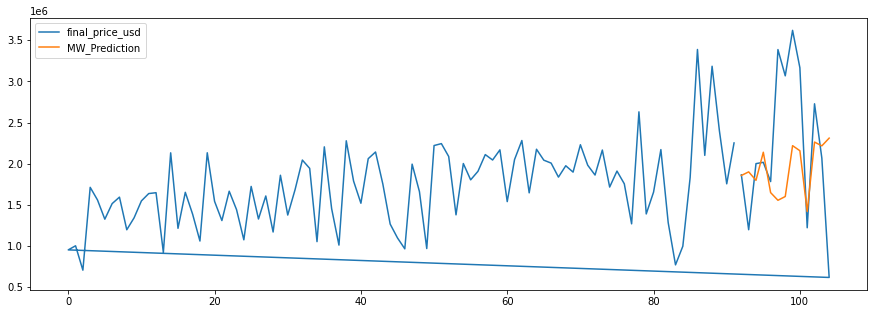

In [289]:
test['MW_Prediction'] = reg.predict(X_test)
result = pd.concat([test, train], sort=False)
_ = result[['final_price_usd','MW_Prediction']].plot(figsize=(15, 5))

### Подсчет ошибки прогнозирования суммарной квартальной выручки

In [292]:
1 + (test['MW_Prediction'].sum() - test['final_price_usd'].sum() ) / test['final_price_usd'].sum() 

0.87289714476899

### Добавление тестовых значений на 2021 год

In [295]:
df = pd.read_csv('sales.csv') 
df = df.loc[df['product'] == 'CL']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')
df = df[['date', 'final_price_usd']]


In [296]:
start = datetime.datetime.strptime("01-01-2021", "%d-%m-%Y")
end = datetime.datetime.strptime("31-12-2021", "%d-%m-%Y")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

In [297]:

for date in date_generated:
    df = df.append({'date':date, 'final_price_usd':None}, ignore_index=True)

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is depreca

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is depreca

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is depreca

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is depreca

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is depreca

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is depreca

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/3549328430.py:2: FutureWarning:

The frame.append method is depreca

In [299]:
df = df.groupby([pd.Grouper(key='date', freq='W-MON')]).sum().reset_index().sort_values('date')

In [300]:
df = df.loc[df.date < '2022-01-01']

In [301]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofweek'] = df['date'].dt.dayofweek

df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/1385856662.py:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [302]:
train = df.loc[df.date < '2021-01-01']
test = df.loc[df.date >= '2021-01-01']

In [303]:
X_test = test.drop(columns=['final_price_usd', 'date'])


In [304]:
test.final_price_usd = None

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/1572711892.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Прогнозирование выручки

In [310]:
test['MW_Prediction'] = reg.predict(X_test)
result = pd.concat([test, train], sort=False)

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/2421080747.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### График выручки за 2019, 2020 и 2021 вместе с прогнозом 

In [321]:
prediction_fig = go.Figure()
prediction_fig.add_trace(go.Scatter(x=result.date, y=result.final_price_usd,
                    mode='lines',
                    name='Real revenue'))
prediction_fig.add_trace(go.Scatter(x=result.date, y=result.MW_Prediction,
                    mode='lines',
                    name='Predicted revenue'))
prediction_fig.update_layout(title_text='Прогноз выручки на 2021 год', title_x=0.5)

### Построение диаграмм годовой выручки по 2019, 2020 и прогнозному 2021 году

In [325]:
bar_prediction_chart = pd.DataFrame(columns=['Year', 'Revenue'])
bar_prediction_chart = bar_prediction_chart.append({'Year': '2019', 'Revenue': train.loc[train.date < '2020-01-01']['final_price_usd'].sum()}, ignore_index=True)
bar_prediction_chart = bar_prediction_chart.append({'Year': '2020', 'Revenue': train.loc[train.date >= '2020-01-01']['final_price_usd'].sum()}, ignore_index=True)
bar_prediction_chart = bar_prediction_chart.append({'Year': '2021 (Predicted)', 'Revenue': test['MW_Prediction'].sum()}, ignore_index=True)




/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/1607773135.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/1607773135.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1n/ht1_w_6n49d26f76pqqr3j5c6p385b/T/ipykernel_40191/1607773135.py:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [330]:
fig = px.bar(bar_prediction_chart, x='Year', y='Revenue', title='Прогнозная выручка CLion на 2021 год  в сравнении с реальной')
fig.show()

bar_prediction_chart

,Year,Revenue
0,2019,81752137.634
1,2020,104284606.837
2,2021 (Predicted),99338144.0


 ### Подсчет изменения прогнозной годовой выручки относительно значения 2020 года

In [324]:
result['MW_Prediction'].sum() / train.loc[train.date >'2020-01-01']['final_price_usd'].sum()

0.9525677375882382